In [1]:
%run function_and_library.ipynb

In [2]:
def open_file(num_row):
    # Initialize lists
    time_step = []
    sunspots = []
    currency = []

    with open('./currency_data_10_years.csv') as csvfile:

        reader = csv.reader(csvfile, delimiter=',')

        currency.append(next(reader)[num_row])
        
        for i,row in enumerate(reader):
            time_step.append(int(i))
            sunspots.append(float(row[num_row]))
            
    time = np.array(time_step)
    series = np.array(sunspots)
    
#     plot_series(time, series, xlabel='Day', ylabel=f'{currency}/IDR')
    return time, series, currency

In [3]:
def prepared_data(series, time, split_time, window_size, batch_size, shuffle_buffer_size):
    x_train = series[:split_time]
    time_train = time[:split_time]

    x_valid = series[split_time:]
    time_valid = time[split_time:]

    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
    valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
    
    return train_set, valid_set

In [4]:
def plot_loss(history):
    # Get mae and loss from history log
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    # Get number of epochs
    epochs=range(len(loss))

    plot_series(
        x=epochs, 
        y=(loss, val_loss), 
        title='LOSS and val LOSS', 
        xlabel='LOSS',
        ylabel='val LOSS',
        legend=['LOSS', 'val LOSS']
        )

In [5]:
def first_model(train_set, valid_set, window_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, input_shape=[window_size], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ], name=f"1_model_{currency[0]}")

    # Get initial weights
    init_weights = model.get_weights()

    # Reset states generated by Keras
    tf.keras.backend.clear_session()

    # Reset the weights
    model.set_weights(init_weights)

    model.summary()

    # Initialize the optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])

    # Train the model
    history = model.fit(train_set,
                          epochs=100,
                          verbose=1,
                          batch_size=batch_size,
                          validation_data=valid_set,
                          callbacks=[create_model_checkpoint()])
    model.evaluate(valid_set)
    plot_loss(history)
    
    return model


In [6]:
def second_model(train_set, valid_set, window_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)
    ], name=f"2_model_{currency[0]}")

    # Get initial weights
    init_weights = model.get_weights()

    # Reset states generated by Keras
    tf.keras.backend.clear_session()

    # Reset the weights
    model.set_weights(init_weights)

    model.summary()

    # Initialize the optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])

    # Train the model
    history = model.fit(train_set,
                          epochs=100,
                          verbose=1,
                          batch_size=batch_size,
                          validation_data=valid_set,
                          callbacks=[create_model_checkpoint()])
    model.evaluate(valid_set)
    plot_loss(history)
    
    return model


In [20]:
def evaluate_model(model, series, split_time, window_size, batch_size, count, eval_models, currency):

    # Reduce the original series
    forecast_series = series[split_time-window_size:-1]

    # Use helper function to generate predictions
    forecast = model_forecast(model, forecast_series, window_size, batch_size)

    # Drop single dimensional axes
    results = forecast.squeeze()

    # Plot the results
    plot_series(time[split_time:], (series[split_time:], results))

    eval_model = evaluate_preds(y_true=series[split_time:],
                                   y_pred=results)
    print(eval_model)
    
    model_name = f"model_{currency[count//2]}/IDR"
    eval_models[model_name] = eval_model
    count += 1

Model: "1_model_EUR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     20/Unknown - 2s 19ms/step - loss: 4661.8330 - mae: 4660.7065

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 4s 96ms/step - loss: 4172.2544 - mae: 4171.1499 - val_loss: 355.7267 - val_mae: 354.7912
Epoch 2/100
15/24 [=================>............] - ETA: 0s - loss: 482.7694 - mae: 481.9094

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 75ms/step - loss: 420.9986 - mae: 420.1778 - val_loss: 173.2162 - val_mae: 172.5109
Epoch 3/100
15/24 [=================>............] - ETA: 0s - loss: 211.7926 - mae: 211.1378

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 73ms/step - loss: 211.2392 - mae: 210.6105 - val_loss: 164.2701 - val_mae: 163.7189
Epoch 4/100
24/24 [==============================] - 1s 20ms/step - loss: 217.4449 - mae: 216.9448 - val_loss: 177.7774 - val_mae: 177.3284
Epoch 5/100
16/24 [===================>..........] - ETA: 0s - loss: 225.1284 - mae: 224.7037

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 65ms/step - loss: 223.1172 - mae: 222.7023 - val_loss: 156.2629 - val_mae: 155.8789
Epoch 6/100
16/24 [===================>..........] - ETA: 0s - loss: 201.0858 - mae: 200.7199

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 72ms/step - loss: 197.7602 - mae: 197.4008 - val_loss: 146.4642 - val_mae: 146.1263
Epoch 7/100
24/24 [==============================] - 1s 25ms/step - loss: 215.9096 - mae: 215.5863 - val_loss: 227.5032 - val_mae: 227.1938
Epoch 8/100
17/24 [====================>.........] - ETA: 0s - loss: 239.7956 - mae: 239.4932

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 65ms/step - loss: 253.5094 - mae: 253.2094 - val_loss: 144.1346 - val_mae: 143.8434
Epoch 9/100
24/24 [==============================] - 1s 20ms/step - loss: 192.3634 - mae: 192.0783 - val_loss: 224.8469 - val_mae: 224.5672
Epoch 10/100
24/24 [==============================] - 1s 20ms/step - loss: 201.4763 - mae: 201.2011 - val_loss: 152.9769 - val_mae: 152.7053
Epoch 11/100
16/24 [===================>..........] - ETA: 0s - loss: 211.4317 - mae: 211.1623

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 73ms/step - loss: 236.9287 - mae: 236.6601 - val_loss: 130.1333 - val_mae: 129.8671
Epoch 12/100
16/24 [===================>..........] - ETA: 0s - loss: 172.8880 - mae: 172.6225

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 65ms/step - loss: 173.3342 - mae: 173.0694 - val_loss: 127.1286 - val_mae: 126.8656
Epoch 13/100
24/24 [==============================] - 1s 20ms/step - loss: 159.8182 - mae: 159.5554 - val_loss: 233.6404 - val_mae: 233.3796
Epoch 14/100
15/24 [=================>............] - ETA: 0s - loss: 189.2258 - mae: 188.9648

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 67ms/step - loss: 181.6499 - mae: 181.3889 - val_loss: 119.9345 - val_mae: 119.6736
Epoch 15/100
24/24 [==============================] - 1s 20ms/step - loss: 186.9969 - mae: 186.7369 - val_loss: 550.2429 - val_mae: 549.9838
Epoch 16/100
24/24 [==============================] - 1s 20ms/step - loss: 283.6984 - mae: 283.4398 - val_loss: 294.5102 - val_mae: 294.2515
Epoch 17/100
24/24 [==============================] - 1s 20ms/step - loss: 234.2296 - mae: 233.9716 - val_loss: 384.9481 - val_mae: 384.6910
Epoch 18/100
24/24 [==============================] - 1s 20ms/step - loss: 213.1929 - mae: 212.9360 - val_loss: 380.3704 - val_mae: 380.1140
Epoch 19/100
24/24 [==============================] - 1s 20ms/step - loss: 238.1126 - mae: 237.8562 - val_loss: 162.4960 - val_mae: 162.2383
Epoch 20/100
24/24 [==============================] - 1s 20ms/step - loss: 154.1972 - mae: 153.9408 - val_loss: 127.5240 - val_mae: 127.2683
Epoch 21/100
16/24 [======

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 65ms/step - loss: 153.3842 - mae: 153.1282 - val_loss: 112.4800 - val_mae: 112.2246
Epoch 22/100
24/24 [==============================] - 1s 20ms/step - loss: 140.9457 - mae: 140.6891 - val_loss: 127.8081 - val_mae: 127.5517
Epoch 23/100
24/24 [==============================] - 1s 20ms/step - loss: 160.3223 - mae: 160.0659 - val_loss: 148.2413 - val_mae: 147.9841
Epoch 24/100
24/24 [==============================] - 1s 20ms/step - loss: 141.7968 - mae: 141.5407 - val_loss: 123.9012 - val_mae: 123.6456
Epoch 25/100
16/24 [===================>..........] - ETA: 0s - loss: 268.4416 - mae: 268.1861

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 65ms/step - loss: 259.2310 - mae: 258.9753 - val_loss: 107.8536 - val_mae: 107.5973
Epoch 26/100
16/24 [===================>..........] - ETA: 0s - loss: 124.2899 - mae: 124.0342

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 66ms/step - loss: 133.0593 - mae: 132.8037 - val_loss: 106.3947 - val_mae: 106.1401
Epoch 27/100
24/24 [==============================] - 1s 20ms/step - loss: 135.5241 - mae: 135.2684 - val_loss: 144.6646 - val_mae: 144.4094
Epoch 28/100
24/24 [==============================] - 1s 20ms/step - loss: 136.8376 - mae: 136.5818 - val_loss: 219.8661 - val_mae: 219.6109
Epoch 29/100
24/24 [==============================] - 1s 20ms/step - loss: 273.0829 - mae: 272.8282 - val_loss: 185.9575 - val_mae: 185.7033
Epoch 30/100
24/24 [==============================] - 1s 20ms/step - loss: 155.0327 - mae: 154.7783 - val_loss: 135.5024 - val_mae: 135.2472
Epoch 31/100
24/24 [==============================] - 1s 20ms/step - loss: 138.8592 - mae: 138.6053 - val_loss: 133.4461 - val_mae: 133.1922
Epoch 32/100
24/24 [==============================] - 1s 20ms/step - loss: 137.3055 - mae: 137.0514 - val_loss: 119.3167 - val_mae: 119.0624
Epoch 33/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 76ms/step - loss: 171.8206 - mae: 171.5665 - val_loss: 102.5909 - val_mae: 102.3359
Epoch 35/100
16/24 [===================>..........] - ETA: 0s - loss: 126.0668 - mae: 125.8125

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 65ms/step - loss: 132.3384 - mae: 132.0842 - val_loss: 96.2816 - val_mae: 96.0281
Epoch 36/100
24/24 [==============================] - 1s 20ms/step - loss: 134.2160 - mae: 133.9622 - val_loss: 122.3013 - val_mae: 122.0473
Epoch 37/100
24/24 [==============================] - 1s 20ms/step - loss: 127.3023 - mae: 127.0483 - val_loss: 186.6223 - val_mae: 186.3691
Epoch 38/100
24/24 [==============================] - 1s 20ms/step - loss: 171.5935 - mae: 171.3403 - val_loss: 263.3673 - val_mae: 263.1148
Epoch 39/100
24/24 [==============================] - 1s 25ms/step - loss: 246.7759 - mae: 246.5233 - val_loss: 251.9329 - val_mae: 251.6808
Epoch 40/100
24/24 [==============================] - 1s 23ms/step - loss: 213.9012 - mae: 213.6491 - val_loss: 260.4319 - val_mae: 260.1802
Epoch 41/100
24/24 [==============================] - 1s 22ms/step - loss: 210.3340 - mae: 210.0818 - val_loss: 345.5821 - val_mae: 345.3302
Epoch 42/100
24/24 [========

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 65ms/step - loss: 140.1678 - mae: 139.9120 - val_loss: 90.7828 - val_mae: 90.5271
Epoch 55/100
24/24 [==============================] - 1s 20ms/step - loss: 217.2191 - mae: 216.9634 - val_loss: 138.3084 - val_mae: 138.0516
Epoch 56/100
24/24 [==============================] - 1s 21ms/step - loss: 213.7108 - mae: 213.4552 - val_loss: 111.0670 - val_mae: 110.8103
Epoch 57/100
24/24 [==============================] - 1s 20ms/step - loss: 159.2166 - mae: 158.9605 - val_loss: 139.1444 - val_mae: 138.8866
Epoch 58/100
24/24 [==============================] - 1s 23ms/step - loss: 151.6985 - mae: 151.4420 - val_loss: 94.9328 - val_mae: 94.6735
Epoch 59/100
24/24 [==============================] - 1s 20ms/step - loss: 122.6874 - mae: 122.4304 - val_loss: 143.5403 - val_mae: 143.2825
Epoch 60/100
24/24 [==============================] - 1s 20ms/step - loss: 124.8649 - mae: 124.6079 - val_loss: 93.4040 - val_mae: 93.1475
Epoch 61/100
24/24 [============

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 66ms/step - loss: 114.2666 - mae: 114.0101 - val_loss: 90.4459 - val_mae: 90.1898
Epoch 63/100
24/24 [==============================] - 1s 20ms/step - loss: 115.0387 - mae: 114.7818 - val_loss: 208.4920 - val_mae: 208.2361
Epoch 64/100
24/24 [==============================] - 1s 20ms/step - loss: 205.0497 - mae: 204.7935 - val_loss: 132.0082 - val_mae: 131.7517
Epoch 65/100
24/24 [==============================] - 1s 20ms/step - loss: 170.5356 - mae: 170.2798 - val_loss: 102.6517 - val_mae: 102.3961
Epoch 66/100
24/24 [==============================] - 1s 20ms/step - loss: 190.0944 - mae: 189.8391 - val_loss: 146.1143 - val_mae: 145.8588
Epoch 67/100
24/24 [==============================] - 1s 20ms/step - loss: 117.9837 - mae: 117.7288 - val_loss: 99.9952 - val_mae: 99.7400
Epoch 68/100
24/24 [==============================] - 1s 20ms/step - loss: 119.6158 - mae: 119.3604 - val_loss: 169.4480 - val_mae: 169.1928
Epoch 69/100
24/24 [==========

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 66ms/step - loss: 106.7798 - mae: 106.5248 - val_loss: 87.8544 - val_mae: 87.6005
Epoch 72/100
24/24 [==============================] - 1s 20ms/step - loss: 122.2473 - mae: 121.9923 - val_loss: 96.2506 - val_mae: 95.9955
Epoch 73/100
24/24 [==============================] - 1s 20ms/step - loss: 180.4884 - mae: 180.2339 - val_loss: 137.9919 - val_mae: 137.7375
Epoch 74/100
24/24 [==============================] - 1s 20ms/step - loss: 184.1086 - mae: 183.8547 - val_loss: 191.3576 - val_mae: 191.1044
Epoch 75/100
24/24 [==============================] - 1s 20ms/step - loss: 154.4319 - mae: 154.1785 - val_loss: 89.3615 - val_mae: 89.1071
Epoch 76/100
24/24 [==============================] - 1s 20ms/step - loss: 143.8558 - mae: 143.6025 - val_loss: 139.6672 - val_mae: 139.4139
Epoch 77/100
24/24 [==============================] - 1s 20ms/step - loss: 117.5526 - mae: 117.2989 - val_loss: 115.0812 - val_mae: 114.8286
Epoch 78/100
24/24 [============

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


24/24 [==============================] - 2s 66ms/step - loss: 206.5234 - mae: 206.2724 - val_loss: 87.2742 - val_mae: 87.0234
Epoch 95/100
24/24 [==============================] - 1s 20ms/step - loss: 173.9062 - mae: 173.6560 - val_loss: 105.9407 - val_mae: 105.6898
Epoch 96/100
24/24 [==============================] - 1s 20ms/step - loss: 124.9459 - mae: 124.6951 - val_loss: 219.4998 - val_mae: 219.2501
Epoch 97/100
24/24 [==============================] - 1s 20ms/step - loss: 159.6607 - mae: 159.4105 - val_loss: 107.0480 - val_mae: 106.7974
Epoch 98/100
24/24 [==============================] - 1s 20ms/step - loss: 116.7521 - mae: 116.5013 - val_loss: 158.9254 - val_mae: 158.6760
Epoch 99/100
24/24 [==============================] - 1s 20ms/step - loss: 116.6849 - mae: 116.4347 - val_loss: 144.8004 - val_mae: 144.5509
Epoch 100/100
5/5 [==============================] - 0s 10ms/step - loss: 88.5287 - mae: 88.2783


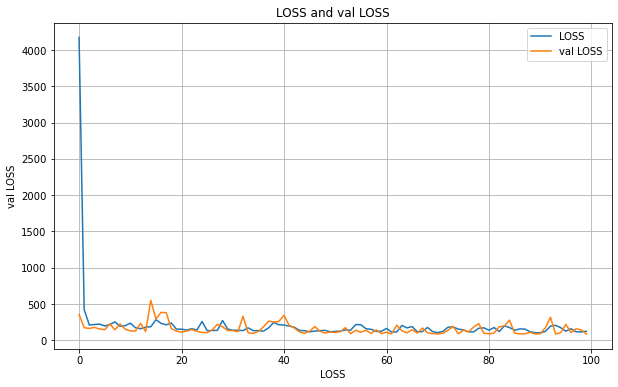

6/6 [==============================] - 0s 22ms/step


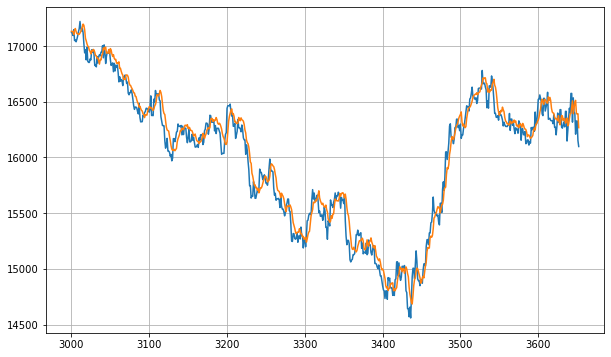

{'mae': 87.30071, 'mse': 11888.888, 'rmse': 109.03618, 'mape': 0.54900885, 'mase': 1.6869162}
Model: "1_model_USD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     15/Unknown - 2s 22ms/step - loss: 6106.7129 - mae: 6105.5752

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 3s 86ms/step - loss: 4399.9761 - mae: 4398.8984 - val_loss: 1359.0881 - val_mae: 1358.1918
Epoch 2/100
15/24 [=================>............] - ETA: 0s - loss: 616.1523 - mae: 615.3366

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 66ms/step - loss: 503.2413 - mae: 502.4678 - val_loss: 130.9056 - val_mae: 130.2558
Epoch 3/100
20/24 [========================>.....] - ETA: 0s - loss: 187.1127 - mae: 186.5351

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 69ms/step - loss: 186.9067 - mae: 186.3398 - val_loss: 112.6120 - val_mae: 112.1265
Epoch 4/100
24/24 [==============================] - 1s 20ms/step - loss: 157.0453 - mae: 156.6143 - val_loss: 118.8225 - val_mae: 118.4450
Epoch 5/100
24/24 [==============================] - 1s 20ms/step - loss: 160.9153 - mae: 160.5737 - val_loss: 114.7157 - val_mae: 114.4093
Epoch 6/100
24/24 [==============================] - 1s 20ms/step - loss: 188.7086 - mae: 188.4251 - val_loss: 154.5269 - val_mae: 154.2665
Epoch 7/100
16/24 [===================>..........] - ETA: 0s - loss: 180.4637 - mae: 180.2146

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 67ms/step - loss: 177.1489 - mae: 176.9042 - val_loss: 107.7063 - val_mae: 107.4749
Epoch 8/100
24/24 [==============================] - 1s 20ms/step - loss: 152.7091 - mae: 152.4885 - val_loss: 109.4560 - val_mae: 109.2456
Epoch 9/100
24/24 [==============================] - 1s 20ms/step - loss: 157.9490 - mae: 157.7447 - val_loss: 107.9555 - val_mae: 107.7559
Epoch 10/100
24/24 [==============================] - 1s 20ms/step - loss: 158.7613 - mae: 158.5654 - val_loss: 130.5694 - val_mae: 130.3790
Epoch 11/100
24/24 [==============================] - 1s 19ms/step - loss: 144.4337 - mae: 144.2444 - val_loss: 131.4970 - val_mae: 131.3113
Epoch 12/100
16/24 [===================>..........] - ETA: 0s - loss: 141.3058 - mae: 141.1200

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 64ms/step - loss: 142.0870 - mae: 141.9017 - val_loss: 98.5003 - val_mae: 98.3162
Epoch 13/100
24/24 [==============================] - 1s 20ms/step - loss: 173.7684 - mae: 173.5858 - val_loss: 110.8156 - val_mae: 110.6349
Epoch 14/100
24/24 [==============================] - 1s 20ms/step - loss: 194.4835 - mae: 194.3033 - val_loss: 151.5792 - val_mae: 151.4000
Epoch 15/100
24/24 [==============================] - 1s 20ms/step - loss: 160.6577 - mae: 160.4784 - val_loss: 198.8307 - val_mae: 198.6525
Epoch 16/100
16/24 [===================>..........] - ETA: 0s - loss: 146.9743 - mae: 146.7954

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 65ms/step - loss: 144.4367 - mae: 144.2576 - val_loss: 96.7343 - val_mae: 96.5565
Epoch 17/100
15/24 [=================>............] - ETA: 0s - loss: 136.8428 - mae: 136.6653

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 74ms/step - loss: 138.1266 - mae: 137.9491 - val_loss: 92.0173 - val_mae: 91.8398
Epoch 18/100
24/24 [==============================] - 1s 20ms/step - loss: 163.1876 - mae: 163.0098 - val_loss: 146.5172 - val_mae: 146.3407
Epoch 19/100
24/24 [==============================] - 1s 20ms/step - loss: 125.3973 - mae: 125.2198 - val_loss: 110.9820 - val_mae: 110.8057
Epoch 20/100
24/24 [==============================] - 1s 20ms/step - loss: 129.2169 - mae: 129.0403 - val_loss: 160.0366 - val_mae: 159.8602
Epoch 21/100
24/24 [==============================] - 1s 20ms/step - loss: 155.5775 - mae: 155.4014 - val_loss: 196.9217 - val_mae: 196.7464
Epoch 22/100
16/24 [===================>..........] - ETA: 0s - loss: 207.4323 - mae: 207.2570

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 65ms/step - loss: 205.4423 - mae: 205.2672 - val_loss: 85.7466 - val_mae: 85.5700
Epoch 23/100
24/24 [==============================] - 1s 20ms/step - loss: 181.8364 - mae: 181.6614 - val_loss: 178.9452 - val_mae: 178.7712
Epoch 24/100
24/24 [==============================] - 1s 20ms/step - loss: 174.6868 - mae: 174.5127 - val_loss: 166.4094 - val_mae: 166.2338
Epoch 25/100
24/24 [==============================] - 1s 20ms/step - loss: 139.4049 - mae: 139.2301 - val_loss: 204.3964 - val_mae: 204.2231
Epoch 26/100
24/24 [==============================] - 1s 20ms/step - loss: 125.2310 - mae: 125.0567 - val_loss: 163.7092 - val_mae: 163.5361
Epoch 27/100
24/24 [==============================] - 1s 20ms/step - loss: 148.9771 - mae: 148.8036 - val_loss: 92.4323 - val_mae: 92.2578
Epoch 28/100
24/24 [==============================] - 1s 20ms/step - loss: 126.4573 - mae: 126.2838 - val_loss: 213.2884 - val_mae: 213.1157
Epoch 29/100
24/24 [==========

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 66ms/step - loss: 116.8583 - mae: 116.6858 - val_loss: 81.2040 - val_mae: 81.0317
Epoch 32/100
24/24 [==============================] - 1s 20ms/step - loss: 136.9971 - mae: 136.8249 - val_loss: 85.0379 - val_mae: 84.8655
Epoch 33/100
24/24 [==============================] - 1s 20ms/step - loss: 106.3671 - mae: 106.1947 - val_loss: 122.2152 - val_mae: 122.0441
Epoch 34/100
24/24 [==============================] - 1s 20ms/step - loss: 170.7339 - mae: 170.5628 - val_loss: 116.7293 - val_mae: 116.5586
Epoch 35/100
24/24 [==============================] - 1s 20ms/step - loss: 156.9557 - mae: 156.7848 - val_loss: 200.2112 - val_mae: 200.0411
Epoch 36/100
24/24 [==============================] - 1s 22ms/step - loss: 149.1834 - mae: 149.0124 - val_loss: 205.3743 - val_mae: 205.2039
Epoch 37/100
24/24 [==============================] - 1s 20ms/step - loss: 187.3153 - mae: 187.1454 - val_loss: 134.4522 - val_mae: 134.2825
Epoch 38/100
16/24 [==========

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 65ms/step - loss: 104.3570 - mae: 104.1866 - val_loss: 77.8532 - val_mae: 77.6824
Epoch 39/100
16/24 [===================>..........] - ETA: 0s - loss: 101.5911 - mae: 101.4206

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 65ms/step - loss: 107.2552 - mae: 107.0848 - val_loss: 72.6079 - val_mae: 72.4366
Epoch 40/100
24/24 [==============================] - 1s 20ms/step - loss: 103.6568 - mae: 103.4858 - val_loss: 75.7568 - val_mae: 75.5848
Epoch 41/100
16/24 [===================>..........] - ETA: 0s - loss: 105.5750 - mae: 105.4045

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 65ms/step - loss: 107.2786 - mae: 107.1080 - val_loss: 70.3388 - val_mae: 70.1680
Epoch 42/100
24/24 [==============================] - 1s 20ms/step - loss: 154.4438 - mae: 154.2742 - val_loss: 256.0056 - val_mae: 255.8365
Epoch 43/100
24/24 [==============================] - 1s 20ms/step - loss: 162.3578 - mae: 162.1884 - val_loss: 175.2932 - val_mae: 175.1242
Epoch 44/100
24/24 [==============================] - 1s 20ms/step - loss: 131.0596 - mae: 130.8907 - val_loss: 143.2786 - val_mae: 143.1104
Epoch 45/100
24/24 [==============================] - 1s 20ms/step - loss: 150.2816 - mae: 150.1126 - val_loss: 165.6091 - val_mae: 165.4406
Epoch 46/100
24/24 [==============================] - 1s 20ms/step - loss: 156.7741 - mae: 156.6052 - val_loss: 161.2896 - val_mae: 161.1206
Epoch 47/100
24/24 [==============================] - 1s 20ms/step - loss: 124.0586 - mae: 123.8887 - val_loss: 133.9117 - val_mae: 133.7417
Epoch 48/100
24/24 [========

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 73ms/step - loss: 93.9282 - mae: 93.7540 - val_loss: 65.2608 - val_mae: 65.0854
Epoch 63/100
24/24 [==============================] - 1s 20ms/step - loss: 121.6531 - mae: 121.4791 - val_loss: 81.0820 - val_mae: 80.9083
Epoch 64/100
24/24 [==============================] - 1s 20ms/step - loss: 102.2895 - mae: 102.1165 - val_loss: 117.6959 - val_mae: 117.5233
Epoch 65/100
16/24 [===================>..........] - ETA: 0s - loss: 81.5211 - mae: 81.3475

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 78ms/step - loss: 87.5693 - mae: 87.3956 - val_loss: 64.4249 - val_mae: 64.2506
Epoch 66/100
24/24 [==============================] - 1s 23ms/step - loss: 90.3359 - mae: 90.1623 - val_loss: 107.6634 - val_mae: 107.4902
Epoch 67/100
24/24 [==============================] - 1s 22ms/step - loss: 122.2887 - mae: 122.1158 - val_loss: 184.4348 - val_mae: 184.2630
Epoch 68/100
24/24 [==============================] - 1s 23ms/step - loss: 136.8364 - mae: 136.6644 - val_loss: 137.4791 - val_mae: 137.3075
Epoch 69/100
24/24 [==============================] - 1s 20ms/step - loss: 134.3731 - mae: 134.2017 - val_loss: 162.9112 - val_mae: 162.7400
Epoch 70/100
24/24 [==============================] - 1s 20ms/step - loss: 120.8934 - mae: 120.7212 - val_loss: 210.1630 - val_mae: 209.9919
Epoch 71/100
24/24 [==============================] - 1s 23ms/step - loss: 142.5331 - mae: 142.3611 - val_loss: 200.3931 - val_mae: 200.2220
Epoch 72/100
24/24 [============

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 89ms/step - loss: 94.2668 - mae: 94.0951 - val_loss: 63.2327 - val_mae: 63.0605
Epoch 74/100
24/24 [==============================] - 1s 25ms/step - loss: 91.7211 - mae: 91.5501 - val_loss: 69.9670 - val_mae: 69.7960
Epoch 75/100
24/24 [==============================] - 1s 25ms/step - loss: 86.5655 - mae: 86.3939 - val_loss: 82.2158 - val_mae: 82.0458
Epoch 76/100
24/24 [==============================] - 1s 26ms/step - loss: 88.7586 - mae: 88.5873 - val_loss: 83.3361 - val_mae: 83.1662
Epoch 77/100
24/24 [==============================] - 1s 25ms/step - loss: 88.7628 - mae: 88.5918 - val_loss: 75.2784 - val_mae: 75.1078
Epoch 78/100
24/24 [==============================] - 1s 26ms/step - loss: 84.4319 - mae: 84.2607 - val_loss: 118.5819 - val_mae: 118.4126
Epoch 79/100
24/24 [==============================] - 1s 26ms/step - loss: 177.6770 - mae: 177.5067 - val_loss: 354.6237 - val_mae: 354.4547
Epoch 80/100
24/24 [============================

INFO:tensorflow:Assets written to: saved_model/2\assets


INFO:tensorflow:Assets written to: saved_model/2\assets


24/24 [==============================] - 2s 83ms/step - loss: 112.6480 - mae: 112.4791 - val_loss: 61.5122 - val_mae: 61.3431
Epoch 90/100
24/24 [==============================] - 1s 24ms/step - loss: 146.0204 - mae: 145.8530 - val_loss: 177.0145 - val_mae: 176.8477
Epoch 91/100
24/24 [==============================] - 1s 26ms/step - loss: 118.7162 - mae: 118.5491 - val_loss: 126.6228 - val_mae: 126.4549
Epoch 92/100
24/24 [==============================] - 1s 25ms/step - loss: 115.9630 - mae: 115.7961 - val_loss: 78.3971 - val_mae: 78.2302
Epoch 93/100
24/24 [==============================] - 1s 24ms/step - loss: 83.2517 - mae: 83.0842 - val_loss: 87.8374 - val_mae: 87.6709
Epoch 94/100
24/24 [==============================] - 1s 24ms/step - loss: 86.7879 - mae: 86.6204 - val_loss: 62.3530 - val_mae: 62.1845
Epoch 95/100
24/24 [==============================] - 1s 25ms/step - loss: 141.4267 - mae: 141.2610 - val_loss: 192.9841 - val_mae: 192.8189
Epoch 96/100
24/24 [==================

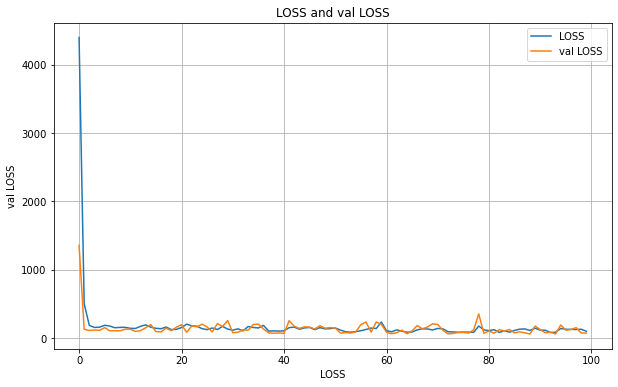

6/6 [==============================] - 0s 26ms/step


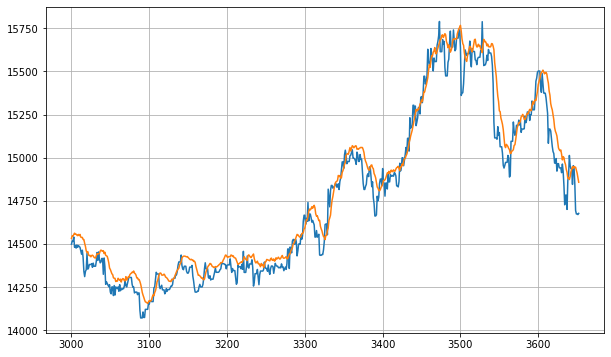

{'mae': 73.63702, 'mse': 9413.188, 'rmse': 97.02159, 'mape': 0.49813256, 'mase': 2.3123302}
Model: "1_model_JPY"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     15/Unknown - 2s 25ms/step - loss: 18.2112 - mae: 17.0705

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 4s 96ms/step - loss: 14.4783 - mae: 13.4045 - val_loss: 5.0957 - val_mae: 4.2247
Epoch 2/100
15/24 [=================>............] - ETA: 0s - loss: 3.9539 - mae: 3.1561

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 97ms/step - loss: 3.5614 - mae: 2.8046 - val_loss: 2.3496 - val_mae: 1.7057
Epoch 3/100
16/24 [===================>..........] - ETA: 0s - loss: 2.0628 - mae: 1.4693

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 85ms/step - loss: 2.0365 - mae: 1.4686 - val_loss: 1.9600 - val_mae: 1.4902
Epoch 4/100
24/24 [==============================] - 1s 26ms/step - loss: 1.9174 - mae: 1.5066 - val_loss: 2.0073 - val_mae: 1.6761
Epoch 5/100
15/24 [=================>............] - ETA: 0s - loss: 1.8159 - mae: 1.5010

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 84ms/step - loss: 1.7973 - mae: 1.4932 - val_loss: 1.7932 - val_mae: 1.5368
Epoch 6/100
24/24 [==============================] - 1s 25ms/step - loss: 1.7113 - mae: 1.4731 - val_loss: 1.8017 - val_mae: 1.6063
Epoch 7/100
15/24 [=================>............] - ETA: 0s - loss: 1.5634 - mae: 1.3575

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 85ms/step - loss: 1.5544 - mae: 1.3547 - val_loss: 1.4977 - val_mae: 1.3208
Epoch 8/100
15/24 [=================>............] - ETA: 0s - loss: 1.4819 - mae: 1.3081

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 3s 116ms/step - loss: 1.4919 - mae: 1.3200 - val_loss: 1.3820 - val_mae: 1.2245
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 1.6509 - mae: 1.5153 - val_loss: 1.7871 - val_mae: 1.6769
Epoch 10/100
15/24 [=================>............] - ETA: 0s - loss: 1.6558 - mae: 1.5331

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 3s 104ms/step - loss: 1.6934 - mae: 1.5736 - val_loss: 1.3167 - val_mae: 1.1813
Epoch 11/100
24/24 [==============================] - 1s 27ms/step - loss: 1.4131 - mae: 1.2814 - val_loss: 1.3310 - val_mae: 1.2138
Epoch 12/100
24/24 [==============================] - 1s 25ms/step - loss: 1.7991 - mae: 1.7095 - val_loss: 1.4141 - val_mae: 1.3068
Epoch 13/100
15/24 [=================>............] - ETA: 0s - loss: 1.6545 - mae: 1.5587

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 87ms/step - loss: 1.5949 - mae: 1.4944 - val_loss: 1.2506 - val_mae: 1.1276
Epoch 14/100
24/24 [==============================] - 1s 26ms/step - loss: 1.4150 - mae: 1.3077 - val_loss: 1.9027 - val_mae: 1.8407
Epoch 15/100
24/24 [==============================] - 1s 24ms/step - loss: 1.4058 - mae: 1.3013 - val_loss: 2.1084 - val_mae: 2.0539
Epoch 16/100
16/24 [===================>..........] - ETA: 0s - loss: 1.5267 - mae: 1.4371

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 96ms/step - loss: 1.4943 - mae: 1.3998 - val_loss: 1.1964 - val_mae: 1.0841
Epoch 17/100
15/24 [=================>............] - ETA: 0s - loss: 1.2567 - mae: 1.1456

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 82ms/step - loss: 1.2781 - mae: 1.1669 - val_loss: 1.1818 - val_mae: 1.0655
Epoch 18/100
24/24 [==============================] - 1s 23ms/step - loss: 1.3066 - mae: 1.2022 - val_loss: 1.2106 - val_mae: 1.0979
Epoch 19/100
20/24 [========================>.....] - ETA: 0s - loss: 1.3063 - mae: 1.1996

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 84ms/step - loss: 1.3340 - mae: 1.2322 - val_loss: 1.1759 - val_mae: 1.0722
Epoch 20/100
24/24 [==============================] - 1s 23ms/step - loss: 1.3946 - mae: 1.3017 - val_loss: 1.4252 - val_mae: 1.3490
Epoch 21/100
15/24 [=================>............] - ETA: 0s - loss: 1.3375 - mae: 1.2396

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 86ms/step - loss: 1.3229 - mae: 1.2225 - val_loss: 1.1265 - val_mae: 1.0129
Epoch 22/100
24/24 [==============================] - 1s 25ms/step - loss: 1.1978 - mae: 1.0907 - val_loss: 1.5567 - val_mae: 1.4965
Epoch 23/100
24/24 [==============================] - 1s 23ms/step - loss: 2.0039 - mae: 1.9556 - val_loss: 2.1368 - val_mae: 2.1090
Epoch 24/100
24/24 [==============================] - 1s 25ms/step - loss: 1.9286 - mae: 1.8873 - val_loss: 2.5059 - val_mae: 2.4929
Epoch 25/100
24/24 [==============================] - 1s 24ms/step - loss: 1.8639 - mae: 1.8166 - val_loss: 2.0518 - val_mae: 2.0216
Epoch 26/100
24/24 [==============================] - 1s 24ms/step - loss: 1.5683 - mae: 1.5063 - val_loss: 1.5667 - val_mae: 1.5165
Epoch 27/100
24/24 [==============================] - 1s 27ms/step - loss: 1.1979 - mae: 1.1013 - val_loss: 1.2355 - val_mae: 1.1551
Epoch 28/100
15/24 [=================>............] - ETA: 0s - loss: 1.1395 - mae

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 84ms/step - loss: 1.1421 - mae: 1.0415 - val_loss: 1.1158 - val_mae: 1.0175
Epoch 29/100
15/24 [=================>............] - ETA: 0s - loss: 1.1200 - mae: 1.0252

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 85ms/step - loss: 1.1538 - mae: 1.0612 - val_loss: 1.0338 - val_mae: 0.9292
Epoch 30/100
16/24 [===================>..........] - ETA: 0s - loss: 1.1249 - mae: 1.0292

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 96ms/step - loss: 1.1196 - mae: 1.0196 - val_loss: 1.0200 - val_mae: 0.9157
Epoch 31/100
16/24 [===================>..........] - ETA: 0s - loss: 1.0982 - mae: 0.9972

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 84ms/step - loss: 1.1451 - mae: 1.0503 - val_loss: 1.0119 - val_mae: 0.9077
Epoch 32/100
24/24 [==============================] - 1s 24ms/step - loss: 1.1275 - mae: 1.0301 - val_loss: 1.4323 - val_mae: 1.3838
Epoch 33/100
24/24 [==============================] - 1s 25ms/step - loss: 1.1354 - mae: 1.0464 - val_loss: 1.0280 - val_mae: 0.9309
Epoch 34/100
20/24 [========================>.....] - ETA: 0s - loss: 1.2279 - mae: 1.1552

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 81ms/step - loss: 1.2348 - mae: 1.1628 - val_loss: 0.9999 - val_mae: 0.9016
Epoch 35/100
24/24 [==============================] - 1s 23ms/step - loss: 1.0701 - mae: 0.9727 - val_loss: 1.1100 - val_mae: 1.0300
Epoch 36/100
15/24 [=================>............] - ETA: 0s - loss: 1.1016 - mae: 1.0127

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 79ms/step - loss: 1.1242 - mae: 1.0392 - val_loss: 0.9768 - val_mae: 0.8791
Epoch 37/100
16/24 [===================>..........] - ETA: 0s - loss: 1.0568 - mae: 0.9611

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 82ms/step - loss: 1.0419 - mae: 0.9432 - val_loss: 0.9393 - val_mae: 0.8386
Epoch 38/100
24/24 [==============================] - 1s 31ms/step - loss: 1.2778 - mae: 1.2150 - val_loss: 2.1512 - val_mae: 2.1608
Epoch 39/100
24/24 [==============================] - 1s 27ms/step - loss: 1.2300 - mae: 1.1655 - val_loss: 1.1734 - val_mae: 1.1078
Epoch 40/100
24/24 [==============================] - 1s 23ms/step - loss: 1.1027 - mae: 1.0188 - val_loss: 1.0702 - val_mae: 0.9949
Epoch 41/100
24/24 [==============================] - 1s 24ms/step - loss: 1.0242 - mae: 0.9315 - val_loss: 1.0705 - val_mae: 0.9974
Epoch 42/100
24/24 [==============================] - 1s 24ms/step - loss: 1.0942 - mae: 1.0166 - val_loss: 1.0833 - val_mae: 1.0139
Epoch 43/100
15/24 [=================>............] - ETA: 0s - loss: 1.2905 - mae: 1.2342

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 80ms/step - loss: 1.6780 - mae: 1.6360 - val_loss: 0.9062 - val_mae: 0.8115
Epoch 44/100
24/24 [==============================] - 1s 24ms/step - loss: 1.2514 - mae: 1.1980 - val_loss: 1.4085 - val_mae: 1.3915
Epoch 45/100
24/24 [==============================] - 1s 23ms/step - loss: 1.2511 - mae: 1.1986 - val_loss: 0.9831 - val_mae: 0.9036
Epoch 46/100
24/24 [==============================] - 1s 23ms/step - loss: 1.0065 - mae: 0.9192 - val_loss: 0.9337 - val_mae: 0.8430
Epoch 47/100
24/24 [==============================] - 1s 25ms/step - loss: 1.0520 - mae: 0.9815 - val_loss: 0.9375 - val_mae: 0.8489
Epoch 48/100
24/24 [==============================] - 1s 24ms/step - loss: 1.2737 - mae: 1.2306 - val_loss: 0.9684 - val_mae: 0.8915
Epoch 49/100
20/24 [========================>.....] - ETA: 0s - loss: 1.0565 - mae: 0.9804

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 82ms/step - loss: 1.0585 - mae: 0.9821 - val_loss: 0.8981 - val_mae: 0.8103
Epoch 50/100
15/24 [=================>............] - ETA: 0s - loss: 0.9716 - mae: 0.8934

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 3s 121ms/step - loss: 0.9806 - mae: 0.8980 - val_loss: 0.8789 - val_mae: 0.7903
Epoch 51/100
24/24 [==============================] - 1s 44ms/step - loss: 1.0344 - mae: 0.9645 - val_loss: 1.1870 - val_mae: 1.1507
Epoch 52/100
19/24 [======================>.......] - ETA: 0s - loss: 1.0935 - mae: 1.0328

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 6s 229ms/step - loss: 1.1132 - mae: 1.0564 - val_loss: 0.8635 - val_mae: 0.7748
Epoch 53/100
24/24 [==============================] - 2s 71ms/step - loss: 1.1347 - mae: 1.0729 - val_loss: 0.8941 - val_mae: 0.8126
Epoch 54/100
24/24 [==============================] - 2s 57ms/step - loss: 1.0311 - mae: 0.9660 - val_loss: 0.8784 - val_mae: 0.7897
Epoch 55/100
24/24 [==============================] - 1s 38ms/step - loss: 1.1301 - mae: 1.0815 - val_loss: 0.9974 - val_mae: 0.9382
Epoch 56/100
23/24 [===========================>..] - ETA: 0s - loss: 1.0372 - mae: 0.9698

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 3s 98ms/step - loss: 1.0360 - mae: 0.9685 - val_loss: 0.8622 - val_mae: 0.7799
Epoch 57/100
24/24 [==============================] - 1s 23ms/step - loss: 1.0566 - mae: 0.9991 - val_loss: 0.9386 - val_mae: 0.8646
Epoch 58/100
24/24 [==============================] - 1s 24ms/step - loss: 1.0601 - mae: 1.0026 - val_loss: 0.9033 - val_mae: 0.8319
Epoch 59/100
24/24 [==============================] - 1s 23ms/step - loss: 1.2209 - mae: 1.1871 - val_loss: 1.1651 - val_mae: 1.1375
Epoch 60/100
24/24 [==============================] - 1s 24ms/step - loss: 1.0056 - mae: 0.9413 - val_loss: 1.0739 - val_mae: 1.0337
Epoch 61/100
24/24 [==============================] - 1s 24ms/step - loss: 1.0269 - mae: 0.9672 - val_loss: 0.8684 - val_mae: 0.7947
Epoch 62/100
24/24 [==============================] - 1s 30ms/step - loss: 1.0005 - mae: 0.9366 - val_loss: 0.8668 - val_mae: 0.7858
Epoch 63/100
24/24 [==============================] - 1s 24ms/step - loss: 0.9621 

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 74ms/step - loss: 1.1671 - mae: 1.1343 - val_loss: 0.8326 - val_mae: 0.7520
Epoch 66/100
24/24 [==============================] - 1s 25ms/step - loss: 0.9751 - mae: 0.9186 - val_loss: 0.8632 - val_mae: 0.7882
Epoch 67/100
24/24 [==============================] - 1s 24ms/step - loss: 1.5064 - mae: 1.4871 - val_loss: 0.9614 - val_mae: 0.9157
Epoch 68/100
24/24 [==============================] - 1s 24ms/step - loss: 1.3793 - mae: 1.3674 - val_loss: 1.6478 - val_mae: 1.6829
Epoch 69/100
24/24 [==============================] - 1s 29ms/step - loss: 1.9390 - mae: 1.9757 - val_loss: 2.7909 - val_mae: 2.8527
Epoch 70/100
24/24 [==============================] - 1s 24ms/step - loss: 1.5396 - mae: 1.5400 - val_loss: 1.7865 - val_mae: 1.8296
Epoch 71/100
24/24 [==============================] - 1s 25ms/step - loss: 1.5995 - mae: 1.6264 - val_loss: 1.8878 - val_mae: 1.9360
Epoch 72/100
24/24 [==============================] - 1s 25ms/step - loss: 1.4813 

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 81ms/step - loss: 1.0188 - mae: 0.9818 - val_loss: 0.8187 - val_mae: 0.7523
Epoch 76/100
24/24 [==============================] - 1s 21ms/step - loss: 1.0359 - mae: 0.9925 - val_loss: 2.2641 - val_mae: 2.3300
Epoch 77/100
24/24 [==============================] - 1s 21ms/step - loss: 1.7046 - mae: 1.7449 - val_loss: 1.4446 - val_mae: 1.4750
Epoch 78/100
24/24 [==============================] - 1s 24ms/step - loss: 1.4641 - mae: 1.4776 - val_loss: 1.8880 - val_mae: 1.9459
Epoch 79/100
24/24 [==============================] - 1s 27ms/step - loss: 1.4703 - mae: 1.4898 - val_loss: 1.0703 - val_mae: 1.0563
Epoch 80/100
24/24 [==============================] - 1s 25ms/step - loss: 1.0395 - mae: 1.0116 - val_loss: 0.8272 - val_mae: 0.7715
Epoch 81/100
24/24 [==============================] - 1s 25ms/step - loss: 0.9238 - mae: 0.8784 - val_loss: 0.8198 - val_mae: 0.7633
Epoch 82/100
24/24 [==============================] - 1s 26ms/step - loss: 0.9567 

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 85ms/step - loss: 0.8983 - mae: 0.8475 - val_loss: 0.8028 - val_mae: 0.7474
Epoch 84/100
24/24 [==============================] - 1s 23ms/step - loss: 0.8902 - mae: 0.8378 - val_loss: 0.8932 - val_mae: 0.8495
Epoch 85/100
24/24 [==============================] - 1s 24ms/step - loss: 0.9849 - mae: 0.9586 - val_loss: 0.8272 - val_mae: 0.7723
Epoch 86/100
24/24 [==============================] - 1s 24ms/step - loss: 0.9633 - mae: 0.9320 - val_loss: 0.8479 - val_mae: 0.8063
Epoch 87/100
15/24 [=================>............] - ETA: 0s - loss: 0.9248 - mae: 0.8857

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 91ms/step - loss: 0.9606 - mae: 0.9317 - val_loss: 0.7834 - val_mae: 0.7285
Epoch 88/100
24/24 [==============================] - 1s 24ms/step - loss: 0.9594 - mae: 0.9289 - val_loss: 0.7877 - val_mae: 0.7358
Epoch 89/100
24/24 [==============================] - 1s 27ms/step - loss: 0.9332 - mae: 0.9005 - val_loss: 1.1469 - val_mae: 1.1615
Epoch 90/100
24/24 [==============================] - 1s 26ms/step - loss: 0.9217 - mae: 0.8902 - val_loss: 1.0983 - val_mae: 1.1123
Epoch 91/100
24/24 [==============================] - 1s 25ms/step - loss: 0.9202 - mae: 0.8839 - val_loss: 0.8900 - val_mae: 0.8568
Epoch 92/100
24/24 [==============================] - 1s 26ms/step - loss: 0.9051 - mae: 0.8671 - val_loss: 0.8821 - val_mae: 0.8571
Epoch 93/100
16/24 [===================>..........] - ETA: 0s - loss: 0.8867 - mae: 0.8551

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 67ms/step - loss: 0.9146 - mae: 0.8856 - val_loss: 0.7772 - val_mae: 0.7294
Epoch 94/100
16/24 [===================>..........] - ETA: 0s - loss: 0.8702 - mae: 0.8323

INFO:tensorflow:Assets written to: saved_model/3\assets


INFO:tensorflow:Assets written to: saved_model/3\assets


24/24 [==============================] - 2s 65ms/step - loss: 0.8848 - mae: 0.8486 - val_loss: 0.7592 - val_mae: 0.7062
Epoch 95/100
24/24 [==============================] - 1s 19ms/step - loss: 0.9736 - mae: 0.9543 - val_loss: 1.9567 - val_mae: 2.0366
Epoch 96/100
24/24 [==============================] - 1s 19ms/step - loss: 1.1383 - mae: 1.1420 - val_loss: 0.8376 - val_mae: 0.7990
Epoch 97/100
24/24 [==============================] - 1s 19ms/step - loss: 1.0970 - mae: 1.0867 - val_loss: 2.3095 - val_mae: 2.3988
Epoch 98/100
24/24 [==============================] - 1s 19ms/step - loss: 3.1542 - mae: 3.2424 - val_loss: 2.3205 - val_mae: 2.4090
Epoch 99/100
24/24 [==============================] - 1s 19ms/step - loss: 2.8049 - mae: 2.8918 - val_loss: 2.2005 - val_mae: 2.2879
Epoch 100/100
5/5 [==============================] - 0s 10ms/step - loss: 1.0003 - mae: 0.9969


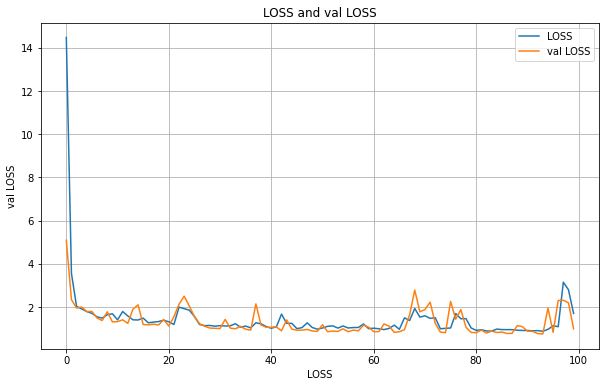

6/6 [==============================] - 0s 24ms/step


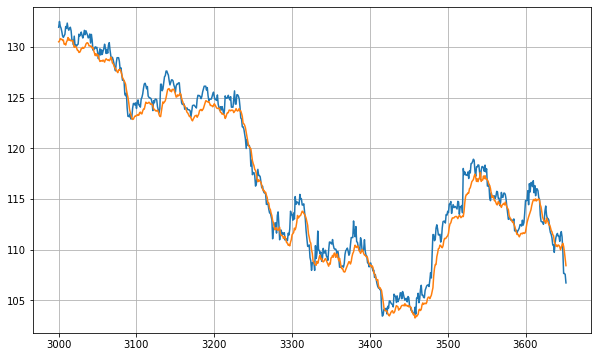

{'mae': 0.9949741, 'mse': 1.5688645, 'rmse': 1.2525432, 'mape': 0.85157764, 'mase': 2.282358}
Model: "1_model_GBP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     18/Unknown - 2s 16ms/step - loss: 2294.1238 - mae: 2292.9990

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 3s 71ms/step - loss: 1857.9578 - mae: 1856.8726 - val_loss: 347.4203 - val_mae: 346.5223
Epoch 2/100
24/24 [==============================] - 1s 18ms/step - loss: 339.4648 - mae: 338.6970 - val_loss: 412.1606 - val_mae: 411.5260
Epoch 3/100
17/24 [====================>.........] - ETA: 0s - loss: 347.8485 - mae: 347.2791

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 327.7090 - mae: 327.1620 - val_loss: 248.0963 - val_mae: 247.6375
Epoch 4/100
18/24 [=====================>........] - ETA: 0s - loss: 287.1889 - mae: 286.7760

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 281.9893 - mae: 281.5889 - val_loss: 239.2542 - val_mae: 238.9123
Epoch 5/100
18/24 [=====================>........] - ETA: 0s - loss: 301.8419 - mae: 301.5307

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 70ms/step - loss: 291.9686 - mae: 291.6655 - val_loss: 201.3140 - val_mae: 201.0493
Epoch 6/100
18/24 [=====================>........] - ETA: 0s - loss: 287.8596 - mae: 287.6144

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 280.7329 - mae: 280.4931 - val_loss: 196.6242 - val_mae: 196.4087
Epoch 7/100
18/24 [=====================>........] - ETA: 0s - loss: 289.0555 - mae: 288.8534

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 69ms/step - loss: 279.1652 - mae: 278.9665 - val_loss: 194.1055 - val_mae: 193.9231
Epoch 8/100
24/24 [==============================] - 1s 18ms/step - loss: 278.4366 - mae: 278.2646 - val_loss: 287.1159 - val_mae: 286.9540
Epoch 9/100
24/24 [==============================] - 1s 18ms/step - loss: 303.7479 - mae: 303.5929 - val_loss: 271.5370 - val_mae: 271.3889
Epoch 10/100
24/24 [==============================] - 1s 18ms/step - loss: 315.3466 - mae: 315.2026 - val_loss: 342.4468 - val_mae: 342.3071
Epoch 11/100
24/24 [==============================] - 1s 18ms/step - loss: 300.7346 - mae: 300.5972 - val_loss: 327.9681 - val_mae: 327.8334
Epoch 12/100
24/24 [==============================] - 1s 18ms/step - loss: 256.2787 - mae: 256.1461 - val_loss: 281.6093 - val_mae: 281.4789
Epoch 13/100
18/24 [=====================>........] - ETA: 0s - loss: 250.0765 - mae: 249.9472

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 59ms/step - loss: 251.1658 - mae: 251.0367 - val_loss: 185.6180 - val_mae: 185.4886
Epoch 14/100
19/24 [======================>.......] - ETA: 0s - loss: 236.7631 - mae: 236.6355

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 233.6324 - mae: 233.5046 - val_loss: 171.1971 - val_mae: 171.0692
Epoch 15/100
24/24 [==============================] - 1s 18ms/step - loss: 235.6418 - mae: 235.5155 - val_loss: 171.8160 - val_mae: 171.6899
Epoch 16/100
24/24 [==============================] - 1s 19ms/step - loss: 256.5230 - mae: 256.3979 - val_loss: 539.2203 - val_mae: 539.0956
Epoch 17/100
24/24 [==============================] - 1s 18ms/step - loss: 324.6632 - mae: 324.5387 - val_loss: 361.5024 - val_mae: 361.3787
Epoch 18/100
24/24 [==============================] - 1s 18ms/step - loss: 267.4244 - mae: 267.3008 - val_loss: 187.3018 - val_mae: 187.1767
Epoch 19/100
24/24 [==============================] - 1s 18ms/step - loss: 226.0002 - mae: 225.8771 - val_loss: 266.7002 - val_mae: 266.5770
Epoch 20/100
18/24 [=====================>........] - ETA: 0s - loss: 232.1113 - mae: 231.9876

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 68ms/step - loss: 225.6293 - mae: 225.5057 - val_loss: 158.0574 - val_mae: 157.9327
Epoch 21/100
24/24 [==============================] - 1s 18ms/step - loss: 238.4128 - mae: 238.2895 - val_loss: 272.0061 - val_mae: 271.8831
Epoch 22/100
24/24 [==============================] - 1s 18ms/step - loss: 222.1250 - mae: 222.0022 - val_loss: 181.3023 - val_mae: 181.1796
Epoch 23/100
18/24 [=====================>........] - ETA: 0s - loss: 216.7543 - mae: 216.6317

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 68ms/step - loss: 212.2769 - mae: 212.1544 - val_loss: 147.4557 - val_mae: 147.3329
Epoch 24/100
24/24 [==============================] - 1s 18ms/step - loss: 211.4501 - mae: 211.3281 - val_loss: 275.1983 - val_mae: 275.0758
Epoch 25/100
24/24 [==============================] - 1s 18ms/step - loss: 206.8520 - mae: 206.7301 - val_loss: 253.8147 - val_mae: 253.6922
Epoch 26/100
24/24 [==============================] - 1s 18ms/step - loss: 237.3030 - mae: 237.1813 - val_loss: 598.5984 - val_mae: 598.4775
Epoch 27/100
24/24 [==============================] - 1s 18ms/step - loss: 259.4477 - mae: 259.3265 - val_loss: 205.7699 - val_mae: 205.6494
Epoch 28/100
24/24 [==============================] - 1s 18ms/step - loss: 203.9488 - mae: 203.8279 - val_loss: 219.7933 - val_mae: 219.6723
Epoch 29/100
24/24 [==============================] - 1s 18ms/step - loss: 194.2882 - mae: 194.1676 - val_loss: 169.6986 - val_mae: 169.5774
Epoch 30/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 70ms/step - loss: 248.1124 - mae: 247.9939 - val_loss: 136.8239 - val_mae: 136.7057
Epoch 35/100
24/24 [==============================] - 1s 18ms/step - loss: 216.3869 - mae: 216.2687 - val_loss: 337.3865 - val_mae: 337.2690
Epoch 36/100
24/24 [==============================] - 1s 20ms/step - loss: 228.5517 - mae: 228.4338 - val_loss: 148.6050 - val_mae: 148.4869
Epoch 37/100
16/24 [===================>..........] - ETA: 0s - loss: 187.5220 - mae: 187.4040

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 71ms/step - loss: 179.9643 - mae: 179.8464 - val_loss: 133.3664 - val_mae: 133.2484
Epoch 38/100
24/24 [==============================] - 1s 18ms/step - loss: 234.4792 - mae: 234.3615 - val_loss: 141.4600 - val_mae: 141.3418
Epoch 39/100
18/24 [=====================>........] - ETA: 0s - loss: 191.6666 - mae: 191.5485

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 61ms/step - loss: 184.1662 - mae: 184.0482 - val_loss: 130.5804 - val_mae: 130.4619
Epoch 40/100
24/24 [==============================] - 1s 18ms/step - loss: 166.3718 - mae: 166.2545 - val_loss: 313.7120 - val_mae: 313.5956
Epoch 41/100
24/24 [==============================] - 1s 18ms/step - loss: 267.1346 - mae: 267.0177 - val_loss: 295.5830 - val_mae: 295.4665
Epoch 42/100
24/24 [==============================] - 1s 18ms/step - loss: 257.5172 - mae: 257.4004 - val_loss: 276.5686 - val_mae: 276.4525
Epoch 43/100
24/24 [==============================] - 1s 20ms/step - loss: 213.4353 - mae: 213.3188 - val_loss: 231.6244 - val_mae: 231.5083
Epoch 44/100
24/24 [==============================] - 1s 18ms/step - loss: 192.8079 - mae: 192.6917 - val_loss: 171.1115 - val_mae: 170.9949
Epoch 45/100
24/24 [==============================] - 1s 18ms/step - loss: 234.4704 - mae: 234.3532 - val_loss: 191.4327 - val_mae: 191.3156
Epoch 46/100
18/24 [======

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 62ms/step - loss: 215.2510 - mae: 215.1339 - val_loss: 128.4926 - val_mae: 128.3747
Epoch 47/100
24/24 [==============================] - 1s 20ms/step - loss: 164.3944 - mae: 164.2766 - val_loss: 213.8567 - val_mae: 213.7380
Epoch 48/100
24/24 [==============================] - 1s 20ms/step - loss: 189.8337 - mae: 189.7148 - val_loss: 234.4573 - val_mae: 234.3390
Epoch 49/100
24/24 [==============================] - 1s 20ms/step - loss: 175.8386 - mae: 175.7195 - val_loss: 245.1526 - val_mae: 245.0342
Epoch 50/100
24/24 [==============================] - 1s 18ms/step - loss: 225.4952 - mae: 225.3759 - val_loss: 238.2748 - val_mae: 238.1559
Epoch 51/100
24/24 [==============================] - 1s 18ms/step - loss: 192.4777 - mae: 192.3585 - val_loss: 229.4726 - val_mae: 229.3533
Epoch 52/100
24/24 [==============================] - 1s 18ms/step - loss: 190.0349 - mae: 189.9158 - val_loss: 253.6597 - val_mae: 253.5404
Epoch 53/100
18/24 [======

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 61ms/step - loss: 170.4150 - mae: 170.2951 - val_loss: 126.9184 - val_mae: 126.7985
Epoch 54/100
24/24 [==============================] - 1s 18ms/step - loss: 160.2140 - mae: 160.0930 - val_loss: 128.5083 - val_mae: 128.3869
Epoch 55/100
24/24 [==============================] - 1s 19ms/step - loss: 213.0528 - mae: 212.9311 - val_loss: 133.1054 - val_mae: 132.9823
Epoch 56/100
24/24 [==============================] - 1s 18ms/step - loss: 160.8434 - mae: 160.7209 - val_loss: 150.0741 - val_mae: 149.9506
Epoch 57/100
24/24 [==============================] - 1s 18ms/step - loss: 156.7203 - mae: 156.5963 - val_loss: 186.2592 - val_mae: 186.1359
Epoch 58/100
24/24 [==============================] - 1s 19ms/step - loss: 244.1860 - mae: 244.0622 - val_loss: 132.8233 - val_mae: 132.6982
Epoch 59/100
24/24 [==============================] - 1s 18ms/step - loss: 239.9743 - mae: 239.8504 - val_loss: 237.2382 - val_mae: 237.1152
Epoch 60/100
18/24 [======

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 68ms/step - loss: 172.5255 - mae: 172.4017 - val_loss: 120.8349 - val_mae: 120.7111
Epoch 61/100
24/24 [==============================] - 1s 18ms/step - loss: 150.6511 - mae: 150.5271 - val_loss: 139.8163 - val_mae: 139.6933
Epoch 62/100
17/24 [====================>.........] - ETA: 0s - loss: 160.1746 - mae: 160.0513

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 157.4244 - mae: 157.3011 - val_loss: 117.6936 - val_mae: 117.5703
Epoch 63/100
24/24 [==============================] - 1s 18ms/step - loss: 147.2624 - mae: 147.1388 - val_loss: 170.3241 - val_mae: 170.2013
Epoch 64/100
24/24 [==============================] - 1s 18ms/step - loss: 155.2383 - mae: 155.1151 - val_loss: 205.0647 - val_mae: 204.9416
Epoch 65/100
18/24 [=====================>........] - ETA: 0s - loss: 147.9113 - mae: 147.7881

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 65ms/step - loss: 146.4817 - mae: 146.3582 - val_loss: 114.3085 - val_mae: 114.1854
Epoch 66/100
24/24 [==============================] - 1s 18ms/step - loss: 141.4197 - mae: 141.2966 - val_loss: 338.4402 - val_mae: 338.3179
Epoch 67/100
18/24 [=====================>........] - ETA: 0s - loss: 287.3008 - mae: 287.1786

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 279.2998 - mae: 279.1778 - val_loss: 113.7017 - val_mae: 113.5795
Epoch 68/100
24/24 [==============================] - 1s 18ms/step - loss: 162.4445 - mae: 162.3223 - val_loss: 282.2675 - val_mae: 282.1461
Epoch 69/100
24/24 [==============================] - 1s 18ms/step - loss: 255.0274 - mae: 254.9060 - val_loss: 182.6202 - val_mae: 182.4991
Epoch 70/100
24/24 [==============================] - 1s 21ms/step - loss: 162.1499 - mae: 162.0285 - val_loss: 150.7489 - val_mae: 150.6276
Epoch 71/100
24/24 [==============================] - 1s 18ms/step - loss: 149.6890 - mae: 149.5673 - val_loss: 160.6054 - val_mae: 160.4839
Epoch 72/100
18/24 [=====================>........] - ETA: 0s - loss: 159.7287 - mae: 159.6081

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 62ms/step - loss: 155.3237 - mae: 155.2030 - val_loss: 112.3598 - val_mae: 112.2388
Epoch 73/100
24/24 [==============================] - 1s 18ms/step - loss: 142.8736 - mae: 142.7528 - val_loss: 162.9018 - val_mae: 162.7813
Epoch 74/100
24/24 [==============================] - 1s 18ms/step - loss: 160.7916 - mae: 160.6705 - val_loss: 358.4160 - val_mae: 358.2955
Epoch 75/100
24/24 [==============================] - 1s 18ms/step - loss: 255.4004 - mae: 255.2798 - val_loss: 228.3921 - val_mae: 228.2718
Epoch 76/100
24/24 [==============================] - 1s 18ms/step - loss: 177.0274 - mae: 176.9069 - val_loss: 165.7964 - val_mae: 165.6765
Epoch 77/100
24/24 [==============================] - 1s 18ms/step - loss: 247.0742 - mae: 246.9539 - val_loss: 301.4670 - val_mae: 301.3468
Epoch 78/100
24/24 [==============================] - 1s 18ms/step - loss: 238.6828 - mae: 238.5627 - val_loss: 120.2495 - val_mae: 120.1295
Epoch 79/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 137.5986 - mae: 137.4796 - val_loss: 110.2419 - val_mae: 110.1223
Epoch 84/100
24/24 [==============================] - 1s 18ms/step - loss: 184.6856 - mae: 184.5666 - val_loss: 318.9706 - val_mae: 318.8524
Epoch 85/100
24/24 [==============================] - 1s 19ms/step - loss: 253.4386 - mae: 253.3205 - val_loss: 310.1408 - val_mae: 310.0226
Epoch 86/100
24/24 [==============================] - 1s 18ms/step - loss: 235.2576 - mae: 235.1395 - val_loss: 171.6074 - val_mae: 171.4891
Epoch 87/100
24/24 [==============================] - 1s 18ms/step - loss: 163.0449 - mae: 162.9268 - val_loss: 116.1402 - val_mae: 116.0218
Epoch 88/100
24/24 [==============================] - 1s 18ms/step - loss: 160.0327 - mae: 159.9148 - val_loss: 121.7393 - val_mae: 121.6207
Epoch 89/100
24/24 [==============================] - 1s 18ms/step - loss: 160.8855 - mae: 160.7678 - val_loss: 125.6325 - val_mae: 125.5132
Epoch 90/100
17/24 [======

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 68ms/step - loss: 150.9012 - mae: 150.7838 - val_loss: 108.0390 - val_mae: 107.9217
Epoch 91/100
24/24 [==============================] - 1s 18ms/step - loss: 145.4209 - mae: 145.3032 - val_loss: 260.0453 - val_mae: 259.9284
Epoch 92/100
24/24 [==============================] - 1s 18ms/step - loss: 227.1529 - mae: 227.0358 - val_loss: 358.9428 - val_mae: 358.8254
Epoch 93/100
24/24 [==============================] - 1s 18ms/step - loss: 162.1524 - mae: 162.0351 - val_loss: 183.9948 - val_mae: 183.8785
Epoch 94/100
24/24 [==============================] - 1s 18ms/step - loss: 144.7653 - mae: 144.6482 - val_loss: 194.0193 - val_mae: 193.9019
Epoch 95/100
24/24 [==============================] - 1s 19ms/step - loss: 151.2471 - mae: 151.1298 - val_loss: 267.5577 - val_mae: 267.4416
Epoch 96/100
18/24 [=====================>........] - ETA: 0s - loss: 160.8731 - mae: 160.7560

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 154.5455 - mae: 154.4286 - val_loss: 106.3485 - val_mae: 106.2320
Epoch 97/100
24/24 [==============================] - 1s 18ms/step - loss: 136.9646 - mae: 136.8474 - val_loss: 138.7365 - val_mae: 138.6204
Epoch 98/100
24/24 [==============================] - 1s 18ms/step - loss: 145.7159 - mae: 145.5990 - val_loss: 118.0704 - val_mae: 117.9534
Epoch 99/100
17/24 [====================>.........] - ETA: 0s - loss: 159.9107 - mae: 159.7942

INFO:tensorflow:Assets written to: saved_model/4\assets


INFO:tensorflow:Assets written to: saved_model/4\assets


24/24 [==============================] - 2s 60ms/step - loss: 161.5912 - mae: 161.4747 - val_loss: 105.4872 - val_mae: 105.3687
Epoch 100/100
5/5 [==============================] - 0s 9ms/step - loss: 136.9807 - mae: 136.8645


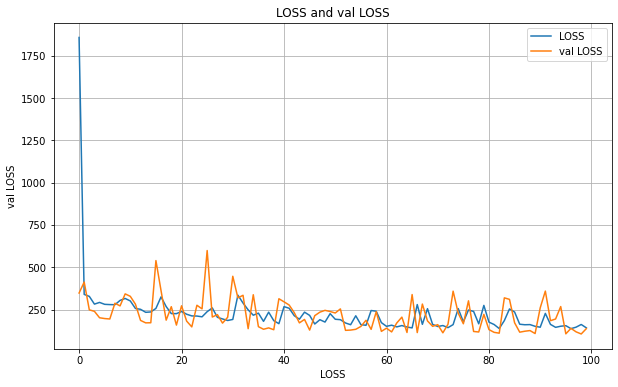

6/6 [==============================] - 0s 20ms/step


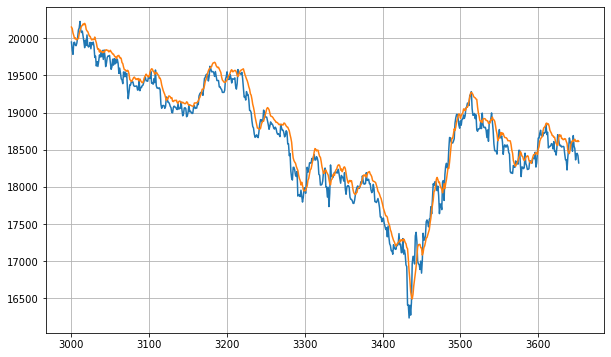

{'mae': 136.4571, 'mse': 29081.36, 'rmse': 170.53258, 'mape': 0.7398956, 'mase': 2.0840898}
Model: "1_model_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     18/Unknown - 2s 16ms/step - loss: 3063.8115 - mae: 3062.7107

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 3s 73ms/step - loss: 2523.7573 - mae: 2522.6951 - val_loss: 578.0912 - val_mae: 577.2142
Epoch 2/100
18/24 [=====================>........] - ETA: 0s - loss: 399.1559 - mae: 398.3791

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 61ms/step - loss: 376.9109 - mae: 376.1612 - val_loss: 104.6308 - val_mae: 104.0103
Epoch 3/100
24/24 [==============================] - 1s 18ms/step - loss: 184.4274 - mae: 183.8924 - val_loss: 183.5124 - val_mae: 183.0637
Epoch 4/100
18/24 [=====================>........] - ETA: 0s - loss: 116.5393 - mae: 116.1339

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 90ms/step - loss: 110.7025 - mae: 110.3091 - val_loss: 70.5551 - val_mae: 70.2177
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 84.8339 - mae: 84.5335 - val_loss: 103.6683 - val_mae: 103.4050
Epoch 6/100
24/24 [==============================] - 1s 22ms/step - loss: 90.7432 - mae: 90.5042 - val_loss: 73.3119 - val_mae: 73.0967
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 85.2478 - mae: 85.0489 - val_loss: 101.4746 - val_mae: 101.2917
Epoch 8/100
24/24 [==============================] - 1s 23ms/step - loss: 92.4825 - mae: 92.3088 - val_loss: 102.4480 - val_mae: 102.2843
Epoch 9/100
24/24 [==============================] - 1s 21ms/step - loss: 118.0848 - mae: 117.9275 - val_loss: 127.0506 - val_mae: 126.8995
Epoch 10/100
24/24 [==============================] - 1s 21ms/step - loss: 108.0503 - mae: 107.9026 - val_loss: 105.0317 - val_mae: 104.8895
Epoch 11/100
24/24 [=======================

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 59ms/step - loss: 86.2883 - mae: 86.1578 - val_loss: 62.7560 - val_mae: 62.6251
Epoch 17/100
19/24 [======================>.......] - ETA: 0s - loss: 93.4750 - mae: 93.3454

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 63ms/step - loss: 100.9932 - mae: 100.8636 - val_loss: 59.8657 - val_mae: 59.7360
Epoch 18/100
24/24 [==============================] - 1s 18ms/step - loss: 107.5497 - mae: 107.4202 - val_loss: 64.8241 - val_mae: 64.6933
Epoch 19/100
24/24 [==============================] - 1s 18ms/step - loss: 101.9538 - mae: 101.8243 - val_loss: 61.4291 - val_mae: 61.3006
Epoch 20/100
24/24 [==============================] - 1s 18ms/step - loss: 80.0511 - mae: 79.9226 - val_loss: 80.0436 - val_mae: 79.9158
Epoch 21/100
24/24 [==============================] - 1s 18ms/step - loss: 86.3409 - mae: 86.2125 - val_loss: 121.1522 - val_mae: 121.0255
Epoch 22/100
24/24 [==============================] - 1s 18ms/step - loss: 121.1178 - mae: 120.9907 - val_loss: 136.6908 - val_mae: 136.5643
Epoch 23/100
18/24 [=====================>........] - ETA: 0s - loss: 117.9656 - mae: 117.8388

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 61ms/step - loss: 112.3483 - mae: 112.2212 - val_loss: 59.0993 - val_mae: 58.9718
Epoch 24/100
24/24 [==============================] - 1s 18ms/step - loss: 108.9720 - mae: 108.8447 - val_loss: 196.7222 - val_mae: 196.5964
Epoch 25/100
24/24 [==============================] - 1s 18ms/step - loss: 126.4060 - mae: 126.2801 - val_loss: 89.6478 - val_mae: 89.5220
Epoch 26/100
24/24 [==============================] - 1s 18ms/step - loss: 84.9429 - mae: 84.8168 - val_loss: 137.3168 - val_mae: 137.1915
Epoch 27/100
24/24 [==============================] - 1s 18ms/step - loss: 95.6674 - mae: 95.5409 - val_loss: 112.8009 - val_mae: 112.6745
Epoch 28/100
18/24 [=====================>........] - ETA: 0s - loss: 107.6478 - mae: 107.5221

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 59ms/step - loss: 101.6721 - mae: 101.5464 - val_loss: 56.8636 - val_mae: 56.7377
Epoch 29/100
18/24 [=====================>........] - ETA: 0s - loss: 77.1414 - mae: 77.0157

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 61ms/step - loss: 90.2703 - mae: 90.1447 - val_loss: 55.2216 - val_mae: 55.0938
Epoch 30/100
24/24 [==============================] - 1s 18ms/step - loss: 71.9862 - mae: 71.8600 - val_loss: 56.5178 - val_mae: 56.3921
Epoch 31/100
18/24 [=====================>........] - ETA: 0s - loss: 65.3441 - mae: 65.2186

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 60ms/step - loss: 68.5066 - mae: 68.3816 - val_loss: 54.6671 - val_mae: 54.5430
Epoch 32/100
24/24 [==============================] - 1s 18ms/step - loss: 68.2425 - mae: 68.1177 - val_loss: 67.9569 - val_mae: 67.8320
Epoch 33/100
24/24 [==============================] - 1s 18ms/step - loss: 76.6439 - mae: 76.5190 - val_loss: 110.1144 - val_mae: 109.9910
Epoch 34/100
18/24 [=====================>........] - ETA: 0s - loss: 71.6477 - mae: 71.5235

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 70ms/step - loss: 71.4654 - mae: 71.3413 - val_loss: 54.3901 - val_mae: 54.2640
Epoch 35/100
24/24 [==============================] - 1s 21ms/step - loss: 67.1328 - mae: 67.0084 - val_loss: 86.7623 - val_mae: 86.6385
Epoch 36/100
24/24 [==============================] - 1s 21ms/step - loss: 69.5763 - mae: 69.4524 - val_loss: 165.3752 - val_mae: 165.2522
Epoch 37/100
24/24 [==============================] - 1s 21ms/step - loss: 87.6452 - mae: 87.5222 - val_loss: 70.1205 - val_mae: 69.9961
Epoch 38/100
24/24 [==============================] - 1s 21ms/step - loss: 122.8081 - mae: 122.6856 - val_loss: 79.9751 - val_mae: 79.8521
Epoch 39/100
15/24 [=================>............] - ETA: 0s - loss: 73.4287 - mae: 73.3057

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 73ms/step - loss: 69.5885 - mae: 69.4658 - val_loss: 51.6724 - val_mae: 51.5503
Epoch 40/100
24/24 [==============================] - 1s 18ms/step - loss: 114.4351 - mae: 114.3132 - val_loss: 54.3809 - val_mae: 54.2573
Epoch 41/100
24/24 [==============================] - 1s 18ms/step - loss: 67.9246 - mae: 67.8022 - val_loss: 75.8295 - val_mae: 75.7075
Epoch 42/100
24/24 [==============================] - 1s 18ms/step - loss: 84.3516 - mae: 84.2296 - val_loss: 181.2372 - val_mae: 181.1165
Epoch 43/100
24/24 [==============================] - 1s 18ms/step - loss: 149.9186 - mae: 149.7973 - val_loss: 129.9808 - val_mae: 129.8602
Epoch 44/100
24/24 [==============================] - 1s 18ms/step - loss: 111.0853 - mae: 110.9641 - val_loss: 105.2444 - val_mae: 105.1231
Epoch 45/100
24/24 [==============================] - 1s 21ms/step - loss: 85.8135 - mae: 85.6916 - val_loss: 94.8780 - val_mae: 94.7563
Epoch 46/100
24/24 [======================

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 62ms/step - loss: 95.7801 - mae: 95.6572 - val_loss: 51.3647 - val_mae: 51.2404
Epoch 51/100
18/24 [=====================>........] - ETA: 0s - loss: 60.9803 - mae: 60.8561

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 62ms/step - loss: 62.4332 - mae: 62.3087 - val_loss: 50.4109 - val_mae: 50.2865
Epoch 52/100
24/24 [==============================] - 1s 18ms/step - loss: 67.4583 - mae: 67.3336 - val_loss: 52.7781 - val_mae: 52.6543
Epoch 53/100
24/24 [==============================] - 1s 18ms/step - loss: 110.7389 - mae: 110.6154 - val_loss: 53.8154 - val_mae: 53.6900
Epoch 54/100
24/24 [==============================] - 1s 19ms/step - loss: 108.6356 - mae: 108.5123 - val_loss: 55.0211 - val_mae: 54.8961
Epoch 55/100
24/24 [==============================] - 1s 18ms/step - loss: 68.4454 - mae: 68.3212 - val_loss: 55.5097 - val_mae: 55.3847
Epoch 56/100
17/24 [====================>.........] - ETA: 0s - loss: 62.8723 - mae: 62.7482

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 73ms/step - loss: 65.3293 - mae: 65.2050 - val_loss: 48.9080 - val_mae: 48.7830
Epoch 57/100
24/24 [==============================] - 1s 21ms/step - loss: 57.8780 - mae: 57.7534 - val_loss: 57.8230 - val_mae: 57.6973
Epoch 58/100
24/24 [==============================] - 1s 18ms/step - loss: 63.3945 - mae: 63.2703 - val_loss: 49.3039 - val_mae: 49.1778
Epoch 59/100
24/24 [==============================] - 1s 18ms/step - loss: 62.2368 - mae: 62.1121 - val_loss: 68.1118 - val_mae: 67.9883
Epoch 60/100
24/24 [==============================] - 1s 18ms/step - loss: 108.0116 - mae: 107.8884 - val_loss: 139.3533 - val_mae: 139.2305
Epoch 61/100
17/24 [====================>.........] - ETA: 0s - loss: 114.6655 - mae: 114.5422

INFO:tensorflow:Assets written to: saved_model/5\assets


INFO:tensorflow:Assets written to: saved_model/5\assets


24/24 [==============================] - 2s 60ms/step - loss: 103.4501 - mae: 103.3269 - val_loss: 48.4115 - val_mae: 48.2852
Epoch 62/100
24/24 [==============================] - 1s 18ms/step - loss: 68.6095 - mae: 68.4851 - val_loss: 177.6017 - val_mae: 177.4800
Epoch 63/100
24/24 [==============================] - 1s 18ms/step - loss: 173.8625 - mae: 173.7409 - val_loss: 131.0409 - val_mae: 130.9198
Epoch 64/100
24/24 [==============================] - 1s 18ms/step - loss: 77.9614 - mae: 77.8390 - val_loss: 48.5088 - val_mae: 48.3858
Epoch 65/100
24/24 [==============================] - 1s 18ms/step - loss: 59.5528 - mae: 59.4296 - val_loss: 108.5676 - val_mae: 108.4462
Epoch 66/100
24/24 [==============================] - 1s 18ms/step - loss: 104.3054 - mae: 104.1848 - val_loss: 149.2971 - val_mae: 149.1769
Epoch 67/100
24/24 [==============================] - 1s 18ms/step - loss: 103.9851 - mae: 103.8647 - val_loss: 69.8329 - val_mae: 69.7118
Epoch 68/100
24/24 [==================

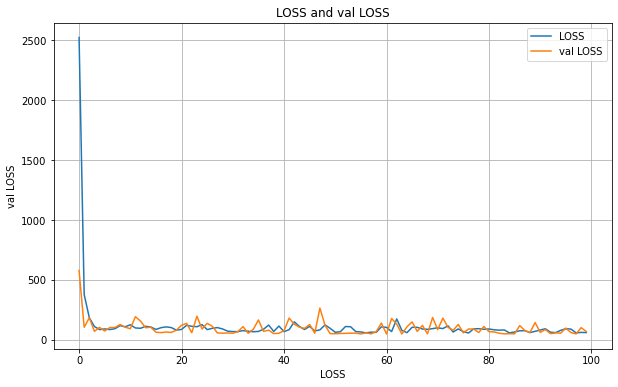

6/6 [==============================] - 0s 20ms/step


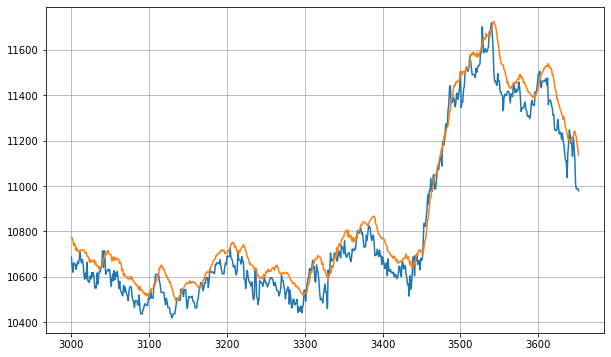

{'mae': 68.34033, 'mse': 6725.102, 'rmse': 82.00672, 'mape': 0.63156074, 'mase': 2.8937483}
Model: "1_model_AUD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     18/Unknown - 2s 17ms/step - loss: 3009.4192 - mae: 3008.2805

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 3s 72ms/step - loss: 2413.4480 - mae: 2412.3445 - val_loss: 376.0170 - val_mae: 375.0799
Epoch 2/100
18/24 [=====================>........] - ETA: 0s - loss: 203.6338 - mae: 202.7867

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 61ms/step - loss: 191.3834 - mae: 190.5607 - val_loss: 153.4020 - val_mae: 152.6959
Epoch 3/100
18/24 [=====================>........] - ETA: 0s - loss: 135.7481 - mae: 135.1030

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 60ms/step - loss: 133.8815 - mae: 133.2528 - val_loss: 137.6800 - val_mae: 137.1300
Epoch 4/100
18/24 [=====================>........] - ETA: 0s - loss: 128.1322 - mae: 127.6224

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 61ms/step - loss: 125.1897 - mae: 124.6905 - val_loss: 134.7449 - val_mae: 134.2966
Epoch 5/100
24/24 [==============================] - 1s 18ms/step - loss: 149.1509 - mae: 148.7375 - val_loss: 233.0893 - val_mae: 232.7106
Epoch 6/100
24/24 [==============================] - 1s 18ms/step - loss: 150.7905 - mae: 150.4335 - val_loss: 145.4881 - val_mae: 145.1523
Epoch 7/100
24/24 [==============================] - 1s 18ms/step - loss: 145.7091 - mae: 145.3886 - val_loss: 136.7081 - val_mae: 136.4020
Epoch 8/100
24/24 [==============================] - 1s 18ms/step - loss: 159.3157 - mae: 159.0184 - val_loss: 156.8970 - val_mae: 156.6076
Epoch 9/100
18/24 [=====================>........] - ETA: 0s - loss: 133.6334 - mae: 133.3484

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 59ms/step - loss: 129.2735 - mae: 128.9899 - val_loss: 123.3387 - val_mae: 123.0607
Epoch 10/100
24/24 [==============================] - 1s 18ms/step - loss: 120.6864 - mae: 120.4111 - val_loss: 180.1638 - val_mae: 179.8927
Epoch 11/100
24/24 [==============================] - 1s 18ms/step - loss: 155.0824 - mae: 154.8130 - val_loss: 194.8605 - val_mae: 194.5936
Epoch 12/100
24/24 [==============================] - 1s 18ms/step - loss: 180.0630 - mae: 179.7973 - val_loss: 171.6888 - val_mae: 171.4244
Epoch 13/100
18/24 [=====================>........] - ETA: 0s - loss: 143.3738 - mae: 143.1104

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 75ms/step - loss: 136.9190 - mae: 136.6556 - val_loss: 117.5603 - val_mae: 117.2985
Epoch 14/100
24/24 [==============================] - 1s 18ms/step - loss: 108.8948 - mae: 108.6319 - val_loss: 124.2650 - val_mae: 124.0025
Epoch 15/100
24/24 [==============================] - 1s 18ms/step - loss: 122.4849 - mae: 122.2234 - val_loss: 137.4349 - val_mae: 137.1739
Epoch 16/100
24/24 [==============================] - 1s 19ms/step - loss: 136.9913 - mae: 136.7309 - val_loss: 159.3474 - val_mae: 159.0862
Epoch 17/100
17/24 [====================>.........] - ETA: 0s - loss: 109.4545 - mae: 109.1930

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 62ms/step - loss: 106.6245 - mae: 106.3634 - val_loss: 109.7792 - val_mae: 109.5187
Epoch 18/100
18/24 [=====================>........] - ETA: 0s - loss: 110.7857 - mae: 110.5251

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 60ms/step - loss: 111.6323 - mae: 111.3716 - val_loss: 102.6334 - val_mae: 102.3730
Epoch 19/100
24/24 [==============================] - 1s 18ms/step - loss: 128.5323 - mae: 128.2719 - val_loss: 105.1834 - val_mae: 104.9234
Epoch 20/100
24/24 [==============================] - 1s 18ms/step - loss: 127.0584 - mae: 126.7985 - val_loss: 168.4597 - val_mae: 168.1996
Epoch 21/100
24/24 [==============================] - 1s 18ms/step - loss: 139.8436 - mae: 139.5841 - val_loss: 130.8609 - val_mae: 130.6018
Epoch 22/100
18/24 [=====================>........] - ETA: 0s - loss: 127.2564 - mae: 126.9968

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 60ms/step - loss: 131.5254 - mae: 131.2658 - val_loss: 98.8195 - val_mae: 98.5596
Epoch 23/100
24/24 [==============================] - 1s 18ms/step - loss: 139.5388 - mae: 139.2793 - val_loss: 118.1723 - val_mae: 117.9136
Epoch 24/100
18/24 [=====================>........] - ETA: 0s - loss: 130.1838 - mae: 129.9251

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 60ms/step - loss: 128.7691 - mae: 128.5105 - val_loss: 97.6088 - val_mae: 97.3484
Epoch 25/100
24/24 [==============================] - 1s 18ms/step - loss: 96.1754 - mae: 95.9157 - val_loss: 118.9420 - val_mae: 118.6823
Epoch 26/100
18/24 [=====================>........] - ETA: 0s - loss: 95.4048 - mae: 95.1460 

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 61ms/step - loss: 93.4483 - mae: 93.1892 - val_loss: 95.0518 - val_mae: 94.7930
Epoch 27/100
18/24 [=====================>........] - ETA: 0s - loss: 87.8120 - mae: 87.5523

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 60ms/step - loss: 88.0945 - mae: 87.8347 - val_loss: 94.7607 - val_mae: 94.5019
Epoch 28/100
24/24 [==============================] - 1s 18ms/step - loss: 95.3062 - mae: 95.0469 - val_loss: 117.2088 - val_mae: 116.9482
Epoch 29/100
24/24 [==============================] - 1s 18ms/step - loss: 101.1413 - mae: 100.8816 - val_loss: 101.7839 - val_mae: 101.5251
Epoch 30/100
24/24 [==============================] - 1s 18ms/step - loss: 94.9240 - mae: 94.6648 - val_loss: 101.2569 - val_mae: 100.9969
Epoch 31/100
24/24 [==============================] - 1s 23ms/step - loss: 134.3190 - mae: 134.0605 - val_loss: 96.1979 - val_mae: 95.9395
Epoch 32/100
20/24 [========================>.....] - ETA: 0s - loss: 89.1602 - mae: 88.9014

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 91ms/step - loss: 89.0964 - mae: 88.8375 - val_loss: 85.8544 - val_mae: 85.5961
Epoch 33/100
24/24 [==============================] - 1s 19ms/step - loss: 98.9546 - mae: 98.6955 - val_loss: 152.5880 - val_mae: 152.3302
Epoch 34/100
24/24 [==============================] - 1s 21ms/step - loss: 158.1185 - mae: 157.8607 - val_loss: 173.6106 - val_mae: 173.3533
Epoch 35/100
24/24 [==============================] - 1s 19ms/step - loss: 111.3008 - mae: 111.0427 - val_loss: 162.5260 - val_mae: 162.2686
Epoch 36/100
24/24 [==============================] - 1s 19ms/step - loss: 127.3531 - mae: 127.0959 - val_loss: 97.3388 - val_mae: 97.0789
Epoch 37/100
24/24 [==============================] - 1s 19ms/step - loss: 84.2404 - mae: 83.9818 - val_loss: 89.2110 - val_mae: 88.9527
Epoch 38/100
24/24 [==============================] - 1s 19ms/step - loss: 86.7034 - mae: 86.4447 - val_loss: 93.3736 - val_mae: 93.1140
Epoch 39/100
24/24 [======================

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 66ms/step - loss: 87.2367 - mae: 86.9785 - val_loss: 85.7665 - val_mae: 85.5084
Epoch 41/100
18/24 [=====================>........] - ETA: 0s - loss: 91.2957 - mae: 91.0371

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 65ms/step - loss: 90.0576 - mae: 89.7992 - val_loss: 80.3702 - val_mae: 80.1120
Epoch 42/100
24/24 [==============================] - 1s 21ms/step - loss: 119.8470 - mae: 119.5896 - val_loss: 96.8954 - val_mae: 96.6386
Epoch 43/100
24/24 [==============================] - 1s 20ms/step - loss: 87.6414 - mae: 87.3839 - val_loss: 118.1593 - val_mae: 117.9025
Epoch 44/100
24/24 [==============================] - 1s 21ms/step - loss: 117.2031 - mae: 116.9455 - val_loss: 110.0828 - val_mae: 109.8244
Epoch 45/100
24/24 [==============================] - 1s 22ms/step - loss: 84.3850 - mae: 84.1268 - val_loss: 102.8750 - val_mae: 102.6173
Epoch 46/100
24/24 [==============================] - 1s 21ms/step - loss: 83.6393 - mae: 83.3806 - val_loss: 104.3468 - val_mae: 104.0881
Epoch 47/100
24/24 [==============================] - 1s 21ms/step - loss: 83.8827 - mae: 83.6229 - val_loss: 181.8226 - val_mae: 181.5634
Epoch 48/100
16/24 [===================>

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 67ms/step - loss: 88.1279 - mae: 87.8677 - val_loss: 79.6567 - val_mae: 79.3974
Epoch 49/100
16/24 [===================>..........] - ETA: 0s - loss: 74.2083 - mae: 73.9475

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 67ms/step - loss: 74.5307 - mae: 74.2699 - val_loss: 79.4184 - val_mae: 79.1558
Epoch 50/100
24/24 [==============================] - 1s 20ms/step - loss: 78.0408 - mae: 77.7803 - val_loss: 86.9828 - val_mae: 86.7223
Epoch 51/100
16/24 [===================>..........] - ETA: 0s - loss: 89.7639 - mae: 89.5034

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 72ms/step - loss: 86.8004 - mae: 86.5398 - val_loss: 77.5876 - val_mae: 77.3268
Epoch 52/100
24/24 [==============================] - 2s 35ms/step - loss: 81.2808 - mae: 81.0195 - val_loss: 194.5115 - val_mae: 194.2516
Epoch 53/100
24/24 [==============================] - 1s 20ms/step - loss: 139.6285 - mae: 139.3680 - val_loss: 77.7593 - val_mae: 77.4993
Epoch 54/100
24/24 [==============================] - 1s 20ms/step - loss: 84.9638 - mae: 84.7027 - val_loss: 118.2199 - val_mae: 117.9589
Epoch 55/100
24/24 [==============================] - 1s 20ms/step - loss: 130.9724 - mae: 130.7116 - val_loss: 80.2398 - val_mae: 79.9774
Epoch 56/100
24/24 [==============================] - 1s 20ms/step - loss: 86.1347 - mae: 85.8716 - val_loss: 85.7306 - val_mae: 85.4664
Epoch 57/100
24/24 [==============================] - 1s 20ms/step - loss: 105.4585 - mae: 105.1955 - val_loss: 153.1227 - val_mae: 152.8603
Epoch 58/100
24/24 [======================

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 91ms/step - loss: 111.3943 - mae: 111.1305 - val_loss: 77.0635 - val_mae: 76.8001
Epoch 62/100
24/24 [==============================] - 1s 18ms/step - loss: 79.2116 - mae: 78.9481 - val_loss: 79.2465 - val_mae: 78.9823
Epoch 63/100
24/24 [==============================] - 1s 18ms/step - loss: 89.6471 - mae: 89.3841 - val_loss: 175.9384 - val_mae: 175.6768
Epoch 64/100
24/24 [==============================] - 1s 18ms/step - loss: 118.0969 - mae: 117.8349 - val_loss: 101.0113 - val_mae: 100.7491
Epoch 65/100
24/24 [==============================] - 1s 19ms/step - loss: 115.6411 - mae: 115.3800 - val_loss: 83.5559 - val_mae: 83.2939
Epoch 66/100
24/24 [==============================] - 1s 19ms/step - loss: 91.2348 - mae: 90.9737 - val_loss: 141.1018 - val_mae: 140.8417
Epoch 67/100
24/24 [==============================] - 1s 18ms/step - loss: 85.2213 - mae: 84.9597 - val_loss: 78.1045 - val_mae: 77.8446
Epoch 68/100
24/24 [======================

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 61ms/step - loss: 78.4611 - mae: 78.1999 - val_loss: 76.3909 - val_mae: 76.1308
Epoch 70/100
24/24 [==============================] - 1s 18ms/step - loss: 74.1636 - mae: 73.9018 - val_loss: 87.0497 - val_mae: 86.7878
Epoch 71/100
24/24 [==============================] - 1s 18ms/step - loss: 71.9267 - mae: 71.6650 - val_loss: 122.1464 - val_mae: 121.8868
Epoch 72/100
24/24 [==============================] - 1s 18ms/step - loss: 106.9820 - mae: 106.7216 - val_loss: 99.4955 - val_mae: 99.2362
Epoch 73/100
17/24 [====================>.........] - ETA: 0s - loss: 81.4816 - mae: 81.2217

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 61ms/step - loss: 79.8065 - mae: 79.5461 - val_loss: 75.7932 - val_mae: 75.5337
Epoch 74/100
24/24 [==============================] - 1s 19ms/step - loss: 70.4968 - mae: 70.2369 - val_loss: 92.0913 - val_mae: 91.8304
Epoch 75/100
24/24 [==============================] - 1s 18ms/step - loss: 83.4538 - mae: 83.1938 - val_loss: 144.9959 - val_mae: 144.7370
Epoch 76/100
18/24 [=====================>........] - ETA: 0s - loss: 92.1369 - mae: 91.8777  

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 61ms/step - loss: 87.3467 - mae: 87.0873 - val_loss: 73.1580 - val_mae: 72.8979
Epoch 77/100
24/24 [==============================] - 1s 18ms/step - loss: 71.7105 - mae: 71.4511 - val_loss: 79.4246 - val_mae: 79.1640
Epoch 78/100
24/24 [==============================] - 1s 19ms/step - loss: 71.6602 - mae: 71.4005 - val_loss: 73.3629 - val_mae: 73.1029
Epoch 79/100
24/24 [==============================] - 1s 18ms/step - loss: 141.2215 - mae: 140.9633 - val_loss: 290.5378 - val_mae: 290.2803
Epoch 80/100
24/24 [==============================] - 1s 19ms/step - loss: 168.3243 - mae: 168.0662 - val_loss: 168.0584 - val_mae: 167.8005
Epoch 81/100
24/24 [==============================] - 1s 18ms/step - loss: 115.7011 - mae: 115.4429 - val_loss: 134.5676 - val_mae: 134.3093
Epoch 82/100
24/24 [==============================] - 1s 18ms/step - loss: 110.5448 - mae: 110.2863 - val_loss: 140.6096 - val_mae: 140.3521
Epoch 83/100
24/24 [==================

INFO:tensorflow:Assets written to: saved_model/6\assets


INFO:tensorflow:Assets written to: saved_model/6\assets


24/24 [==============================] - 2s 61ms/step - loss: 76.1957 - mae: 75.9389 - val_loss: 72.9347 - val_mae: 72.6786
Epoch 95/100
24/24 [==============================] - 1s 18ms/step - loss: 69.8406 - mae: 69.5841 - val_loss: 73.4405 - val_mae: 73.1854
Epoch 96/100
24/24 [==============================] - 1s 18ms/step - loss: 75.5021 - mae: 75.2458 - val_loss: 81.7085 - val_mae: 81.4521
Epoch 97/100
24/24 [==============================] - 1s 18ms/step - loss: 73.5629 - mae: 73.3063 - val_loss: 75.6683 - val_mae: 75.4126
Epoch 98/100
24/24 [==============================] - 1s 18ms/step - loss: 70.8258 - mae: 70.5694 - val_loss: 107.6061 - val_mae: 107.3508
Epoch 99/100
24/24 [==============================] - 1s 18ms/step - loss: 97.6448 - mae: 97.3895 - val_loss: 78.5055 - val_mae: 78.2502
Epoch 100/100
5/5 [==============================] - 0s 10ms/step - loss: 117.9701 - mae: 117.7162


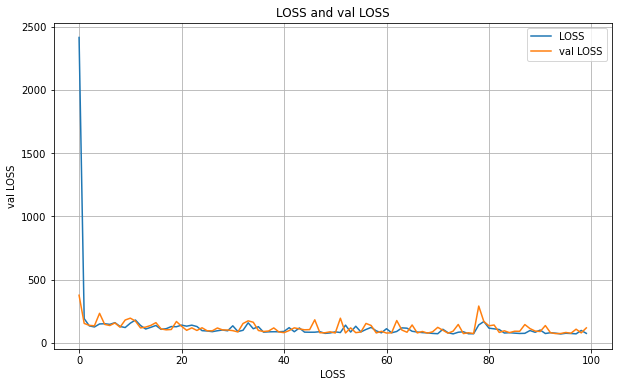

6/6 [==============================] - 0s 20ms/step


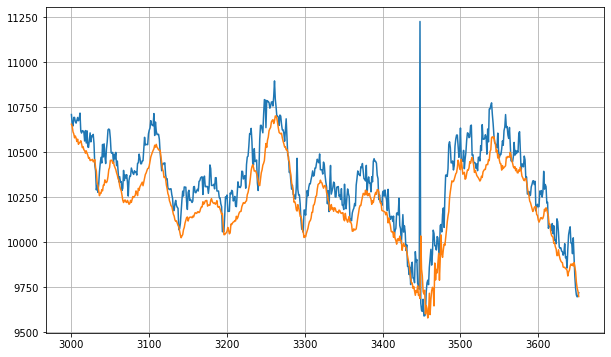

{'mae': 116.651825, 'mse': 22088.676, 'rmse': 148.62259, 'mape': 1.1235882, 'mase': 2.4722307}
Model: "1_model_CNY"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     18/Unknown - 1s 16ms/step - loss: 525.8514 - mae: 524.7046

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 3s 81ms/step - loss: 441.6393 - mae: 440.5299 - val_loss: 103.6222 - val_mae: 102.6927
Epoch 2/100
18/24 [=====================>........] - ETA: 0s - loss: 59.1467 - mae: 58.3129

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 61ms/step - loss: 52.5968 - mae: 51.7891 - val_loss: 21.0320 - val_mae: 20.3475
Epoch 3/100
18/24 [=====================>........] - ETA: 0s - loss: 20.2815 - mae: 19.6588

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 61ms/step - loss: 20.2685 - mae: 19.6627 - val_loss: 15.7937 - val_mae: 15.2703
Epoch 4/100
24/24 [==============================] - 1s 18ms/step - loss: 18.8019 - mae: 18.3312 - val_loss: 25.7577 - val_mae: 25.3455
Epoch 5/100
24/24 [==============================] - 1s 19ms/step - loss: 29.8277 - mae: 29.4523 - val_loss: 35.0206 - val_mae: 34.6818
Epoch 6/100
17/24 [====================>.........] - ETA: 0s - loss: 25.9262 - mae: 25.6021

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 60ms/step - loss: 23.7399 - mae: 23.4206 - val_loss: 14.3806 - val_mae: 14.0804
Epoch 7/100
24/24 [==============================] - 1s 18ms/step - loss: 16.9741 - mae: 16.6869 - val_loss: 24.8349 - val_mae: 24.5705
Epoch 8/100
24/24 [==============================] - 1s 18ms/step - loss: 18.3702 - mae: 18.1109 - val_loss: 24.2673 - val_mae: 24.0213
Epoch 9/100
24/24 [==============================] - 1s 18ms/step - loss: 20.5721 - mae: 20.3308 - val_loss: 46.6781 - val_mae: 46.4469
Epoch 10/100
24/24 [==============================] - 1s 18ms/step - loss: 27.4503 - mae: 27.2203 - val_loss: 18.8316 - val_mae: 18.6032
Epoch 11/100
18/24 [=====================>........] - ETA: 0s - loss: 16.9008 - mae: 16.6728

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 61ms/step - loss: 17.1407 - mae: 16.9126 - val_loss: 12.6995 - val_mae: 12.4724
Epoch 12/100
24/24 [==============================] - 1s 18ms/step - loss: 17.0822 - mae: 16.8572 - val_loss: 15.1461 - val_mae: 14.9265
Epoch 13/100
24/24 [==============================] - 1s 18ms/step - loss: 27.7175 - mae: 27.5003 - val_loss: 43.6089 - val_mae: 43.3961
Epoch 14/100
24/24 [==============================] - 1s 18ms/step - loss: 31.2336 - mae: 31.0207 - val_loss: 28.3222 - val_mae: 28.1099
Epoch 15/100
24/24 [==============================] - 1s 18ms/step - loss: 29.0997 - mae: 28.8876 - val_loss: 24.6963 - val_mae: 24.4822
Epoch 16/100
24/24 [==============================] - 1s 18ms/step - loss: 26.6588 - mae: 26.4479 - val_loss: 36.3389 - val_mae: 36.1295
Epoch 17/100
24/24 [==============================] - 1s 18ms/step - loss: 27.6870 - mae: 27.4755 - val_loss: 19.4353 - val_mae: 19.2261
Epoch 18/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 61ms/step - loss: 21.4715 - mae: 21.2602 - val_loss: 12.1381 - val_mae: 11.9237
Epoch 22/100
24/24 [==============================] - 1s 18ms/step - loss: 14.6476 - mae: 14.4334 - val_loss: 14.6470 - val_mae: 14.4382
Epoch 23/100
24/24 [==============================] - 1s 18ms/step - loss: 17.5081 - mae: 17.2985 - val_loss: 26.5891 - val_mae: 26.3833
Epoch 24/100
24/24 [==============================] - 1s 18ms/step - loss: 26.7189 - mae: 26.5120 - val_loss: 15.9324 - val_mae: 15.7241
Epoch 25/100
24/24 [==============================] - 1s 18ms/step - loss: 20.9686 - mae: 20.7593 - val_loss: 12.7224 - val_mae: 12.5104
Epoch 26/100
24/24 [==============================] - 1s 18ms/step - loss: 15.2572 - mae: 15.0454 - val_loss: 17.8510 - val_mae: 17.6417
Epoch 27/100
18/24 [=====================>........] - ETA: 0s - loss: 13.2993 - mae: 13.0874

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 61ms/step - loss: 13.6311 - mae: 13.4189 - val_loss: 11.9191 - val_mae: 11.7061
Epoch 28/100
24/24 [==============================] - 1s 18ms/step - loss: 14.0190 - mae: 13.8075 - val_loss: 20.8771 - val_mae: 20.6701
Epoch 29/100
24/24 [==============================] - 1s 18ms/step - loss: 28.4596 - mae: 28.2564 - val_loss: 29.8172 - val_mae: 29.6157
Epoch 30/100
24/24 [==============================] - 1s 18ms/step - loss: 25.6391 - mae: 25.4367 - val_loss: 33.6830 - val_mae: 33.4808
Epoch 31/100
24/24 [==============================] - 1s 21ms/step - loss: 24.7942 - mae: 24.5914 - val_loss: 29.9645 - val_mae: 29.7641
Epoch 32/100
24/24 [==============================] - 1s 18ms/step - loss: 23.9364 - mae: 23.7347 - val_loss: 25.9276 - val_mae: 25.7266
Epoch 33/100
24/24 [==============================] - 1s 18ms/step - loss: 22.7772 - mae: 22.5737 - val_loss: 30.2189 - val_mae: 30.0194
Epoch 34/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 69ms/step - loss: 18.2724 - mae: 18.0700 - val_loss: 11.7669 - val_mae: 11.5606
Epoch 43/100
24/24 [==============================] - 1s 18ms/step - loss: 19.5945 - mae: 19.3934 - val_loss: 27.7506 - val_mae: 27.5538
Epoch 44/100
24/24 [==============================] - 1s 18ms/step - loss: 25.5754 - mae: 25.3776 - val_loss: 13.3648 - val_mae: 13.1623
Epoch 45/100
24/24 [==============================] - 1s 18ms/step - loss: 14.0221 - mae: 13.8156 - val_loss: 15.9287 - val_mae: 15.7272
Epoch 46/100
24/24 [==============================] - 1s 18ms/step - loss: 18.2420 - mae: 18.0372 - val_loss: 12.5371 - val_mae: 12.3329
Epoch 47/100
24/24 [==============================] - 1s 18ms/step - loss: 15.0324 - mae: 14.8287 - val_loss: 12.4643 - val_mae: 12.2593
Epoch 48/100
24/24 [==============================] - 1s 18ms/step - loss: 18.4316 - mae: 18.2308 - val_loss: 20.4151 - val_mae: 20.2158
Epoch 49/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 61ms/step - loss: 19.4919 - mae: 19.2906 - val_loss: 11.0244 - val_mae: 10.8157
Epoch 51/100
24/24 [==============================] - 1s 18ms/step - loss: 12.8051 - mae: 12.5974 - val_loss: 18.4947 - val_mae: 18.2943
Epoch 52/100
24/24 [==============================] - 1s 18ms/step - loss: 22.6525 - mae: 22.4527 - val_loss: 11.8705 - val_mae: 11.6656
Epoch 53/100
24/24 [==============================] - 1s 18ms/step - loss: 13.4647 - mae: 13.2588 - val_loss: 27.4092 - val_mae: 27.2132
Epoch 54/100
24/24 [==============================] - 1s 18ms/step - loss: 19.7999 - mae: 19.5990 - val_loss: 11.1053 - val_mae: 10.8976
Epoch 55/100
24/24 [==============================] - 1s 18ms/step - loss: 18.1405 - mae: 17.9391 - val_loss: 23.3302 - val_mae: 23.1324
Epoch 56/100
18/24 [=====================>........] - ETA: 0s - loss: 21.8755 - mae: 21.6758

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 60ms/step - loss: 23.3115 - mae: 23.1116 - val_loss: 10.9336 - val_mae: 10.7284
Epoch 57/100
24/24 [==============================] - 1s 20ms/step - loss: 21.6173 - mae: 21.4173 - val_loss: 20.6059 - val_mae: 20.4076
Epoch 58/100
24/24 [==============================] - 1s 20ms/step - loss: 21.7833 - mae: 21.5852 - val_loss: 20.6088 - val_mae: 20.4103
Epoch 59/100
24/24 [==============================] - 1s 18ms/step - loss: 19.1710 - mae: 18.9718 - val_loss: 19.5459 - val_mae: 19.3462
Epoch 60/100
24/24 [==============================] - 1s 18ms/step - loss: 20.4717 - mae: 20.2730 - val_loss: 17.3580 - val_mae: 17.1580
Epoch 61/100
24/24 [==============================] - 1s 18ms/step - loss: 19.8405 - mae: 19.6405 - val_loss: 16.6828 - val_mae: 16.4809
Epoch 62/100
24/24 [==============================] - 1s 18ms/step - loss: 19.8628 - mae: 19.6632 - val_loss: 18.0304 - val_mae: 17.8299
Epoch 63/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 60ms/step - loss: 16.9238 - mae: 16.7265 - val_loss: 10.5636 - val_mae: 10.3622
Epoch 78/100
24/24 [==============================] - 1s 18ms/step - loss: 13.4125 - mae: 13.2144 - val_loss: 20.9209 - val_mae: 20.7295
Epoch 79/100
24/24 [==============================] - 1s 18ms/step - loss: 19.7763 - mae: 19.5833 - val_loss: 17.3948 - val_mae: 17.2012
Epoch 80/100
24/24 [==============================] - 1s 18ms/step - loss: 20.2695 - mae: 20.0783 - val_loss: 19.6972 - val_mae: 19.5044
Epoch 81/100
24/24 [==============================] - 1s 18ms/step - loss: 14.7201 - mae: 14.5250 - val_loss: 11.5834 - val_mae: 11.3867
Epoch 82/100
18/24 [=====================>........] - ETA: 0s - loss: 13.1464 - mae: 12.9512

INFO:tensorflow:Assets written to: saved_model/7\assets


INFO:tensorflow:Assets written to: saved_model/7\assets


24/24 [==============================] - 2s 60ms/step - loss: 13.2017 - mae: 13.0059 - val_loss: 10.4095 - val_mae: 10.2106
Epoch 83/100
24/24 [==============================] - 1s 18ms/step - loss: 18.1463 - mae: 17.9538 - val_loss: 19.6445 - val_mae: 19.4537
Epoch 84/100
24/24 [==============================] - 1s 18ms/step - loss: 13.3331 - mae: 13.1374 - val_loss: 16.0813 - val_mae: 15.8897
Epoch 85/100
24/24 [==============================] - 1s 18ms/step - loss: 20.2172 - mae: 20.0282 - val_loss: 16.5099 - val_mae: 16.3162
Epoch 86/100
24/24 [==============================] - 1s 18ms/step - loss: 19.0963 - mae: 18.9048 - val_loss: 12.3940 - val_mae: 12.2006
Epoch 87/100
24/24 [==============================] - 1s 18ms/step - loss: 12.3548 - mae: 12.1586 - val_loss: 10.8643 - val_mae: 10.6665
Epoch 88/100
24/24 [==============================] - 1s 18ms/step - loss: 12.0003 - mae: 11.8048 - val_loss: 10.5771 - val_mae: 10.3838
Epoch 89/100
24/24 [==============================] - 

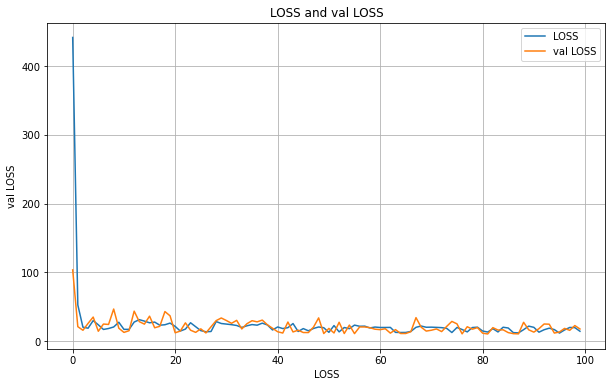

6/6 [==============================] - 0s 19ms/step


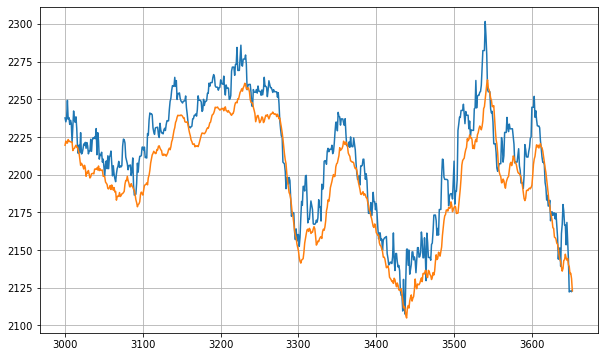

{'mae': 17.28356, 'mse': 418.08197, 'rmse': 20.447052, 'mape': 0.7793474, 'mase': 3.5223355}
Model: "1_model_CAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     18/Unknown - 1s 17ms/step - loss: 4201.9995 - mae: 4200.8623

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 3s 79ms/step - loss: 3397.9192 - mae: 3396.8213 - val_loss: 514.0758 - val_mae: 513.1663
Epoch 2/100
18/24 [=====================>........] - ETA: 0s - loss: 255.2475 - mae: 254.4380

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 62ms/step - loss: 231.5018 - mae: 230.7198 - val_loss: 109.7093 - val_mae: 109.0566
Epoch 3/100
24/24 [==============================] - 1s 18ms/step - loss: 143.1792 - mae: 142.6129 - val_loss: 166.1797 - val_mae: 165.6996
Epoch 4/100
24/24 [==============================] - 1s 18ms/step - loss: 133.6037 - mae: 133.1819 - val_loss: 116.4899 - val_mae: 116.1262
Epoch 5/100
18/24 [=====================>........] - ETA: 0s - loss: 130.6088 - mae: 130.2747

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 60ms/step - loss: 132.3149 - mae: 131.9886 - val_loss: 96.3282 - val_mae: 96.0386
Epoch 6/100
24/24 [==============================] - 1s 18ms/step - loss: 119.2654 - mae: 119.0009 - val_loss: 117.7934 - val_mae: 117.5532
Epoch 7/100
18/24 [=====================>........] - ETA: 0s - loss: 116.2052 - mae: 115.9783

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 60ms/step - loss: 117.1644 - mae: 116.9409 - val_loss: 95.8698 - val_mae: 95.6625
Epoch 8/100
24/24 [==============================] - 1s 18ms/step - loss: 118.4971 - mae: 118.2990 - val_loss: 209.8590 - val_mae: 209.6717
Epoch 9/100
18/24 [=====================>........] - ETA: 0s - loss: 151.6914 - mae: 151.5088

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 61ms/step - loss: 144.4425 - mae: 144.2612 - val_loss: 90.5956 - val_mae: 90.4196
Epoch 10/100
24/24 [==============================] - 1s 18ms/step - loss: 108.7424 - mae: 108.5708 - val_loss: 100.6381 - val_mae: 100.4700
Epoch 11/100
17/24 [====================>.........] - ETA: 0s - loss: 119.5296 - mae: 119.3638

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 60ms/step - loss: 116.8822 - mae: 116.7170 - val_loss: 83.4209 - val_mae: 83.2566
Epoch 12/100
24/24 [==============================] - 1s 18ms/step - loss: 148.1722 - mae: 148.0116 - val_loss: 124.6486 - val_mae: 124.4893
Epoch 13/100
24/24 [==============================] - 1s 18ms/step - loss: 113.3909 - mae: 113.2324 - val_loss: 127.3503 - val_mae: 127.1933
Epoch 14/100
24/24 [==============================] - 1s 18ms/step - loss: 121.4859 - mae: 121.3292 - val_loss: 142.8942 - val_mae: 142.7382
Epoch 15/100
24/24 [==============================] - 1s 18ms/step - loss: 123.3875 - mae: 123.2312 - val_loss: 179.8436 - val_mae: 179.6893
Epoch 16/100
24/24 [==============================] - 1s 18ms/step - loss: 145.5589 - mae: 145.4042 - val_loss: 328.7753 - val_mae: 328.6215
Epoch 17/100
24/24 [==============================] - 1s 18ms/step - loss: 182.7128 - mae: 182.5594 - val_loss: 121.9207 - val_mae: 121.7669
Epoch 18/100
18/24 [========

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 61ms/step - loss: 101.6580 - mae: 101.5040 - val_loss: 82.9986 - val_mae: 82.8446
Epoch 19/100
24/24 [==============================] - 1s 18ms/step - loss: 100.9423 - mae: 100.7890 - val_loss: 86.1949 - val_mae: 86.0424
Epoch 20/100
18/24 [=====================>........] - ETA: 0s - loss: 102.3369 - mae: 102.1837

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 70ms/step - loss: 100.5808 - mae: 100.4275 - val_loss: 72.7407 - val_mae: 72.5887
Epoch 21/100
24/24 [==============================] - 1s 21ms/step - loss: 123.6325 - mae: 123.4799 - val_loss: 97.5826 - val_mae: 97.4301
Epoch 22/100
24/24 [==============================] - 1s 18ms/step - loss: 134.7843 - mae: 134.6322 - val_loss: 153.1325 - val_mae: 152.9810
Epoch 23/100
24/24 [==============================] - 1s 18ms/step - loss: 107.5185 - mae: 107.3662 - val_loss: 74.8469 - val_mae: 74.6937
Epoch 24/100
24/24 [==============================] - 1s 18ms/step - loss: 96.3381 - mae: 96.1855 - val_loss: 78.7919 - val_mae: 78.6390
Epoch 25/100
24/24 [==============================] - 1s 18ms/step - loss: 113.9465 - mae: 113.7940 - val_loss: 252.6061 - val_mae: 252.4552
Epoch 26/100
24/24 [==============================] - 1s 18ms/step - loss: 110.8463 - mae: 110.6949 - val_loss: 116.7704 - val_mae: 116.6196
Epoch 27/100
24/24 [================

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 59ms/step - loss: 87.5792 - mae: 87.4276 - val_loss: 64.0704 - val_mae: 63.9186
Epoch 29/100
24/24 [==============================] - 1s 18ms/step - loss: 87.4167 - mae: 87.2656 - val_loss: 73.2870 - val_mae: 73.1356
Epoch 30/100
24/24 [==============================] - 1s 18ms/step - loss: 88.5775 - mae: 88.4267 - val_loss: 224.8167 - val_mae: 224.6672
Epoch 31/100
24/24 [==============================] - 1s 18ms/step - loss: 109.5333 - mae: 109.3824 - val_loss: 71.6311 - val_mae: 71.4805
Epoch 32/100
18/24 [=====================>........] - ETA: 0s - loss: 90.9064 - mae: 90.7556

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 60ms/step - loss: 89.9866 - mae: 89.8356 - val_loss: 63.8105 - val_mae: 63.6603
Epoch 33/100
24/24 [==============================] - 1s 18ms/step - loss: 79.0151 - mae: 78.8647 - val_loss: 115.8409 - val_mae: 115.6915
Epoch 34/100
24/24 [==============================] - 1s 18ms/step - loss: 132.6621 - mae: 132.5125 - val_loss: 181.1411 - val_mae: 180.9922
Epoch 35/100
24/24 [==============================] - 1s 18ms/step - loss: 120.4402 - mae: 120.2910 - val_loss: 152.8312 - val_mae: 152.6825
Epoch 36/100
24/24 [==============================] - 1s 18ms/step - loss: 120.3778 - mae: 120.2294 - val_loss: 155.7210 - val_mae: 155.5729
Epoch 37/100
24/24 [==============================] - 1s 18ms/step - loss: 110.6666 - mae: 110.5177 - val_loss: 211.7533 - val_mae: 211.6057
Epoch 38/100
24/24 [==============================] - 1s 18ms/step - loss: 112.9311 - mae: 112.7829 - val_loss: 80.6139 - val_mae: 80.4665
Epoch 39/100
18/24 [==============

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 60ms/step - loss: 87.4039 - mae: 87.2554 - val_loss: 59.8477 - val_mae: 59.6994
Epoch 40/100
24/24 [==============================] - 1s 18ms/step - loss: 84.9199 - mae: 84.7721 - val_loss: 149.3875 - val_mae: 149.2406
Epoch 41/100
24/24 [==============================] - 1s 18ms/step - loss: 100.9298 - mae: 100.7819 - val_loss: 76.8197 - val_mae: 76.6711
Epoch 42/100
24/24 [==============================] - 1s 18ms/step - loss: 83.4265 - mae: 83.2779 - val_loss: 83.7264 - val_mae: 83.5777
Epoch 43/100
24/24 [==============================] - 1s 18ms/step - loss: 95.1642 - mae: 95.0160 - val_loss: 153.9208 - val_mae: 153.7727
Epoch 44/100
24/24 [==============================] - 1s 18ms/step - loss: 117.1471 - mae: 116.9991 - val_loss: 193.3602 - val_mae: 193.2127
Epoch 45/100
24/24 [==============================] - 1s 18ms/step - loss: 93.6857 - mae: 93.5370 - val_loss: 114.1399 - val_mae: 113.9921
Epoch 46/100
24/24 [======================

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 60ms/step - loss: 88.2498 - mae: 88.0956 - val_loss: 57.3479 - val_mae: 57.1912
Epoch 61/100
24/24 [==============================] - 1s 18ms/step - loss: 116.4071 - mae: 116.2534 - val_loss: 81.1066 - val_mae: 80.9526
Epoch 62/100
24/24 [==============================] - 1s 18ms/step - loss: 102.5427 - mae: 102.3886 - val_loss: 75.3347 - val_mae: 75.1800
Epoch 63/100
24/24 [==============================] - 1s 18ms/step - loss: 110.9629 - mae: 110.8088 - val_loss: 114.4947 - val_mae: 114.3412
Epoch 64/100
17/24 [====================>.........] - ETA: 0s - loss: 86.8103 - mae: 86.6566

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 60ms/step - loss: 82.6527 - mae: 82.4993 - val_loss: 56.9004 - val_mae: 56.7459
Epoch 65/100
24/24 [==============================] - 1s 18ms/step - loss: 75.0574 - mae: 74.9024 - val_loss: 122.9240 - val_mae: 122.7713
Epoch 66/100
24/24 [==============================] - 1s 18ms/step - loss: 92.4272 - mae: 92.2732 - val_loss: 102.7657 - val_mae: 102.6130
Epoch 67/100
24/24 [==============================] - 1s 18ms/step - loss: 85.4651 - mae: 85.3119 - val_loss: 100.9595 - val_mae: 100.8053
Epoch 68/100
24/24 [==============================] - 1s 18ms/step - loss: 100.3718 - mae: 100.2191 - val_loss: 101.3940 - val_mae: 101.2417
Epoch 69/100
24/24 [==============================] - 1s 18ms/step - loss: 92.3098 - mae: 92.1574 - val_loss: 58.6272 - val_mae: 58.4724
Epoch 70/100
24/24 [==============================] - 1s 18ms/step - loss: 69.8734 - mae: 69.7207 - val_loss: 76.5378 - val_mae: 76.3862
Epoch 71/100
24/24 [========================

INFO:tensorflow:Assets written to: saved_model/8\assets


INFO:tensorflow:Assets written to: saved_model/8\assets


24/24 [==============================] - 2s 68ms/step - loss: 68.4245 - mae: 68.2753 - val_loss: 55.8514 - val_mae: 55.7042
Epoch 86/100
24/24 [==============================] - 1s 18ms/step - loss: 69.4623 - mae: 69.3138 - val_loss: 88.6148 - val_mae: 88.4667
Epoch 87/100
24/24 [==============================] - 1s 18ms/step - loss: 99.0040 - mae: 98.8567 - val_loss: 145.7020 - val_mae: 145.5554
Epoch 88/100
24/24 [==============================] - 1s 18ms/step - loss: 79.3057 - mae: 79.1580 - val_loss: 109.0905 - val_mae: 108.9436
Epoch 89/100
24/24 [==============================] - 1s 18ms/step - loss: 75.6958 - mae: 75.5486 - val_loss: 94.9455 - val_mae: 94.7993
Epoch 90/100
24/24 [==============================] - 1s 18ms/step - loss: 67.4255 - mae: 67.2785 - val_loss: 63.3500 - val_mae: 63.2031
Epoch 91/100
24/24 [==============================] - 1s 18ms/step - loss: 73.2095 - mae: 73.0625 - val_loss: 59.4094 - val_mae: 59.2622
Epoch 92/100
24/24 [==============================

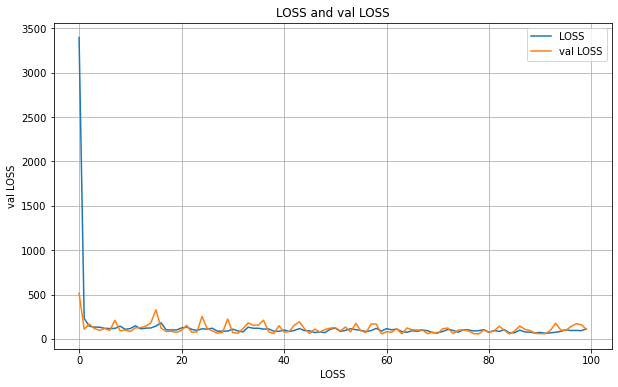

6/6 [==============================] - 0s 35ms/step


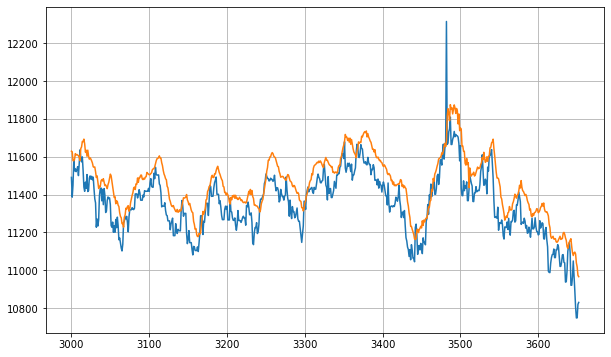

{'mae': 109.71976, 'mse': 16304.59, 'rmse': 127.68943, 'mape': 0.96906394, 'mase': 3.0552022}
Model: "1_model_MYR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     16/Unknown - 2s 21ms/step - loss: 1719.3975 - mae: 1718.2679

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 3s 80ms/step - loss: 1246.7239 - mae: 1245.6503 - val_loss: 31.8470 - val_mae: 30.9632
Epoch 2/100
15/24 [=================>............] - ETA: 0s - loss: 71.8360 - mae: 71.0398

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 71ms/step - loss: 61.2710 - mae: 60.5195 - val_loss: 25.1108 - val_mae: 24.4856
Epoch 3/100
24/24 [==============================] - 1s 24ms/step - loss: 35.3467 - mae: 34.8109 - val_loss: 34.9490 - val_mae: 34.5012
Epoch 4/100
24/24 [==============================] - 1s 23ms/step - loss: 33.3679 - mae: 32.9760 - val_loss: 26.0532 - val_mae: 25.7179
Epoch 5/100
23/24 [===========================>..] - ETA: 0s - loss: 35.0857 - mae: 34.7881

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 93ms/step - loss: 35.0653 - mae: 34.7681 - val_loss: 21.7696 - val_mae: 21.5061
Epoch 6/100
24/24 [==============================] - 1s 21ms/step - loss: 37.3299 - mae: 37.0962 - val_loss: 24.4400 - val_mae: 24.2283
Epoch 7/100
24/24 [==============================] - 1s 26ms/step - loss: 33.0041 - mae: 32.8092 - val_loss: 21.9440 - val_mae: 21.7635
Epoch 8/100
24/24 [==============================] - 2s 52ms/step - loss: 32.4710 - mae: 32.3023 - val_loss: 47.8308 - val_mae: 47.6756
Epoch 9/100
24/24 [==============================] - 2s 39ms/step - loss: 42.4189 - mae: 42.2677 - val_loss: 42.3197 - val_mae: 42.1768
Epoch 10/100
24/24 [==============================] - 1s 40ms/step - loss: 43.1553 - mae: 43.0159 - val_loss: 25.1198 - val_mae: 24.9802
Epoch 11/100
24/24 [==============================] - 1s 31ms/step - loss: 35.0057 - mae: 34.8720 - val_loss: 23.1960 - val_mae: 23.0648
Epoch 12/100
16/24 [===================>..........] - ETA:

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 4s 163ms/step - loss: 31.7327 - mae: 31.6021 - val_loss: 20.5072 - val_mae: 20.3754
Epoch 13/100
24/24 [==============================] - 1s 27ms/step - loss: 33.6544 - mae: 33.5270 - val_loss: 36.5271 - val_mae: 36.4022
Epoch 14/100
24/24 [==============================] - 1s 21ms/step - loss: 34.3753 - mae: 34.2491 - val_loss: 21.4966 - val_mae: 21.3698
Epoch 15/100
16/24 [===================>..........] - ETA: 0s - loss: 29.2906 - mae: 29.1661

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 73ms/step - loss: 30.1395 - mae: 30.0154 - val_loss: 20.2647 - val_mae: 20.1334
Epoch 16/100
24/24 [==============================] - 1s 22ms/step - loss: 31.0754 - mae: 30.9519 - val_loss: 20.7758 - val_mae: 20.6498
Epoch 17/100
24/24 [==============================] - 1s 25ms/step - loss: 28.8594 - mae: 28.7362 - val_loss: 45.0938 - val_mae: 44.9741
Epoch 18/100
24/24 [==============================] - 1s 21ms/step - loss: 31.5008 - mae: 31.3787 - val_loss: 23.2778 - val_mae: 23.1528
Epoch 19/100
24/24 [==============================] - 1s 21ms/step - loss: 29.1298 - mae: 29.0069 - val_loss: 21.0205 - val_mae: 20.8956
Epoch 20/100
24/24 [==============================] - 1s 21ms/step - loss: 26.4798 - mae: 26.3559 - val_loss: 24.2320 - val_mae: 24.1096
Epoch 21/100
24/24 [==============================] - 1s 23ms/step - loss: 30.0258 - mae: 29.9053 - val_loss: 31.1778 - val_mae: 31.0594
Epoch 22/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 94ms/step - loss: 30.5624 - mae: 30.4423 - val_loss: 18.5672 - val_mae: 18.4437
Epoch 24/100
24/24 [==============================] - 1s 23ms/step - loss: 28.9140 - mae: 28.7938 - val_loss: 29.7450 - val_mae: 29.6250
Epoch 25/100
24/24 [==============================] - 1s 21ms/step - loss: 28.3115 - mae: 28.1906 - val_loss: 22.1596 - val_mae: 22.0386
Epoch 26/100
24/24 [==============================] - 1s 23ms/step - loss: 31.3339 - mae: 31.2139 - val_loss: 48.1514 - val_mae: 48.0348
Epoch 27/100
24/24 [==============================] - 1s 26ms/step - loss: 46.9232 - mae: 46.8055 - val_loss: 48.2271 - val_mae: 48.1112
Epoch 28/100
24/24 [==============================] - 1s 26ms/step - loss: 34.1749 - mae: 34.0567 - val_loss: 29.1103 - val_mae: 28.9928
Epoch 29/100
24/24 [==============================] - 1s 23ms/step - loss: 35.0779 - mae: 34.9602 - val_loss: 18.8813 - val_mae: 18.7580
Epoch 30/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 73ms/step - loss: 24.4755 - mae: 24.3595 - val_loss: 17.7493 - val_mae: 17.6279
Epoch 41/100
24/24 [==============================] - 1s 29ms/step - loss: 32.4049 - mae: 32.2918 - val_loss: 34.4770 - val_mae: 34.3661
Epoch 42/100
24/24 [==============================] - 1s 24ms/step - loss: 34.0376 - mae: 33.9248 - val_loss: 56.2160 - val_mae: 56.1055
Epoch 43/100
24/24 [==============================] - 1s 24ms/step - loss: 32.8329 - mae: 32.7189 - val_loss: 37.5173 - val_mae: 37.4050
Epoch 44/100
24/24 [==============================] - 1s 21ms/step - loss: 36.7852 - mae: 36.6728 - val_loss: 20.0366 - val_mae: 19.9182
Epoch 45/100
24/24 [==============================] - 1s 21ms/step - loss: 26.6750 - mae: 26.5605 - val_loss: 18.5950 - val_mae: 18.4782
Epoch 46/100
24/24 [==============================] - 1s 21ms/step - loss: 24.5272 - mae: 24.4110 - val_loss: 22.4512 - val_mae: 22.3366
Epoch 47/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 74ms/step - loss: 24.5143 - mae: 24.3972 - val_loss: 16.7146 - val_mae: 16.5962
Epoch 49/100
24/24 [==============================] - 1s 21ms/step - loss: 33.0208 - mae: 32.9064 - val_loss: 19.1163 - val_mae: 18.9992
Epoch 50/100
24/24 [==============================] - 1s 27ms/step - loss: 35.0811 - mae: 34.9669 - val_loss: 36.7028 - val_mae: 36.5897
Epoch 51/100
24/24 [==============================] - 1s 34ms/step - loss: 30.9772 - mae: 30.8618 - val_loss: 36.2933 - val_mae: 36.1802
Epoch 52/100
24/24 [==============================] - 1s 29ms/step - loss: 40.3617 - mae: 40.2468 - val_loss: 29.8568 - val_mae: 29.7427
Epoch 53/100
24/24 [==============================] - 1s 26ms/step - loss: 25.3125 - mae: 25.1952 - val_loss: 33.6251 - val_mae: 33.5123
Epoch 54/100
24/24 [==============================] - 1s 24ms/step - loss: 30.0688 - mae: 29.9521 - val_loss: 24.0378 - val_mae: 23.9208
Epoch 55/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 87ms/step - loss: 22.6141 - mae: 22.4935 - val_loss: 16.2430 - val_mae: 16.1210
Epoch 61/100
24/24 [==============================] - 1s 23ms/step - loss: 26.5752 - mae: 26.4557 - val_loss: 22.4277 - val_mae: 22.3069
Epoch 62/100
24/24 [==============================] - 1s 20ms/step - loss: 24.5235 - mae: 24.4035 - val_loss: 40.2434 - val_mae: 40.1281
Epoch 63/100
24/24 [==============================] - 1s 20ms/step - loss: 31.1920 - mae: 31.0762 - val_loss: 53.8213 - val_mae: 53.7062
Epoch 64/100
24/24 [==============================] - 1s 23ms/step - loss: 35.6025 - mae: 35.4857 - val_loss: 36.7505 - val_mae: 36.6363
Epoch 65/100
24/24 [==============================] - 1s 24ms/step - loss: 29.7883 - mae: 29.6715 - val_loss: 17.1890 - val_mae: 17.0683
Epoch 66/100
24/24 [==============================] - 1s 33ms/step - loss: 27.9807 - mae: 27.8645 - val_loss: 36.3998 - val_mae: 36.2870
Epoch 67/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 94ms/step - loss: 22.5191 - mae: 22.4033 - val_loss: 15.4966 - val_mae: 15.3790
Epoch 71/100
24/24 [==============================] - 1s 22ms/step - loss: 28.8475 - mae: 28.7337 - val_loss: 19.0686 - val_mae: 18.9522
Epoch 72/100
24/24 [==============================] - 1s 22ms/step - loss: 38.4414 - mae: 38.3297 - val_loss: 44.3330 - val_mae: 44.2225
Epoch 73/100
24/24 [==============================] - 1s 23ms/step - loss: 37.1944 - mae: 37.0831 - val_loss: 23.0776 - val_mae: 22.9643
Epoch 74/100
24/24 [==============================] - 1s 28ms/step - loss: 21.1015 - mae: 20.9875 - val_loss: 24.6083 - val_mae: 24.4960
Epoch 75/100
15/24 [=================>............] - ETA: 0s - loss: 23.0873 - mae: 22.9739

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


24/24 [==============================] - 2s 76ms/step - loss: 23.7555 - mae: 23.6418 - val_loss: 15.2694 - val_mae: 15.1551
Epoch 76/100
24/24 [==============================] - 1s 23ms/step - loss: 21.0028 - mae: 20.8895 - val_loss: 25.5819 - val_mae: 25.4712
Epoch 77/100
24/24 [==============================] - 1s 34ms/step - loss: 22.0983 - mae: 21.9841 - val_loss: 18.1044 - val_mae: 17.9922
Epoch 78/100
24/24 [==============================] - 1s 23ms/step - loss: 35.0577 - mae: 34.9480 - val_loss: 23.6134 - val_mae: 23.5045
Epoch 79/100
24/24 [==============================] - 1s 25ms/step - loss: 35.0982 - mae: 34.9892 - val_loss: 27.3506 - val_mae: 27.2426
Epoch 80/100
24/24 [==============================] - 1s 24ms/step - loss: 29.1057 - mae: 28.9956 - val_loss: 27.5579 - val_mae: 27.4502
Epoch 81/100
24/24 [==============================] - 1s 26ms/step - loss: 27.9060 - mae: 27.7961 - val_loss: 18.7982 - val_mae: 18.6851
Epoch 82/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/9\assets


INFO:tensorflow:Assets written to: saved_model/9\assets


5/5 [==============================] - 0s 11ms/step - loss: 15.2667 - mae: 15.1596


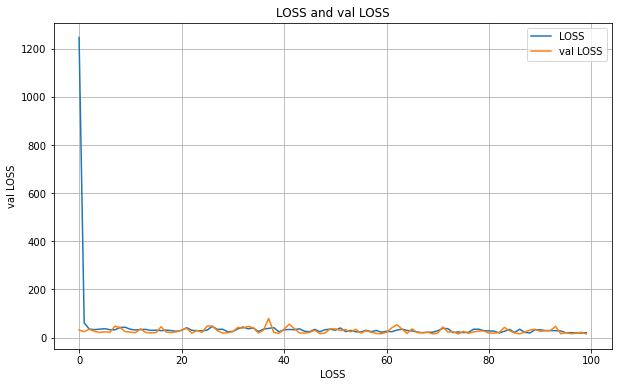

6/6 [==============================] - 0s 25ms/step


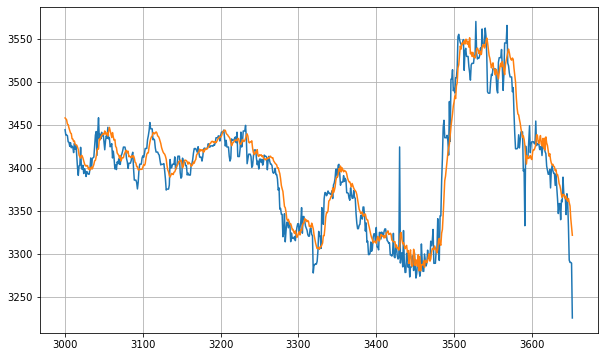

{'mae': 15.046477, 'mse': 437.0089, 'rmse': 20.904758, 'mape': 0.4431428, 'mase': 1.693897}
Model: "1_model_RUB"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     15/Unknown - 2s 23ms/step - loss: 63.0684 - mae: 61.9114

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 3s 85ms/step - loss: 47.5083 - mae: 46.4148 - val_loss: 20.8633 - val_mae: 19.9587
Epoch 2/100
16/24 [===================>..........] - ETA: 0s - loss: 10.5828 - mae: 9.7607 

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 73ms/step - loss: 8.8517 - mae: 8.0656 - val_loss: 9.6486 - val_mae: 8.9748
Epoch 3/100
16/24 [===================>..........] - ETA: 0s - loss: 4.9456 - mae: 4.3358

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 4.4691 - mae: 3.8822 - val_loss: 9.3643 - val_mae: 8.8808
Epoch 4/100
16/24 [===================>..........] - ETA: 0s - loss: 4.4930 - mae: 4.0399

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 79ms/step - loss: 4.0783 - mae: 3.6387 - val_loss: 8.8831 - val_mae: 8.5024
Epoch 5/100
16/24 [===================>..........] - ETA: 0s - loss: 4.1562 - mae: 3.8040

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 72ms/step - loss: 3.8053 - mae: 3.4620 - val_loss: 8.4323 - val_mae: 8.1338
Epoch 6/100
24/24 [==============================] - 1s 21ms/step - loss: 4.2569 - mae: 3.9933 - val_loss: 9.4539 - val_mae: 9.2331
Epoch 7/100
15/24 [=================>............] - ETA: 0s - loss: 4.0173 - mae: 3.7816

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 70ms/step - loss: 3.7148 - mae: 3.4844 - val_loss: 8.1771 - val_mae: 7.9702
Epoch 8/100
16/24 [===================>..........] - ETA: 0s - loss: 3.5480 - mae: 3.3388

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 70ms/step - loss: 3.3367 - mae: 3.1290 - val_loss: 7.9081 - val_mae: 7.7189
Epoch 9/100
24/24 [==============================] - 1s 24ms/step - loss: 3.3625 - mae: 3.1785 - val_loss: 8.2151 - val_mae: 8.0577
Epoch 10/100
24/24 [==============================] - 1s 21ms/step - loss: 4.6169 - mae: 4.4658 - val_loss: 8.6123 - val_mae: 8.4726
Epoch 11/100
24/24 [==============================] - 1s 21ms/step - loss: 4.3233 - mae: 4.1755 - val_loss: 8.8918 - val_mae: 8.7604
Epoch 12/100
15/24 [=================>............] - ETA: 0s - loss: 4.5907 - mae: 4.4479

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 75ms/step - loss: 4.8289 - mae: 4.6874 - val_loss: 7.8708 - val_mae: 7.7276
Epoch 13/100
15/24 [=================>............] - ETA: 0s - loss: 4.9310 - mae: 4.7966

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 4.0867 - mae: 3.9395 - val_loss: 7.5412 - val_mae: 7.3882
Epoch 14/100
24/24 [==============================] - 1s 21ms/step - loss: 2.8933 - mae: 2.7336 - val_loss: 8.0333 - val_mae: 7.8998
Epoch 15/100
16/24 [===================>..........] - ETA: 0s - loss: 3.0389 - mae: 2.8850

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 69ms/step - loss: 2.8794 - mae: 2.7252 - val_loss: 7.3885 - val_mae: 7.2424
Epoch 16/100
24/24 [==============================] - 1s 22ms/step - loss: 2.8894 - mae: 2.7388 - val_loss: 9.7867 - val_mae: 9.6736
Epoch 17/100
24/24 [==============================] - 1s 21ms/step - loss: 5.2718 - mae: 5.1482 - val_loss: 8.8944 - val_mae: 8.7785
Epoch 18/100
15/24 [=================>............] - ETA: 0s - loss: 4.7196 - mae: 4.5990

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 81ms/step - loss: 4.3105 - mae: 4.1870 - val_loss: 7.3259 - val_mae: 7.1893
Epoch 19/100
24/24 [==============================] - 1s 21ms/step - loss: 2.7524 - mae: 2.6019 - val_loss: 8.3224 - val_mae: 8.2073
Epoch 20/100
24/24 [==============================] - 1s 21ms/step - loss: 3.3771 - mae: 3.2417 - val_loss: 8.2297 - val_mae: 8.1155
Epoch 21/100
24/24 [==============================] - 1s 21ms/step - loss: 4.1602 - mae: 4.0434 - val_loss: 7.5702 - val_mae: 7.4483
Epoch 22/100
19/24 [======================>.......] - ETA: 0s - loss: 3.0829 - mae: 2.9431

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 81ms/step - loss: 2.9313 - mae: 2.7893 - val_loss: 7.3153 - val_mae: 7.1901
Epoch 23/100
22/24 [==========================>...] - ETA: 0s - loss: 2.7530 - mae: 2.6114

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.7280 - mae: 2.5857 - val_loss: 7.0924 - val_mae: 6.9555
Epoch 24/100
24/24 [==============================] - 1s 21ms/step - loss: 2.8379 - mae: 2.6991 - val_loss: 7.7152 - val_mae: 7.6056
Epoch 25/100
24/24 [==============================] - 1s 22ms/step - loss: 2.7497 - mae: 2.6092 - val_loss: 7.1709 - val_mae: 7.0408
Epoch 26/100
24/24 [==============================] - 1s 21ms/step - loss: 3.1281 - mae: 2.9928 - val_loss: 7.6494 - val_mae: 7.5418
Epoch 27/100
16/24 [===================>..........] - ETA: 0s - loss: 4.2072 - mae: 4.0867

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 70ms/step - loss: 3.5805 - mae: 3.4516 - val_loss: 7.0310 - val_mae: 6.9069
Epoch 28/100
24/24 [==============================] - 1s 21ms/step - loss: 2.4938 - mae: 2.3500 - val_loss: 7.7975 - val_mae: 7.6934
Epoch 29/100
15/24 [=================>............] - ETA: 0s - loss: 4.0842 - mae: 3.9677

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 3.5813 - mae: 3.4575 - val_loss: 6.9562 - val_mae: 6.8299
Epoch 30/100
15/24 [=================>............] - ETA: 0s - loss: 2.6100 - mae: 2.4674

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.4189 - mae: 2.2697 - val_loss: 6.8787 - val_mae: 6.7435
Epoch 31/100
24/24 [==============================] - 1s 23ms/step - loss: 3.4435 - mae: 3.3207 - val_loss: 9.1492 - val_mae: 9.0534
Epoch 32/100
24/24 [==============================] - 1s 21ms/step - loss: 4.2269 - mae: 4.1222 - val_loss: 7.8603 - val_mae: 7.7579
Epoch 33/100
24/24 [==============================] - 1s 21ms/step - loss: 4.0157 - mae: 3.9083 - val_loss: 7.7989 - val_mae: 7.6973
Epoch 34/100
24/24 [==============================] - 1s 22ms/step - loss: 3.5535 - mae: 3.4413 - val_loss: 7.4395 - val_mae: 7.3322
Epoch 35/100
24/24 [==============================] - 1s 21ms/step - loss: 3.1498 - mae: 3.0273 - val_loss: 7.9077 - val_mae: 7.8083
Epoch 36/100
24/24 [==============================] - 1s 21ms/step - loss: 3.4237 - mae: 3.3112 - val_loss: 7.0235 - val_mae: 6.9057
Epoch 37/100
24/24 [==============================] - 1s 22ms/step - loss: 3.0617 

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 81ms/step - loss: 3.4024 - mae: 3.2954 - val_loss: 6.7624 - val_mae: 6.6456
Epoch 43/100
16/24 [===================>..........] - ETA: 0s - loss: 2.4562 - mae: 2.3202

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 69ms/step - loss: 2.3198 - mae: 2.1819 - val_loss: 6.7323 - val_mae: 6.6109
Epoch 44/100
24/24 [==============================] - 1s 25ms/step - loss: 2.3473 - mae: 2.2130 - val_loss: 6.8024 - val_mae: 6.6956
Epoch 45/100
15/24 [=================>............] - ETA: 0s - loss: 2.6696 - mae: 2.5457

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 70ms/step - loss: 2.4320 - mae: 2.3015 - val_loss: 6.6754 - val_mae: 6.5583
Epoch 46/100
24/24 [==============================] - 1s 22ms/step - loss: 2.3840 - mae: 2.2545 - val_loss: 6.9751 - val_mae: 6.8796
Epoch 47/100
24/24 [==============================] - 1s 21ms/step - loss: 2.4435 - mae: 2.3163 - val_loss: 6.8877 - val_mae: 6.7880
Epoch 48/100
24/24 [==============================] - 1s 21ms/step - loss: 3.2615 - mae: 3.1521 - val_loss: 7.1995 - val_mae: 7.1009
Epoch 49/100
24/24 [==============================] - 1s 21ms/step - loss: 3.5918 - mae: 3.4895 - val_loss: 8.8633 - val_mae: 8.7816
Epoch 50/100
24/24 [==============================] - 1s 21ms/step - loss: 3.5516 - mae: 3.4542 - val_loss: 6.6904 - val_mae: 6.5762
Epoch 51/100
24/24 [==============================] - 1s 21ms/step - loss: 2.3216 - mae: 2.1906 - val_loss: 6.8437 - val_mae: 6.7380
Epoch 52/100
16/24 [===================>..........] - ETA: 0s - loss: 2.4683 - mae

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 70ms/step - loss: 2.2989 - mae: 2.1679 - val_loss: 6.5516 - val_mae: 6.4322
Epoch 53/100
24/24 [==============================] - 1s 21ms/step - loss: 2.3974 - mae: 2.2737 - val_loss: 6.5715 - val_mae: 6.4598
Epoch 54/100
24/24 [==============================] - 1s 22ms/step - loss: 2.3806 - mae: 2.2544 - val_loss: 6.6865 - val_mae: 6.5755
Epoch 55/100
15/24 [=================>............] - ETA: 0s - loss: 2.6813 - mae: 2.5625

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.5041 - mae: 2.3834 - val_loss: 6.5205 - val_mae: 6.4098
Epoch 56/100
24/24 [==============================] - 1s 21ms/step - loss: 3.0191 - mae: 2.9145 - val_loss: 6.7794 - val_mae: 6.6890
Epoch 57/100
15/24 [=================>............] - ETA: 0s - loss: 3.7999 - mae: 3.7069

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 70ms/step - loss: 3.3629 - mae: 3.2637 - val_loss: 6.5050 - val_mae: 6.3950
Epoch 58/100
24/24 [==============================] - 1s 23ms/step - loss: 4.3004 - mae: 4.2184 - val_loss: 7.1757 - val_mae: 7.0923
Epoch 59/100
24/24 [==============================] - 1s 22ms/step - loss: 2.6222 - mae: 2.5095 - val_loss: 6.8545 - val_mae: 6.7639
Epoch 60/100
24/24 [==============================] - 1s 21ms/step - loss: 2.4995 - mae: 2.3844 - val_loss: 6.5542 - val_mae: 6.4465
Epoch 61/100
24/24 [==============================] - 1s 21ms/step - loss: 2.6473 - mae: 2.5380 - val_loss: 6.8613 - val_mae: 6.7735
Epoch 62/100
24/24 [==============================] - 1s 22ms/step - loss: 3.6064 - mae: 3.5215 - val_loss: 7.8242 - val_mae: 7.7491
Epoch 63/100
24/24 [==============================] - 1s 21ms/step - loss: 2.8445 - mae: 2.7396 - val_loss: 7.0858 - val_mae: 7.0007
Epoch 64/100
24/24 [==============================] - 1s 21ms/step - loss: 3.5795 

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 73ms/step - loss: 2.6283 - mae: 2.5148 - val_loss: 6.4439 - val_mae: 6.3382
Epoch 67/100
24/24 [==============================] - 1s 21ms/step - loss: 2.3057 - mae: 2.1866 - val_loss: 6.4539 - val_mae: 6.3548
Epoch 68/100
24/24 [==============================] - 1s 21ms/step - loss: 3.3267 - mae: 3.2414 - val_loss: 7.3463 - val_mae: 7.2738
Epoch 69/100
24/24 [==============================] - 1s 21ms/step - loss: 2.9607 - mae: 2.8663 - val_loss: 6.6671 - val_mae: 6.5831
Epoch 70/100
24/24 [==============================] - 1s 21ms/step - loss: 2.9740 - mae: 2.8760 - val_loss: 6.7056 - val_mae: 6.6223
Epoch 71/100
15/24 [=================>............] - ETA: 0s - loss: 3.3082 - mae: 3.2166

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 81ms/step - loss: 3.0397 - mae: 2.9452 - val_loss: 6.3690 - val_mae: 6.2677
Epoch 72/100
24/24 [==============================] - 1s 21ms/step - loss: 2.3881 - mae: 2.2816 - val_loss: 6.5938 - val_mae: 6.5116
Epoch 73/100
15/24 [=================>............] - ETA: 0s - loss: 2.4100 - mae: 2.2979

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.2530 - mae: 2.1385 - val_loss: 6.3156 - val_mae: 6.2132
Epoch 74/100
24/24 [==============================] - 1s 21ms/step - loss: 2.2604 - mae: 2.1469 - val_loss: 6.5755 - val_mae: 6.4983
Epoch 75/100
22/24 [==========================>...] - ETA: 0s - loss: 2.4684 - mae: 2.3640

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.4383 - mae: 2.3329 - val_loss: 6.2851 - val_mae: 6.1890
Epoch 76/100
24/24 [==============================] - 1s 21ms/step - loss: 2.1948 - mae: 2.0815 - val_loss: 6.3574 - val_mae: 6.2725
Epoch 77/100
21/24 [=========================>....] - ETA: 0s - loss: 2.2702 - mae: 2.1619

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.2401 - mae: 2.1319 - val_loss: 6.2558 - val_mae: 6.1571
Epoch 78/100
24/24 [==============================] - 1s 21ms/step - loss: 2.2197 - mae: 2.1105 - val_loss: 6.3209 - val_mae: 6.2242
Epoch 79/100
24/24 [==============================] - 1s 21ms/step - loss: 2.1507 - mae: 2.0393 - val_loss: 7.3463 - val_mae: 7.2829
Epoch 80/100
16/24 [===================>..........] - ETA: 0s - loss: 2.9734 - mae: 2.8893

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 72ms/step - loss: 3.1190 - mae: 3.0399 - val_loss: 6.2357 - val_mae: 6.1381
Epoch 81/100
24/24 [==============================] - 1s 21ms/step - loss: 2.4313 - mae: 2.3332 - val_loss: 6.2780 - val_mae: 6.1816
Epoch 82/100
24/24 [==============================] - 1s 22ms/step - loss: 2.4116 - mae: 2.3161 - val_loss: 6.5446 - val_mae: 6.4769
Epoch 83/100
24/24 [==============================] - 1s 21ms/step - loss: 2.2233 - mae: 2.1175 - val_loss: 6.2890 - val_mae: 6.1970
Epoch 84/100
16/24 [===================>..........] - ETA: 0s - loss: 2.2629 - mae: 2.1663

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.1378 - mae: 2.0360 - val_loss: 6.2282 - val_mae: 6.1356
Epoch 85/100
16/24 [===================>..........] - ETA: 0s - loss: 2.2481 - mae: 2.1432

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 79ms/step - loss: 2.1380 - mae: 2.0309 - val_loss: 6.1954 - val_mae: 6.1138
Epoch 86/100
24/24 [==============================] - 1s 21ms/step - loss: 2.0539 - mae: 1.9444 - val_loss: 6.9372 - val_mae: 6.8787
Epoch 87/100
15/24 [=================>............] - ETA: 0s - loss: 2.8359 - mae: 2.7541

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.5326 - mae: 2.4433 - val_loss: 6.0855 - val_mae: 5.9946
Epoch 88/100
24/24 [==============================] - 1s 22ms/step - loss: 2.2871 - mae: 2.1937 - val_loss: 6.0881 - val_mae: 5.9976
Epoch 89/100
24/24 [==============================] - 1s 21ms/step - loss: 3.5193 - mae: 3.4541 - val_loss: 6.1541 - val_mae: 6.0737
Epoch 90/100
24/24 [==============================] - 1s 21ms/step - loss: 2.4611 - mae: 2.3742 - val_loss: 6.1015 - val_mae: 6.0170
Epoch 91/100
24/24 [==============================] - 1s 21ms/step - loss: 2.8202 - mae: 2.7392 - val_loss: 6.1013 - val_mae: 6.0166
Epoch 92/100
24/24 [==============================] - 1s 21ms/step - loss: 2.3615 - mae: 2.2744 - val_loss: 6.8254 - val_mae: 6.7698
Epoch 93/100
24/24 [==============================] - 1s 21ms/step - loss: 2.1201 - mae: 2.0187 - val_loss: 6.4022 - val_mae: 6.3363
Epoch 94/100
24/24 [==============================] - 1s 22ms/step - loss: 2.5711 

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.0903 - mae: 1.9937 - val_loss: 6.0595 - val_mae: 5.9802
Epoch 98/100
24/24 [==============================] - 1s 22ms/step - loss: 2.0738 - mae: 1.9766 - val_loss: 6.1875 - val_mae: 6.1170
Epoch 99/100
16/24 [===================>..........] - ETA: 0s - loss: 2.3318 - mae: 2.2484

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.2593 - mae: 2.1744 - val_loss: 5.9829 - val_mae: 5.9032
Epoch 100/100
15/24 [=================>............] - ETA: 0s - loss: 2.2618 - mae: 2.1733

INFO:tensorflow:Assets written to: saved_model/10\assets


INFO:tensorflow:Assets written to: saved_model/10\assets


5/5 [==============================] - 0s 12ms/step - loss: 5.9779 - mae: 5.8971


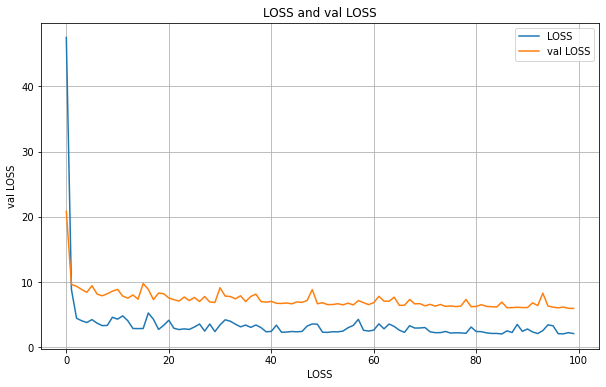

6/6 [==============================] - 0s 24ms/step


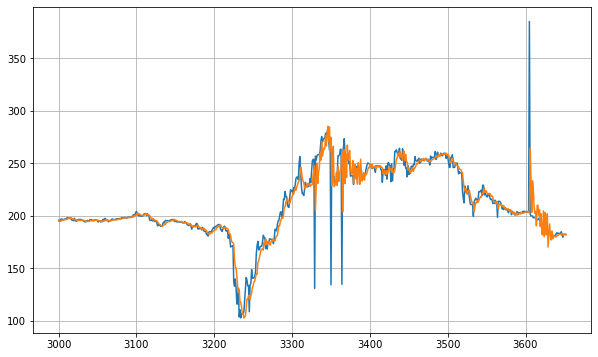

{'mae': 5.6643825, 'mse': 198.3106, 'rmse': 14.082279, 'mape': 2.8932571, 'mase': 1.2821113}


In [21]:
count = 1
eval_models_1 = {}

for i in range(1,11):
    time, series, currency = open_file(i)

    split_time = 3000
    window_size = 30
    batch_size = 128
    shuffle_buffer_size = 1000

    train_set, valid_set = prepared_data(series, time, split_time, window_size, batch_size, shuffle_buffer_size)

    model = first_model(train_set, valid_set, window_size)

    evaluate_model(model, series, split_time, window_size, batch_size, count, eval_models_1, currency)

Model: "2_model_EUR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
     15/Unknown - 2s 23ms/step - loss: 

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 4s 95ms/step - loss: 2925.6206 - mae: 2926.1201 - val_loss: 283.1400 - val_mae: 283.6400
Epoch 2/100
20/24 [========================>.....] - ETA: 0s - loss: 253.4446 - mae: 253.9441

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 73ms/step - loss: 253.3421 - mae: 253.8416 - val_loss: 165.2588 - val_mae: 165.7585
Epoch 3/100
24/24 [==============================] - 1s 23ms/step - loss: 245.8004 - mae: 246.2996 - val_loss: 172.7669 - val_mae: 173.2669
Epoch 4/100
24/24 [==============================] - 1s 27ms/step - loss: 335.0538 - mae: 335.5537 - val_loss: 330.2502 - val_mae: 330.7502
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 273.8825 - mae: 274.3821 - val_loss: 290.5933 - val_mae: 291.0933
Epoch 6/100
16/24 [===================>..........] - ETA: 0s - loss: 281.5798 - mae: 282.0791

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 71ms/step - loss: 267.5517 - mae: 268.0508 - val_loss: 163.2348 - val_mae: 163.7345
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 207.5859 - mae: 208.0850 - val_loss: 186.1681 - val_mae: 186.6675
Epoch 8/100
21/24 [=========================>....] - ETA: 0s - loss: 217.4349 - mae: 217.9348

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 74ms/step - loss: 217.3717 - mae: 217.8717 - val_loss: 152.7033 - val_mae: 153.2026
Epoch 9/100
24/24 [==============================] - 1s 22ms/step - loss: 204.9091 - mae: 205.4088 - val_loss: 231.1923 - val_mae: 231.6922
Epoch 10/100
24/24 [==============================] - 1s 22ms/step - loss: 303.2889 - mae: 303.7885 - val_loss: 242.4516 - val_mae: 242.9509
Epoch 11/100
24/24 [==============================] - 1s 22ms/step - loss: 244.3414 - mae: 244.8406 - val_loss: 161.8250 - val_mae: 162.3243
Epoch 12/100
15/24 [=================>............] - ETA: 0s - loss: 195.6115 - mae: 196.1108

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 73ms/step - loss: 198.9482 - mae: 199.4477 - val_loss: 148.5300 - val_mae: 149.0299
Epoch 13/100
24/24 [==============================] - 1s 23ms/step - loss: 202.4638 - mae: 202.9632 - val_loss: 394.6766 - val_mae: 395.1766
Epoch 14/100
15/24 [=================>............] - ETA: 0s - loss: 206.4357 - mae: 206.9353

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 73ms/step - loss: 199.8142 - mae: 200.3138 - val_loss: 136.4177 - val_mae: 136.9168
Epoch 15/100
24/24 [==============================] - 1s 22ms/step - loss: 282.6153 - mae: 283.1147 - val_loss: 367.8950 - val_mae: 368.3950
Epoch 16/100
24/24 [==============================] - 1s 22ms/step - loss: 299.2324 - mae: 299.7322 - val_loss: 250.4776 - val_mae: 250.9776
Epoch 17/100
24/24 [==============================] - 1s 23ms/step - loss: 243.5629 - mae: 244.0624 - val_loss: 181.9991 - val_mae: 182.4988
Epoch 18/100
24/24 [==============================] - 1s 22ms/step - loss: 194.0386 - mae: 194.5381 - val_loss: 246.5398 - val_mae: 247.0392
Epoch 19/100
24/24 [==============================] - 1s 22ms/step - loss: 233.4068 - mae: 233.9063 - val_loss: 145.5869 - val_mae: 146.0857
Epoch 20/100
24/24 [==============================] - 1s 22ms/step - loss: 222.0577 - mae: 222.5572 - val_loss: 239.6879 - val_mae: 240.1879
Epoch 21/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 80ms/step - loss: 172.5536 - mae: 173.0533 - val_loss: 133.4979 - val_mae: 133.9969
Epoch 27/100
24/24 [==============================] - 1s 22ms/step - loss: 159.4397 - mae: 159.9387 - val_loss: 194.9114 - val_mae: 195.4109
Epoch 28/100
24/24 [==============================] - 1s 21ms/step - loss: 171.6995 - mae: 172.1990 - val_loss: 255.7565 - val_mae: 256.2561
Epoch 29/100
15/24 [=================>............] - ETA: 0s - loss: 176.7075 - mae: 177.2071

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 72ms/step - loss: 168.1995 - mae: 168.6992 - val_loss: 119.8801 - val_mae: 120.3796
Epoch 30/100
24/24 [==============================] - 1s 22ms/step - loss: 177.5355 - mae: 178.0352 - val_loss: 120.4181 - val_mae: 120.9176
Epoch 31/100
24/24 [==============================] - 1s 22ms/step - loss: 166.4594 - mae: 166.9586 - val_loss: 244.6756 - val_mae: 245.1756
Epoch 32/100
24/24 [==============================] - 1s 21ms/step - loss: 166.1287 - mae: 166.6275 - val_loss: 270.4508 - val_mae: 270.9505
Epoch 33/100
24/24 [==============================] - 1s 22ms/step - loss: 229.5681 - mae: 230.0676 - val_loss: 256.1172 - val_mae: 256.6172
Epoch 34/100
16/24 [===================>..........] - ETA: 0s - loss: 197.6105 - mae: 198.1101

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 74ms/step - loss: 185.9421 - mae: 186.4417 - val_loss: 116.0433 - val_mae: 116.5429
Epoch 35/100
24/24 [==============================] - 1s 22ms/step - loss: 223.4688 - mae: 223.9683 - val_loss: 148.2627 - val_mae: 148.7615
Epoch 36/100
24/24 [==============================] - 1s 25ms/step - loss: 168.0690 - mae: 168.5685 - val_loss: 179.3687 - val_mae: 179.8687
Epoch 37/100
24/24 [==============================] - 1s 22ms/step - loss: 270.8479 - mae: 271.3477 - val_loss: 291.4424 - val_mae: 291.9424
Epoch 38/100
24/24 [==============================] - 1s 22ms/step - loss: 187.5817 - mae: 188.0810 - val_loss: 283.5527 - val_mae: 284.0523
Epoch 39/100
24/24 [==============================] - 1s 22ms/step - loss: 242.8290 - mae: 243.3285 - val_loss: 206.8506 - val_mae: 207.3506
Epoch 40/100
24/24 [==============================] - 1s 22ms/step - loss: 254.8061 - mae: 255.3059 - val_loss: 310.7292 - val_mae: 311.2292
Epoch 41/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 72ms/step - loss: 141.6795 - mae: 142.1788 - val_loss: 112.5030 - val_mae: 113.0030
Epoch 51/100
16/24 [===================>..........] - ETA: 0s - loss: 127.4083 - mae: 127.9070

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 73ms/step - loss: 134.8168 - mae: 135.3153 - val_loss: 105.2955 - val_mae: 105.7951
Epoch 52/100
24/24 [==============================] - 1s 21ms/step - loss: 157.6636 - mae: 158.1632 - val_loss: 142.3550 - val_mae: 142.8548
Epoch 53/100
24/24 [==============================] - 1s 22ms/step - loss: 146.1977 - mae: 146.6968 - val_loss: 108.9624 - val_mae: 109.4613
Epoch 54/100
15/24 [=================>............] - ETA: 0s - loss: 145.8902 - mae: 146.3894

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 72ms/step - loss: 139.1145 - mae: 139.6139 - val_loss: 100.9658 - val_mae: 101.4654
Epoch 55/100
24/24 [==============================] - 1s 23ms/step - loss: 134.1644 - mae: 134.6635 - val_loss: 168.5264 - val_mae: 169.0264
Epoch 56/100
16/24 [===================>..........] - ETA: 0s - loss: 128.7746 - mae: 129.2741

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 81ms/step - loss: 129.0184 - mae: 129.5178 - val_loss: 99.3666 - val_mae: 99.8656
Epoch 57/100
24/24 [==============================] - 1s 22ms/step - loss: 132.0598 - mae: 132.5589 - val_loss: 99.5706 - val_mae: 100.0688
Epoch 58/100
24/24 [==============================] - 1s 22ms/step - loss: 152.4194 - mae: 152.9182 - val_loss: 144.4970 - val_mae: 144.9962
Epoch 59/100
24/24 [==============================] - 1s 22ms/step - loss: 131.1747 - mae: 131.6738 - val_loss: 107.6745 - val_mae: 108.1741
Epoch 60/100
24/24 [==============================] - 1s 21ms/step - loss: 139.8777 - mae: 140.3768 - val_loss: 112.8820 - val_mae: 113.3813
Epoch 61/100
24/24 [==============================] - 1s 21ms/step - loss: 136.9243 - mae: 137.4228 - val_loss: 107.6788 - val_mae: 108.1785
Epoch 62/100
15/24 [=================>............] - ETA: 0s - loss: 133.0598 - mae: 133.5590

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 72ms/step - loss: 141.0982 - mae: 141.5974 - val_loss: 95.9579 - val_mae: 96.4563
Epoch 63/100
24/24 [==============================] - 1s 22ms/step - loss: 158.9352 - mae: 159.4345 - val_loss: 96.1380 - val_mae: 96.6365
Epoch 64/100
24/24 [==============================] - 1s 21ms/step - loss: 192.1567 - mae: 192.6561 - val_loss: 131.3012 - val_mae: 131.7988
Epoch 65/100
24/24 [==============================] - 1s 22ms/step - loss: 281.4940 - mae: 281.9936 - val_loss: 333.5647 - val_mae: 334.0647
Epoch 66/100
24/24 [==============================] - 1s 21ms/step - loss: 225.6939 - mae: 226.1935 - val_loss: 155.0706 - val_mae: 155.5705
Epoch 67/100
24/24 [==============================] - 1s 22ms/step - loss: 220.7892 - mae: 221.2889 - val_loss: 250.9743 - val_mae: 251.4735
Epoch 68/100
24/24 [==============================] - 1s 26ms/step - loss: 201.8239 - mae: 202.3234 - val_loss: 255.8382 - val_mae: 256.3382
Epoch 69/100
24/24 [==========

INFO:tensorflow:Assets written to: saved_model/11\assets


INFO:tensorflow:Assets written to: saved_model/11\assets


24/24 [==============================] - 2s 75ms/step - loss: 121.4615 - mae: 121.9608 - val_loss: 94.4091 - val_mae: 94.9077
Epoch 89/100
24/24 [==============================] - 1s 22ms/step - loss: 227.7397 - mae: 228.2395 - val_loss: 114.4773 - val_mae: 114.9773
Epoch 90/100
24/24 [==============================] - 1s 25ms/step - loss: 213.8681 - mae: 214.3678 - val_loss: 244.8655 - val_mae: 245.3649
Epoch 91/100
24/24 [==============================] - 1s 21ms/step - loss: 214.7086 - mae: 215.2084 - val_loss: 281.3917 - val_mae: 281.8917
Epoch 92/100
24/24 [==============================] - 1s 22ms/step - loss: 163.1626 - mae: 163.6620 - val_loss: 101.3300 - val_mae: 101.8299
Epoch 93/100
24/24 [==============================] - 1s 22ms/step - loss: 192.0713 - mae: 192.5711 - val_loss: 113.7911 - val_mae: 114.2898
Epoch 94/100
24/24 [==============================] - 1s 22ms/step - loss: 176.8022 - mae: 177.3022 - val_loss: 220.4520 - val_mae: 220.9516
Epoch 95/100
24/24 [========

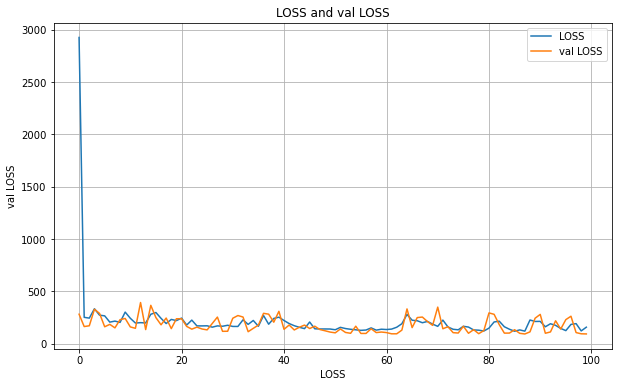

6/6 [==============================] - 0s 24ms/step


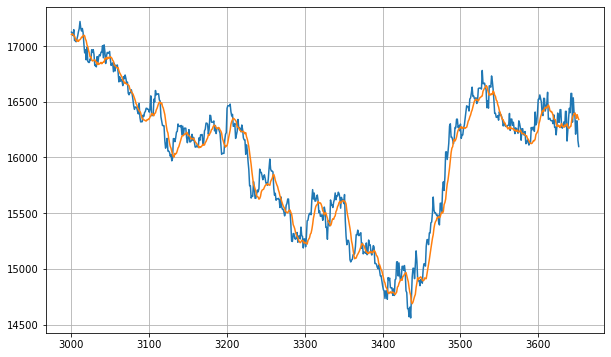

{'mae': 93.99067, 'mse': 14753.979, 'rmse': 121.46596, 'mape': 0.59116364, 'mase': 1.8161865}
Model: "2_model_USD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_______________________

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 4s 85ms/step - loss: 5045.1562 - mae: 5045.6562 - val_loss: 170.9135 - val_mae: 171.4134
Epoch 2/100
24/24 [==============================] - 1s 22ms/step - loss: 436.7542 - mae: 437.2541 - val_loss: 201.3065 - val_mae: 201.8065
Epoch 3/100
16/24 [===================>..........] - ETA: 0s - loss: 203.3504 - mae: 203.8497

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 71ms/step - loss: 199.1483 - mae: 199.6478 - val_loss: 114.4543 - val_mae: 114.9533
Epoch 4/100
24/24 [==============================] - 1s 22ms/step - loss: 162.8594 - mae: 163.3578 - val_loss: 120.3137 - val_mae: 120.8133
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 164.0656 - mae: 164.5652 - val_loss: 138.4250 - val_mae: 138.9249
Epoch 6/100
16/24 [===================>..........] - ETA: 0s - loss: 162.6194 - mae: 163.1185

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 82ms/step - loss: 163.3062 - mae: 163.8052 - val_loss: 109.6381 - val_mae: 110.1367
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 160.5721 - mae: 161.0712 - val_loss: 163.9259 - val_mae: 164.4258
Epoch 8/100
16/24 [===================>..........] - ETA: 0s - loss: 158.2016 - mae: 158.7006

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 72ms/step - loss: 161.9715 - mae: 162.4707 - val_loss: 108.5044 - val_mae: 109.0041
Epoch 9/100
24/24 [==============================] - 1s 21ms/step - loss: 175.9706 - mae: 176.4702 - val_loss: 112.9232 - val_mae: 113.4215
Epoch 10/100
24/24 [==============================] - 1s 22ms/step - loss: 178.5419 - mae: 179.0415 - val_loss: 122.8170 - val_mae: 123.3170
Epoch 11/100
16/24 [===================>..........] - ETA: 0s - loss: 154.0332 - mae: 154.5327

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 71ms/step - loss: 151.4667 - mae: 151.9662 - val_loss: 108.1477 - val_mae: 108.6459
Epoch 12/100
16/24 [===================>..........] - ETA: 0s - loss: 145.0616 - mae: 145.5607

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 72ms/step - loss: 150.5883 - mae: 151.0875 - val_loss: 104.8997 - val_mae: 105.3984
Epoch 13/100
24/24 [==============================] - 1s 22ms/step - loss: 156.5215 - mae: 157.0204 - val_loss: 220.8003 - val_mae: 221.3003
Epoch 14/100
20/24 [========================>.....] - ETA: 0s - loss: 159.7487 - mae: 160.2482

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 74ms/step - loss: 157.4277 - mae: 157.9273 - val_loss: 103.9046 - val_mae: 104.4029
Epoch 15/100
24/24 [==============================] - 1s 22ms/step - loss: 151.7827 - mae: 152.2821 - val_loss: 172.6348 - val_mae: 173.1341
Epoch 16/100
24/24 [==============================] - 1s 23ms/step - loss: 145.3551 - mae: 145.8543 - val_loss: 134.6374 - val_mae: 135.1372
Epoch 17/100
24/24 [==============================] - 1s 26ms/step - loss: 207.6368 - mae: 208.1364 - val_loss: 297.5780 - val_mae: 298.0780
Epoch 18/100
24/24 [==============================] - 1s 22ms/step - loss: 174.5713 - mae: 175.0704 - val_loss: 273.5919 - val_mae: 274.0919
Epoch 19/100
24/24 [==============================] - 1s 22ms/step - loss: 210.7486 - mae: 211.2480 - val_loss: 150.6710 - val_mae: 151.1710
Epoch 20/100
24/24 [==============================] - 1s 21ms/step - loss: 149.0324 - mae: 149.5314 - val_loss: 133.0019 - val_mae: 133.5019
Epoch 21/100
16/24 [======

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 72ms/step - loss: 174.3453 - mae: 174.8449 - val_loss: 93.6021 - val_mae: 94.1006
Epoch 22/100
16/24 [===================>..........] - ETA: 0s - loss: 125.8500 - mae: 126.3491

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 80ms/step - loss: 130.4831 - mae: 130.9820 - val_loss: 93.5471 - val_mae: 94.0461
Epoch 23/100
24/24 [==============================] - 1s 22ms/step - loss: 172.1182 - mae: 172.6175 - val_loss: 157.0014 - val_mae: 157.5004
Epoch 24/100
24/24 [==============================] - 1s 22ms/step - loss: 175.4752 - mae: 175.9745 - val_loss: 265.4776 - val_mae: 265.9776
Epoch 25/100
24/24 [==============================] - 1s 22ms/step - loss: 228.0270 - mae: 228.5266 - val_loss: 171.4884 - val_mae: 171.9884
Epoch 26/100
24/24 [==============================] - 1s 22ms/step - loss: 175.4202 - mae: 175.9194 - val_loss: 229.3021 - val_mae: 229.8021
Epoch 27/100
24/24 [==============================] - 1s 22ms/step - loss: 186.9051 - mae: 187.4044 - val_loss: 94.2851 - val_mae: 94.7836
Epoch 28/100
24/24 [==============================] - 1s 22ms/step - loss: 130.5982 - mae: 131.0970 - val_loss: 101.7788 - val_mae: 102.2785
Epoch 29/100
15/24 [==========

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 72ms/step - loss: 134.6761 - mae: 135.1755 - val_loss: 93.3650 - val_mae: 93.8636
Epoch 30/100
24/24 [==============================] - 1s 22ms/step - loss: 122.1495 - mae: 122.6489 - val_loss: 152.4267 - val_mae: 152.9265
Epoch 31/100
24/24 [==============================] - 1s 22ms/step - loss: 134.9077 - mae: 135.4070 - val_loss: 150.7473 - val_mae: 151.2467
Epoch 32/100
16/24 [===================>..........] - ETA: 0s - loss: 128.4351 - mae: 128.9337

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 72ms/step - loss: 126.5865 - mae: 127.0851 - val_loss: 85.0410 - val_mae: 85.5403
Epoch 33/100
24/24 [==============================] - 1s 22ms/step - loss: 156.6707 - mae: 157.1702 - val_loss: 114.9456 - val_mae: 115.4448
Epoch 34/100
24/24 [==============================] - 1s 22ms/step - loss: 154.2711 - mae: 154.7706 - val_loss: 184.7302 - val_mae: 185.2295
Epoch 35/100
24/24 [==============================] - 1s 22ms/step - loss: 156.7929 - mae: 157.2921 - val_loss: 89.3613 - val_mae: 89.8607
Epoch 36/100
24/24 [==============================] - 1s 22ms/step - loss: 171.9120 - mae: 172.4115 - val_loss: 259.1674 - val_mae: 259.6674
Epoch 37/100
24/24 [==============================] - 1s 22ms/step - loss: 180.0319 - mae: 180.5315 - val_loss: 159.5888 - val_mae: 160.0887
Epoch 38/100
24/24 [==============================] - 1s 26ms/step - loss: 126.3496 - mae: 126.8489 - val_loss: 89.8349 - val_mae: 90.3337
Epoch 39/100
24/24 [============

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 72ms/step - loss: 130.5577 - mae: 131.0571 - val_loss: 75.3216 - val_mae: 75.8179
Epoch 63/100
24/24 [==============================] - 1s 22ms/step - loss: 101.0083 - mae: 101.5080 - val_loss: 102.9489 - val_mae: 103.4482
Epoch 64/100
24/24 [==============================] - 1s 23ms/step - loss: 100.8471 - mae: 101.3454 - val_loss: 96.9335 - val_mae: 97.4329
Epoch 65/100
24/24 [==============================] - 1s 22ms/step - loss: 97.2494 - mae: 97.7477 - val_loss: 126.0542 - val_mae: 126.5539
Epoch 66/100
24/24 [==============================] - 1s 22ms/step - loss: 113.4092 - mae: 113.9086 - val_loss: 84.0940 - val_mae: 84.5924
Epoch 67/100
24/24 [==============================] - 1s 22ms/step - loss: 102.6424 - mae: 103.1414 - val_loss: 88.7168 - val_mae: 89.2164
Epoch 68/100
24/24 [==============================] - 1s 31ms/step - loss: 101.5266 - mae: 102.0247 - val_loss: 170.4746 - val_mae: 170.9746
Epoch 69/100
24/24 [================

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 74ms/step - loss: 98.9303 - mae: 99.4290 - val_loss: 70.1810 - val_mae: 70.6784
Epoch 82/100
24/24 [==============================] - 1s 22ms/step - loss: 94.3062 - mae: 94.8050 - val_loss: 77.4840 - val_mae: 77.9820
Epoch 83/100
24/24 [==============================] - 1s 21ms/step - loss: 94.6667 - mae: 95.1656 - val_loss: 96.3773 - val_mae: 96.8767
Epoch 84/100
24/24 [==============================] - 1s 21ms/step - loss: 151.0275 - mae: 151.5273 - val_loss: 115.9244 - val_mae: 116.4241
Epoch 85/100
24/24 [==============================] - 1s 21ms/step - loss: 143.7886 - mae: 144.2882 - val_loss: 227.8686 - val_mae: 228.3683
Epoch 86/100
24/24 [==============================] - 1s 20ms/step - loss: 150.3825 - mae: 150.8823 - val_loss: 141.4484 - val_mae: 141.9483
Epoch 87/100
24/24 [==============================] - 1s 21ms/step - loss: 98.8982 - mae: 99.3970 - val_loss: 118.5252 - val_mae: 119.0247
Epoch 88/100
24/24 [====================

INFO:tensorflow:Assets written to: saved_model/12\assets


INFO:tensorflow:Assets written to: saved_model/12\assets


24/24 [==============================] - 2s 66ms/step - loss: 211.7181 - mae: 212.2178 - val_loss: 64.2026 - val_mae: 64.7004
Epoch 95/100
24/24 [==============================] - 1s 19ms/step - loss: 161.6678 - mae: 162.1672 - val_loss: 125.0318 - val_mae: 125.5305
Epoch 96/100
24/24 [==============================] - 1s 20ms/step - loss: 150.7084 - mae: 151.2080 - val_loss: 71.1483 - val_mae: 71.6464
Epoch 97/100
24/24 [==============================] - 1s 20ms/step - loss: 115.5648 - mae: 116.0637 - val_loss: 64.7950 - val_mae: 65.2929
Epoch 98/100
24/24 [==============================] - 1s 19ms/step - loss: 297.6291 - mae: 298.1290 - val_loss: 171.2642 - val_mae: 171.7642
Epoch 99/100
24/24 [==============================] - 1s 20ms/step - loss: 286.6994 - mae: 287.1994 - val_loss: 247.5409 - val_mae: 248.0409
Epoch 100/100
5/5 [==============================] - 0s 10ms/step - loss: 203.5991 - mae: 204.0982


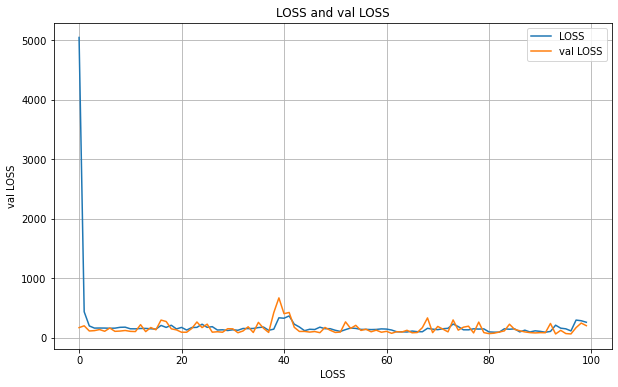

6/6 [==============================] - 0s 20ms/step


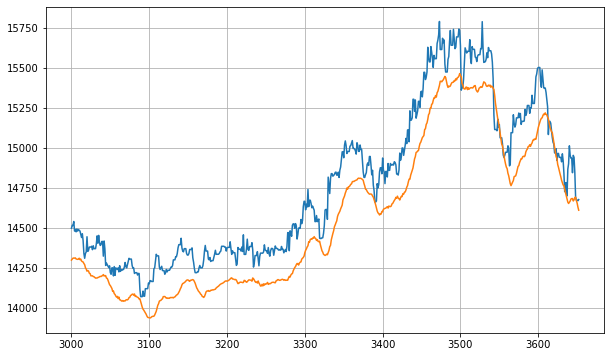

{'mae': 202.16711, 'mse': 48100.49, 'rmse': 219.31824, 'mape': 1.3660799, 'mase': 6.348398}
Model: "2_model_JPY"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_________________________

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 3s 78ms/step - loss: 12.3147 - mae: 12.7968 - val_loss: 1.0711 - val_mae: 1.5083
Epoch 2/100
24/24 [==============================] - 1s 20ms/step - loss: 1.8618 - mae: 2.3223 - val_loss: 1.7472 - val_mae: 2.2062
Epoch 3/100
24/24 [==============================] - 1s 20ms/step - loss: 2.1025 - mae: 2.5709 - val_loss: 1.1217 - val_mae: 1.5571
Epoch 4/100
24/24 [==============================] - 1s 20ms/step - loss: 1.2121 - mae: 1.6422 - val_loss: 2.1478 - val_mae: 2.6234
Epoch 5/100
24/24 [==============================] - 1s 23ms/step - loss: 1.7773 - mae: 2.2346 - val_loss: 1.7355 - val_mae: 2.1970
Epoch 6/100
24/24 [==============================] - 1s 20ms/step - loss: 1.3361 - mae: 1.7780 - val_loss: 1.3229 - val_mae: 1.7697
Epoch 7/100
24/24 [==============================] - 1s 20ms/step - loss: 1.0955 - mae: 1.5236 - val_loss: 1.0899 - val_mae: 1.5206
Epoch 8/100
17/24 [====================>.........] - ETA: 0s - loss: 1.1800 - mae: 1.6

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 65ms/step - loss: 1.1603 - mae: 1.5931 - val_loss: 0.8460 - val_mae: 1.2609
Epoch 9/100
24/24 [==============================] - 1s 19ms/step - loss: 1.3929 - mae: 1.8319 - val_loss: 1.2832 - val_mae: 1.7322
Epoch 10/100
24/24 [==============================] - 1s 19ms/step - loss: 0.9840 - mae: 1.4064 - val_loss: 0.9700 - val_mae: 1.3958
Epoch 11/100
24/24 [==============================] - 1s 19ms/step - loss: 1.0043 - mae: 1.4237 - val_loss: 1.2245 - val_mae: 1.6735
Epoch 12/100
24/24 [==============================] - 1s 19ms/step - loss: 0.9555 - mae: 1.3737 - val_loss: 0.9936 - val_mae: 1.4268
Epoch 13/100
24/24 [==============================] - 1s 20ms/step - loss: 0.9872 - mae: 1.4088 - val_loss: 1.0755 - val_mae: 1.5127
Epoch 14/100
17/24 [====================>.........] - ETA: 0s - loss: 1.0575 - mae: 1.4882

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 70ms/step - loss: 1.0412 - mae: 1.4693 - val_loss: 0.6744 - val_mae: 1.0686
Epoch 15/100
17/24 [====================>.........] - ETA: 0s - loss: 0.8641 - mae: 1.2829

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 66ms/step - loss: 0.9499 - mae: 1.3730 - val_loss: 0.6413 - val_mae: 1.0349
Epoch 16/100
24/24 [==============================] - 1s 20ms/step - loss: 0.9986 - mae: 1.4265 - val_loss: 0.6521 - val_mae: 1.0562
Epoch 17/100
24/24 [==============================] - 1s 20ms/step - loss: 1.0871 - mae: 1.5117 - val_loss: 0.7323 - val_mae: 1.1411
Epoch 18/100
17/24 [====================>.........] - ETA: 0s - loss: 1.0069 - mae: 1.4354

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 66ms/step - loss: 0.9704 - mae: 1.3949 - val_loss: 0.6215 - val_mae: 1.0103
Epoch 19/100
24/24 [==============================] - 1s 20ms/step - loss: 0.9914 - mae: 1.4170 - val_loss: 3.7975 - val_mae: 4.2974
Epoch 20/100
24/24 [==============================] - 1s 20ms/step - loss: 1.5223 - mae: 1.9667 - val_loss: 1.8102 - val_mae: 2.2932
Epoch 21/100
24/24 [==============================] - 1s 19ms/step - loss: 1.9604 - mae: 2.4282 - val_loss: 3.8366 - val_mae: 4.3365
Epoch 22/100
24/24 [==============================] - 1s 19ms/step - loss: 4.2232 - mae: 4.7198 - val_loss: 2.8269 - val_mae: 3.3208
Epoch 23/100
24/24 [==============================] - 1s 19ms/step - loss: 3.3790 - mae: 3.8680 - val_loss: 2.6363 - val_mae: 3.1271
Epoch 24/100
24/24 [==============================] - 1s 20ms/step - loss: 1.9502 - mae: 2.4029 - val_loss: 0.7480 - val_mae: 1.1602
Epoch 25/100
24/24 [==============================] - 1s 20ms/step - loss: 0.9568 

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 74ms/step - loss: 0.6982 - mae: 1.0931 - val_loss: 0.6080 - val_mae: 0.9992
Epoch 31/100
24/24 [==============================] - 1s 19ms/step - loss: 0.8963 - mae: 1.3109 - val_loss: 0.8137 - val_mae: 1.2314
Epoch 32/100
17/24 [====================>.........] - ETA: 0s - loss: 0.6443 - mae: 1.0339

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 66ms/step - loss: 0.7159 - mae: 1.1137 - val_loss: 0.5751 - val_mae: 0.9687
Epoch 33/100
24/24 [==============================] - 1s 19ms/step - loss: 0.7341 - mae: 1.1352 - val_loss: 0.9826 - val_mae: 1.4183
Epoch 34/100
24/24 [==============================] - 1s 22ms/step - loss: 0.7739 - mae: 1.1817 - val_loss: 0.6446 - val_mae: 1.0445
Epoch 35/100
24/24 [==============================] - 1s 25ms/step - loss: 0.7717 - mae: 1.1797 - val_loss: 0.6875 - val_mae: 1.0905
Epoch 36/100
15/24 [=================>............] - ETA: 0s - loss: 0.6378 - mae: 1.0308

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 84ms/step - loss: 0.6778 - mae: 1.0751 - val_loss: 0.5690 - val_mae: 0.9589
Epoch 37/100
24/24 [==============================] - 1s 21ms/step - loss: 0.8540 - mae: 1.2689 - val_loss: 0.7928 - val_mae: 1.2085
Epoch 38/100
24/24 [==============================] - 1s 20ms/step - loss: 0.8115 - mae: 1.2279 - val_loss: 0.8682 - val_mae: 1.2935
Epoch 39/100
24/24 [==============================] - 1s 20ms/step - loss: 0.9007 - mae: 1.3184 - val_loss: 0.5890 - val_mae: 0.9814
Epoch 40/100
24/24 [==============================] - 1s 22ms/step - loss: 0.8078 - mae: 1.2181 - val_loss: 0.6143 - val_mae: 1.0090
Epoch 41/100
24/24 [==============================] - 1s 19ms/step - loss: 0.8081 - mae: 1.2194 - val_loss: 1.8319 - val_mae: 2.3219
Epoch 42/100
24/24 [==============================] - 1s 20ms/step - loss: 1.9169 - mae: 2.3942 - val_loss: 2.8151 - val_mae: 3.3117
Epoch 43/100
24/24 [==============================] - 1s 20ms/step - loss: 1.6274 

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 65ms/step - loss: 0.8361 - mae: 1.2541 - val_loss: 0.5599 - val_mae: 0.9516
Epoch 49/100
24/24 [==============================] - 1s 19ms/step - loss: 0.7216 - mae: 1.1278 - val_loss: 0.6544 - val_mae: 1.0554
Epoch 50/100
24/24 [==============================] - 1s 19ms/step - loss: 1.2591 - mae: 1.7098 - val_loss: 1.1797 - val_mae: 1.6408
Epoch 51/100
24/24 [==============================] - 1s 20ms/step - loss: 1.2266 - mae: 1.6692 - val_loss: 1.2742 - val_mae: 1.7411
Epoch 52/100
24/24 [==============================] - 1s 20ms/step - loss: 0.9159 - mae: 1.3427 - val_loss: 0.6513 - val_mae: 1.0522
Epoch 53/100
24/24 [==============================] - 1s 19ms/step - loss: 0.7343 - mae: 1.1436 - val_loss: 0.6321 - val_mae: 1.0300
Epoch 54/100
17/24 [====================>.........] - ETA: 0s - loss: 0.7076 - mae: 1.1095

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 65ms/step - loss: 0.7083 - mae: 1.1110 - val_loss: 0.5059 - val_mae: 0.8865
Epoch 55/100
16/24 [===================>..........] - ETA: 0s - loss: 0.5341 - mae: 0.9074

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 66ms/step - loss: 0.5416 - mae: 0.9125 - val_loss: 0.4525 - val_mae: 0.8286
Epoch 56/100
24/24 [==============================] - 1s 20ms/step - loss: 0.5627 - mae: 0.9424 - val_loss: 0.4946 - val_mae: 0.8731
Epoch 57/100
24/24 [==============================] - 1s 19ms/step - loss: 0.6391 - mae: 1.0285 - val_loss: 1.4370 - val_mae: 1.9185
Epoch 58/100
24/24 [==============================] - 1s 20ms/step - loss: 1.5129 - mae: 1.9852 - val_loss: 1.5240 - val_mae: 2.0077
Epoch 59/100
24/24 [==============================] - 1s 19ms/step - loss: 0.9369 - mae: 1.3625 - val_loss: 0.4910 - val_mae: 0.8689
Epoch 60/100
24/24 [==============================] - 1s 21ms/step - loss: 0.5731 - mae: 0.9557 - val_loss: 0.4759 - val_mae: 0.8519
Epoch 61/100
24/24 [==============================] - 1s 22ms/step - loss: 0.6430 - mae: 1.0375 - val_loss: 0.7106 - val_mae: 1.1208
Epoch 62/100
24/24 [==============================] - 1s 19ms/step - loss: 1.3752 

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 75ms/step - loss: 0.5473 - mae: 0.9269 - val_loss: 0.4223 - val_mae: 0.7927
Epoch 76/100
17/24 [====================>.........] - ETA: 0s - loss: 0.7065 - mae: 1.1122

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 66ms/step - loss: 0.7039 - mae: 1.1072 - val_loss: 0.4140 - val_mae: 0.7830
Epoch 77/100
24/24 [==============================] - 1s 19ms/step - loss: 0.5715 - mae: 0.9562 - val_loss: 0.6704 - val_mae: 1.0768
Epoch 78/100
24/24 [==============================] - 1s 19ms/step - loss: 0.6290 - mae: 1.0215 - val_loss: 0.4555 - val_mae: 0.8279
Epoch 79/100
24/24 [==============================] - 1s 19ms/step - loss: 0.5344 - mae: 0.9108 - val_loss: 0.4614 - val_mae: 0.8354
Epoch 80/100
17/24 [====================>.........] - ETA: 0s - loss: 0.5059 - mae: 0.8760

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 66ms/step - loss: 0.5331 - mae: 0.9090 - val_loss: 0.3896 - val_mae: 0.7538
Epoch 81/100
24/24 [==============================] - 1s 19ms/step - loss: 0.5204 - mae: 0.8998 - val_loss: 0.5708 - val_mae: 0.9681
Epoch 82/100
24/24 [==============================] - 1s 20ms/step - loss: 0.5399 - mae: 0.9185 - val_loss: 0.4209 - val_mae: 0.7889
Epoch 83/100
24/24 [==============================] - 1s 19ms/step - loss: 0.6236 - mae: 1.0123 - val_loss: 0.7174 - val_mae: 1.1378
Epoch 84/100
24/24 [==============================] - 1s 19ms/step - loss: 0.6457 - mae: 1.0428 - val_loss: 0.4388 - val_mae: 0.8086
Epoch 85/100
24/24 [==============================] - 1s 20ms/step - loss: 0.6897 - mae: 1.0939 - val_loss: 0.4240 - val_mae: 0.7913
Epoch 86/100
24/24 [==============================] - 1s 19ms/step - loss: 0.5519 - mae: 0.9338 - val_loss: 0.5796 - val_mae: 0.9791
Epoch 87/100
24/24 [==============================] - 1s 19ms/step - loss: 0.6180 

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 67ms/step - loss: 0.6905 - mae: 1.0902 - val_loss: 0.3757 - val_mae: 0.7363
Epoch 90/100
24/24 [==============================] - 1s 20ms/step - loss: 0.6811 - mae: 1.0850 - val_loss: 0.7462 - val_mae: 1.1731
Epoch 91/100
24/24 [==============================] - 1s 20ms/step - loss: 0.5596 - mae: 0.9422 - val_loss: 0.6579 - val_mae: 1.0693
Epoch 92/100
17/24 [====================>.........] - ETA: 0s - loss: 0.5652 - mae: 0.9480

INFO:tensorflow:Assets written to: saved_model/13\assets


INFO:tensorflow:Assets written to: saved_model/13\assets


24/24 [==============================] - 2s 66ms/step - loss: 0.5771 - mae: 0.9639 - val_loss: 0.3650 - val_mae: 0.7202
Epoch 93/100
24/24 [==============================] - 1s 19ms/step - loss: 1.6438 - mae: 2.1192 - val_loss: 0.9397 - val_mae: 1.3944
Epoch 94/100
24/24 [==============================] - 1s 20ms/step - loss: 1.3969 - mae: 1.8672 - val_loss: 0.7943 - val_mae: 1.2210
Epoch 95/100
24/24 [==============================] - 1s 19ms/step - loss: 0.6715 - mae: 1.0707 - val_loss: 0.7825 - val_mae: 1.2080
Epoch 96/100
24/24 [==============================] - 1s 20ms/step - loss: 1.1866 - mae: 1.6382 - val_loss: 1.5659 - val_mae: 2.0508
Epoch 97/100
24/24 [==============================] - 1s 20ms/step - loss: 0.8462 - mae: 1.2488 - val_loss: 0.4066 - val_mae: 0.7742
Epoch 98/100
24/24 [==============================] - 1s 19ms/step - loss: 0.5182 - mae: 0.8891 - val_loss: 0.4529 - val_mae: 0.8249
Epoch 99/100
24/24 [==============================] - 1s 19ms/step - loss: 0.5156 

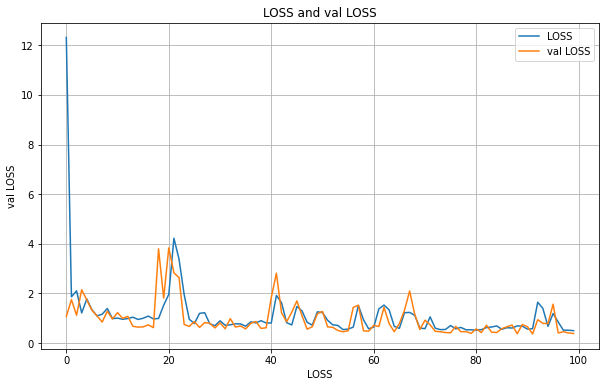

6/6 [==============================] - 0s 20ms/step


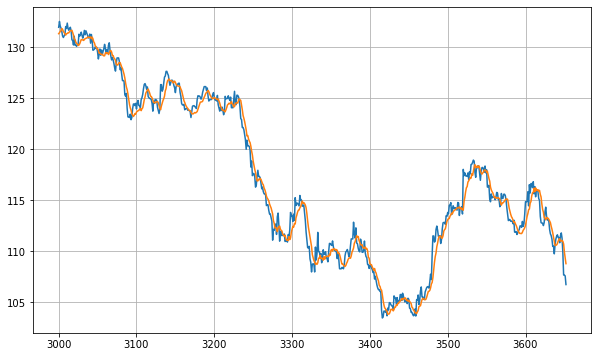

{'mae': 0.73467284, 'mse': 0.90878665, 'rmse': 0.95330304, 'mape': 0.63329965, 'mase': 1.6852564}
Model: "2_model_GBP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
___________________

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 3s 86ms/step - loss: 5559.6758 - mae: 5560.1758 - val_loss: 1184.5854 - val_mae: 1185.0854
Epoch 2/100
17/24 [====================>.........] - ETA: 0s - loss: 570.1757 - mae: 570.6753

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 65ms/step - loss: 508.5048 - mae: 509.0044 - val_loss: 346.6978 - val_mae: 347.1978
Epoch 3/100
17/24 [====================>.........] - ETA: 0s - loss: 313.6447 - mae: 314.1443

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 65ms/step - loss: 298.0215 - mae: 298.5210 - val_loss: 264.0567 - val_mae: 264.5567
Epoch 4/100
17/24 [====================>.........] - ETA: 0s - loss: 289.7576 - mae: 290.2570

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 66ms/step - loss: 280.5870 - mae: 281.0860 - val_loss: 189.8473 - val_mae: 190.3473
Epoch 5/100
24/24 [==============================] - 1s 20ms/step - loss: 267.5090 - mae: 268.0085 - val_loss: 198.8992 - val_mae: 199.3977
Epoch 6/100
24/24 [==============================] - 1s 20ms/step - loss: 254.2584 - mae: 254.7583 - val_loss: 227.1856 - val_mae: 227.6850
Epoch 7/100
24/24 [==============================] - 1s 23ms/step - loss: 250.9209 - mae: 251.4208 - val_loss: 191.7276 - val_mae: 192.2271
Epoch 8/100
17/24 [====================>.........] - ETA: 0s - loss: 252.4968 - mae: 252.9967

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 71ms/step - loss: 246.8052 - mae: 247.3052 - val_loss: 187.7295 - val_mae: 188.2290
Epoch 9/100
24/24 [==============================] - 1s 19ms/step - loss: 268.7171 - mae: 269.2163 - val_loss: 277.0314 - val_mae: 277.5313
Epoch 10/100
17/24 [====================>.........] - ETA: 0s - loss: 285.7417 - mae: 286.2413

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 67ms/step - loss: 268.6458 - mae: 269.1451 - val_loss: 175.6928 - val_mae: 176.1922
Epoch 11/100
24/24 [==============================] - 1s 19ms/step - loss: 259.4941 - mae: 259.9936 - val_loss: 301.0004 - val_mae: 301.5004
Epoch 12/100
24/24 [==============================] - 1s 20ms/step - loss: 260.1341 - mae: 260.6333 - val_loss: 350.1598 - val_mae: 350.6598
Epoch 13/100
24/24 [==============================] - 1s 19ms/step - loss: 251.8357 - mae: 252.3351 - val_loss: 301.0896 - val_mae: 301.5896
Epoch 14/100
24/24 [==============================] - 1s 19ms/step - loss: 270.9678 - mae: 271.4676 - val_loss: 274.1463 - val_mae: 274.6463
Epoch 15/100
17/24 [====================>.........] - ETA: 0s - loss: 225.1198 - mae: 225.6196

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 74ms/step - loss: 218.0849 - mae: 218.5844 - val_loss: 161.4352 - val_mae: 161.9349
Epoch 16/100
24/24 [==============================] - 1s 19ms/step - loss: 236.3388 - mae: 236.8382 - val_loss: 272.9561 - val_mae: 273.4556
Epoch 17/100
24/24 [==============================] - 1s 20ms/step - loss: 226.3250 - mae: 226.8245 - val_loss: 175.1771 - val_mae: 175.6768
Epoch 18/100
24/24 [==============================] - 1s 19ms/step - loss: 224.2491 - mae: 224.7482 - val_loss: 180.4771 - val_mae: 180.9771
Epoch 19/100
24/24 [==============================] - 1s 20ms/step - loss: 207.9220 - mae: 208.4212 - val_loss: 259.3265 - val_mae: 259.8264
Epoch 20/100
24/24 [==============================] - 1s 20ms/step - loss: 211.8949 - mae: 212.3947 - val_loss: 202.9529 - val_mae: 203.4526
Epoch 21/100
24/24 [==============================] - 1s 20ms/step - loss: 206.8315 - mae: 207.3307 - val_loss: 240.9497 - val_mae: 241.4492
Epoch 22/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 66ms/step - loss: 272.8202 - mae: 273.3200 - val_loss: 151.8040 - val_mae: 152.3028
Epoch 27/100
24/24 [==============================] - 1s 21ms/step - loss: 278.6790 - mae: 279.1789 - val_loss: 186.7583 - val_mae: 187.2577
Epoch 28/100
24/24 [==============================] - 1s 20ms/step - loss: 216.5846 - mae: 217.0844 - val_loss: 211.8958 - val_mae: 212.3951
Epoch 29/100
17/24 [====================>.........] - ETA: 0s - loss: 198.5842 - mae: 199.0831

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 64ms/step - loss: 194.8948 - mae: 195.3937 - val_loss: 137.0570 - val_mae: 137.5569
Epoch 30/100
24/24 [==============================] - 1s 19ms/step - loss: 190.4055 - mae: 190.9049 - val_loss: 206.8928 - val_mae: 207.3923
Epoch 31/100
24/24 [==============================] - 1s 19ms/step - loss: 259.1759 - mae: 259.6758 - val_loss: 295.4864 - val_mae: 295.9864
Epoch 32/100
24/24 [==============================] - 1s 19ms/step - loss: 218.2166 - mae: 218.7164 - val_loss: 188.6862 - val_mae: 189.1856
Epoch 33/100
24/24 [==============================] - 1s 20ms/step - loss: 179.4403 - mae: 179.9391 - val_loss: 257.4342 - val_mae: 257.9341
Epoch 34/100
24/24 [==============================] - 1s 20ms/step - loss: 270.2215 - mae: 270.7212 - val_loss: 241.4113 - val_mae: 241.9108
Epoch 35/100
24/24 [==============================] - 1s 20ms/step - loss: 243.4607 - mae: 243.9602 - val_loss: 161.5195 - val_mae: 162.0184
Epoch 36/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 66ms/step - loss: 254.9589 - mae: 255.4581 - val_loss: 132.9467 - val_mae: 133.4456
Epoch 40/100
24/24 [==============================] - 1s 20ms/step - loss: 169.3556 - mae: 169.8548 - val_loss: 253.2466 - val_mae: 253.7466
Epoch 41/100
24/24 [==============================] - 1s 20ms/step - loss: 188.7119 - mae: 189.2111 - val_loss: 133.3189 - val_mae: 133.8189
Epoch 42/100
24/24 [==============================] - 1s 20ms/step - loss: 164.1257 - mae: 164.6251 - val_loss: 206.9930 - val_mae: 207.4926
Epoch 43/100
24/24 [==============================] - 1s 20ms/step - loss: 236.3235 - mae: 236.8233 - val_loss: 337.2681 - val_mae: 337.7681
Epoch 44/100
24/24 [==============================] - 1s 20ms/step - loss: 287.1372 - mae: 287.6370 - val_loss: 258.3288 - val_mae: 258.8288
Epoch 45/100
24/24 [==============================] - 1s 20ms/step - loss: 257.1508 - mae: 257.6508 - val_loss: 265.8448 - val_mae: 266.3448
Epoch 46/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 64ms/step - loss: 179.7661 - mae: 180.2654 - val_loss: 124.6014 - val_mae: 125.1013
Epoch 51/100
24/24 [==============================] - 1s 19ms/step - loss: 169.6538 - mae: 170.1526 - val_loss: 140.2643 - val_mae: 140.7639
Epoch 52/100
24/24 [==============================] - 1s 19ms/step - loss: 168.6926 - mae: 169.1920 - val_loss: 181.7184 - val_mae: 182.2177
Epoch 53/100
24/24 [==============================] - 1s 19ms/step - loss: 258.6368 - mae: 259.1367 - val_loss: 179.1076 - val_mae: 179.6072
Epoch 54/100
24/24 [==============================] - 1s 19ms/step - loss: 176.8798 - mae: 177.3797 - val_loss: 229.3828 - val_mae: 229.8826
Epoch 55/100
24/24 [==============================] - 1s 19ms/step - loss: 170.0957 - mae: 170.5952 - val_loss: 132.7335 - val_mae: 133.2327
Epoch 56/100
24/24 [==============================] - 1s 19ms/step - loss: 188.3326 - mae: 188.8321 - val_loss: 159.6891 - val_mae: 160.1886
Epoch 57/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 71ms/step - loss: 176.1368 - mae: 176.6365 - val_loss: 120.5174 - val_mae: 121.0158
Epoch 62/100
17/24 [====================>.........] - ETA: 0s - loss: 180.1321 - mae: 180.6313

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 65ms/step - loss: 171.0036 - mae: 171.5030 - val_loss: 116.8603 - val_mae: 117.3598
Epoch 63/100
24/24 [==============================] - 1s 20ms/step - loss: 151.4903 - mae: 151.9898 - val_loss: 144.9540 - val_mae: 145.4532
Epoch 64/100
24/24 [==============================] - 1s 23ms/step - loss: 155.0909 - mae: 155.5899 - val_loss: 118.7699 - val_mae: 119.2689
Epoch 65/100
24/24 [==============================] - 1s 20ms/step - loss: 145.6376 - mae: 146.1368 - val_loss: 132.0414 - val_mae: 132.5398
Epoch 66/100
17/24 [====================>.........] - ETA: 0s - loss: 174.4855 - mae: 174.9853

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 63ms/step - loss: 177.9093 - mae: 178.4091 - val_loss: 116.2033 - val_mae: 116.7022
Epoch 67/100
24/24 [==============================] - 1s 20ms/step - loss: 218.3261 - mae: 218.8255 - val_loss: 194.1952 - val_mae: 194.6947
Epoch 68/100
24/24 [==============================] - 1s 20ms/step - loss: 152.2413 - mae: 152.7407 - val_loss: 138.6442 - val_mae: 139.1433
Epoch 69/100
24/24 [==============================] - 1s 19ms/step - loss: 164.2412 - mae: 164.7406 - val_loss: 184.4489 - val_mae: 184.9489
Epoch 70/100
24/24 [==============================] - 1s 19ms/step - loss: 146.1500 - mae: 146.6488 - val_loss: 122.4020 - val_mae: 122.9017
Epoch 71/100
24/24 [==============================] - 1s 19ms/step - loss: 170.7695 - mae: 171.2685 - val_loss: 184.2302 - val_mae: 184.7300
Epoch 72/100
24/24 [==============================] - 1s 19ms/step - loss: 159.0794 - mae: 159.5782 - val_loss: 161.4791 - val_mae: 161.9788
Epoch 73/100
24/24 [======

INFO:tensorflow:Assets written to: saved_model/14\assets


INFO:tensorflow:Assets written to: saved_model/14\assets


24/24 [==============================] - 2s 65ms/step - loss: 138.8756 - mae: 139.3744 - val_loss: 109.8020 - val_mae: 110.3004
Epoch 97/100
24/24 [==============================] - 1s 20ms/step - loss: 172.2373 - mae: 172.7369 - val_loss: 166.7850 - val_mae: 167.2838
Epoch 98/100
24/24 [==============================] - 1s 20ms/step - loss: 195.7940 - mae: 196.2932 - val_loss: 194.1700 - val_mae: 194.6700
Epoch 99/100
24/24 [==============================] - 1s 20ms/step - loss: 151.7616 - mae: 152.2609 - val_loss: 246.5691 - val_mae: 247.0690
Epoch 100/100
5/5 [==============================] - 0s 10ms/step - loss: 281.6776 - mae: 282.1776


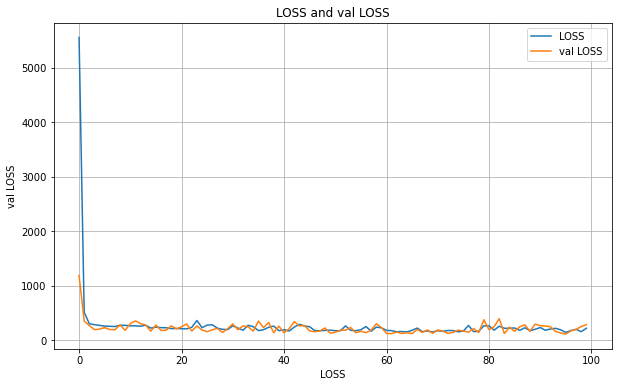

6/6 [==============================] - 0s 20ms/step


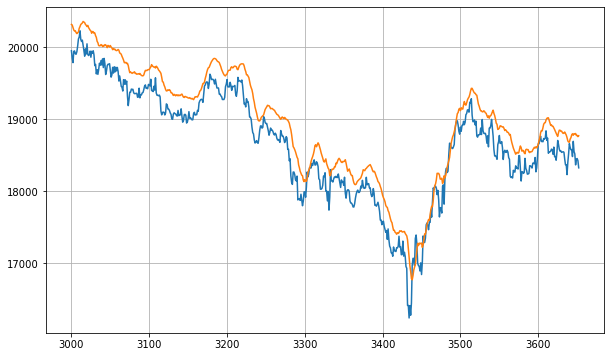

{'mae': 283.0125, 'mse': 97030.875, 'rmse': 311.4978, 'mape': 1.522387, 'mase': 4.322409}
Model: "2_model_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
___________________________

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 3s 75ms/step - loss: 1837.2114 - mae: 1837.7114 - val_loss: 87.2147 - val_mae: 87.7142
Epoch 2/100
24/24 [==============================] - 1s 20ms/step - loss: 185.2180 - mae: 185.7174 - val_loss: 162.6940 - val_mae: 163.1940
Epoch 3/100
24/24 [==============================] - 1s 20ms/step - loss: 118.0610 - mae: 118.5602 - val_loss: 98.6491 - val_mae: 99.1469
Epoch 4/100
16/24 [===================>..........] - ETA: 0s - loss: 92.6836 - mae: 93.1816

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 73ms/step - loss: 93.4391 - mae: 93.9374 - val_loss: 72.0440 - val_mae: 72.5439
Epoch 5/100
24/24 [==============================] - 1s 20ms/step - loss: 124.4963 - mae: 124.9956 - val_loss: 99.4468 - val_mae: 99.9462
Epoch 6/100
24/24 [==============================] - 1s 20ms/step - loss: 133.3788 - mae: 133.8782 - val_loss: 203.8693 - val_mae: 204.3693
Epoch 7/100
24/24 [==============================] - 1s 19ms/step - loss: 128.0320 - mae: 128.5316 - val_loss: 154.9091 - val_mae: 155.4091
Epoch 8/100
24/24 [==============================] - 1s 19ms/step - loss: 109.9798 - mae: 110.4788 - val_loss: 79.4809 - val_mae: 79.9793
Epoch 9/100
16/24 [===================>..........] - ETA: 0s - loss: 87.5185 - mae: 88.0174

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 64ms/step - loss: 87.8629 - mae: 88.3617 - val_loss: 67.8420 - val_mae: 68.3399
Epoch 10/100
24/24 [==============================] - 1s 20ms/step - loss: 133.2746 - mae: 133.7736 - val_loss: 77.5340 - val_mae: 78.0305
Epoch 11/100
24/24 [==============================] - 1s 22ms/step - loss: 162.4297 - mae: 162.9292 - val_loss: 269.3922 - val_mae: 269.8922
Epoch 12/100
24/24 [==============================] - 1s 20ms/step - loss: 141.3615 - mae: 141.8606 - val_loss: 156.6513 - val_mae: 157.1513
Epoch 13/100
24/24 [==============================] - 1s 19ms/step - loss: 120.8206 - mae: 121.3201 - val_loss: 73.3585 - val_mae: 73.8577
Epoch 14/100
24/24 [==============================] - 1s 20ms/step - loss: 120.0120 - mae: 120.5118 - val_loss: 112.5788 - val_mae: 113.0777
Epoch 15/100
24/24 [==============================] - 1s 20ms/step - loss: 104.6274 - mae: 105.1263 - val_loss: 78.6581 - val_mae: 79.1564
Epoch 16/100
24/24 [================

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 65ms/step - loss: 82.8575 - mae: 83.3557 - val_loss: 63.1792 - val_mae: 63.6768
Epoch 19/100
17/24 [====================>.........] - ETA: 0s - loss: 81.6766 - mae: 82.1751

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 65ms/step - loss: 81.2028 - mae: 81.7016 - val_loss: 63.1576 - val_mae: 63.6566
Epoch 20/100
17/24 [====================>.........] - ETA: 0s - loss: 81.4894 - mae: 81.9878

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 64ms/step - loss: 82.2458 - mae: 82.7442 - val_loss: 60.9204 - val_mae: 61.4193
Epoch 21/100
24/24 [==============================] - 1s 20ms/step - loss: 81.4784 - mae: 81.9764 - val_loss: 80.6649 - val_mae: 81.1643
Epoch 22/100
24/24 [==============================] - 1s 19ms/step - loss: 92.5768 - mae: 93.0754 - val_loss: 126.4508 - val_mae: 126.9500
Epoch 23/100
24/24 [==============================] - 1s 19ms/step - loss: 158.7944 - mae: 159.2936 - val_loss: 147.3435 - val_mae: 147.8427
Epoch 24/100
24/24 [==============================] - 1s 20ms/step - loss: 142.7587 - mae: 143.2582 - val_loss: 143.3956 - val_mae: 143.8953
Epoch 25/100
24/24 [==============================] - 1s 20ms/step - loss: 113.6272 - mae: 114.1261 - val_loss: 65.9909 - val_mae: 66.4890
Epoch 26/100
24/24 [==============================] - 1s 20ms/step - loss: 86.0603 - mae: 86.5594 - val_loss: 63.7414 - val_mae: 64.2413
Epoch 27/100
16/24 [===================>..

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 65ms/step - loss: 82.7338 - mae: 83.2320 - val_loss: 58.4339 - val_mae: 58.9315
Epoch 28/100
24/24 [==============================] - 1s 19ms/step - loss: 85.3838 - mae: 85.8824 - val_loss: 98.3029 - val_mae: 98.8021
Epoch 29/100
24/24 [==============================] - 1s 20ms/step - loss: 132.2222 - mae: 132.7218 - val_loss: 119.0575 - val_mae: 119.5570
Epoch 30/100
24/24 [==============================] - 1s 20ms/step - loss: 129.2938 - mae: 129.7936 - val_loss: 246.3607 - val_mae: 246.8607
Epoch 31/100
24/24 [==============================] - 1s 20ms/step - loss: 177.4864 - mae: 177.9857 - val_loss: 152.4732 - val_mae: 152.9730
Epoch 32/100
24/24 [==============================] - 1s 20ms/step - loss: 125.0865 - mae: 125.5861 - val_loss: 86.8549 - val_mae: 87.3547
Epoch 33/100
24/24 [==============================] - 1s 20ms/step - loss: 82.5019 - mae: 83.0004 - val_loss: 113.5607 - val_mae: 114.0606
Epoch 34/100
24/24 [==================

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 65ms/step - loss: 111.9494 - mae: 112.4481 - val_loss: 56.2776 - val_mae: 56.7738
Epoch 49/100
24/24 [==============================] - 1s 19ms/step - loss: 78.9329 - mae: 79.4311 - val_loss: 62.8679 - val_mae: 63.3658
Epoch 50/100
24/24 [==============================] - 1s 19ms/step - loss: 70.5576 - mae: 71.0556 - val_loss: 142.2747 - val_mae: 142.7747
Epoch 51/100
24/24 [==============================] - 1s 19ms/step - loss: 123.9452 - mae: 124.4448 - val_loss: 133.6189 - val_mae: 134.1189
Epoch 52/100
24/24 [==============================] - 1s 20ms/step - loss: 113.1370 - mae: 113.6361 - val_loss: 156.1630 - val_mae: 156.6630
Epoch 53/100
24/24 [==============================] - 1s 20ms/step - loss: 85.5600 - mae: 86.0585 - val_loss: 109.3279 - val_mae: 109.8273
Epoch 54/100
16/24 [===================>..........] - ETA: 0s - loss: 87.4911 - mae: 87.9896

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 74ms/step - loss: 82.6910 - mae: 83.1893 - val_loss: 54.2857 - val_mae: 54.7835
Epoch 55/100
24/24 [==============================] - 1s 19ms/step - loss: 111.8586 - mae: 112.3580 - val_loss: 109.7438 - val_mae: 110.2437
Epoch 56/100
24/24 [==============================] - 1s 22ms/step - loss: 95.6202 - mae: 96.1197 - val_loss: 99.3512 - val_mae: 99.8504
Epoch 57/100
24/24 [==============================] - 1s 20ms/step - loss: 93.2064 - mae: 93.7051 - val_loss: 94.7255 - val_mae: 95.2254
Epoch 58/100
24/24 [==============================] - 1s 20ms/step - loss: 96.5314 - mae: 97.0307 - val_loss: 86.9520 - val_mae: 87.4516
Epoch 59/100
24/24 [==============================] - 1s 23ms/step - loss: 67.4742 - mae: 67.9725 - val_loss: 54.4176 - val_mae: 54.9149
Epoch 60/100
16/24 [===================>..........] - ETA: 0s - loss: 70.3715 - mae: 70.8698

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 66ms/step - loss: 71.3164 - mae: 71.8148 - val_loss: 50.1605 - val_mae: 50.6589
Epoch 61/100
24/24 [==============================] - 1s 20ms/step - loss: 66.1863 - mae: 66.6846 - val_loss: 112.3968 - val_mae: 112.8968
Epoch 62/100
24/24 [==============================] - 1s 20ms/step - loss: 122.7702 - mae: 123.2698 - val_loss: 95.5106 - val_mae: 96.0093
Epoch 63/100
24/24 [==============================] - 1s 20ms/step - loss: 115.3696 - mae: 115.8685 - val_loss: 79.9512 - val_mae: 80.4490
Epoch 64/100
24/24 [==============================] - 1s 20ms/step - loss: 69.0836 - mae: 69.5817 - val_loss: 51.0647 - val_mae: 51.5621
Epoch 65/100
24/24 [==============================] - 1s 22ms/step - loss: 69.6220 - mae: 70.1207 - val_loss: 61.0610 - val_mae: 61.5592
Epoch 66/100
24/24 [==============================] - 1s 23ms/step - loss: 74.7631 - mae: 75.2615 - val_loss: 176.5289 - val_mae: 177.0289
Epoch 67/100
24/24 [==========================

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 64ms/step - loss: 92.7073 - mae: 93.2064 - val_loss: 47.8177 - val_mae: 48.3155
Epoch 83/100
24/24 [==============================] - 1s 20ms/step - loss: 61.8228 - mae: 62.3209 - val_loss: 146.3841 - val_mae: 146.8841
Epoch 84/100
24/24 [==============================] - 1s 20ms/step - loss: 113.9576 - mae: 114.4564 - val_loss: 113.2077 - val_mae: 113.7065
Epoch 85/100
24/24 [==============================] - 1s 20ms/step - loss: 102.5786 - mae: 103.0783 - val_loss: 116.1337 - val_mae: 116.6337
Epoch 86/100
24/24 [==============================] - 1s 20ms/step - loss: 99.1480 - mae: 99.6471 - val_loss: 68.5358 - val_mae: 69.0339
Epoch 87/100
24/24 [==============================] - 1s 20ms/step - loss: 89.0772 - mae: 89.5758 - val_loss: 79.7451 - val_mae: 80.2442
Epoch 88/100
24/24 [==============================] - 1s 20ms/step - loss: 96.3567 - mae: 96.8560 - val_loss: 62.0630 - val_mae: 62.5621
Epoch 89/100
24/24 [========================

INFO:tensorflow:Assets written to: saved_model/15\assets


INFO:tensorflow:Assets written to: saved_model/15\assets


24/24 [==============================] - 2s 65ms/step - loss: 59.0798 - mae: 59.5774 - val_loss: 47.2820 - val_mae: 47.7804
Epoch 97/100
24/24 [==============================] - 1s 20ms/step - loss: 54.6926 - mae: 55.1903 - val_loss: 61.1599 - val_mae: 61.6592
Epoch 98/100
24/24 [==============================] - 1s 20ms/step - loss: 58.3398 - mae: 58.8376 - val_loss: 53.9197 - val_mae: 54.4169
Epoch 99/100
24/24 [==============================] - 1s 20ms/step - loss: 60.2561 - mae: 60.7543 - val_loss: 75.4937 - val_mae: 75.9927
Epoch 100/100
5/5 [==============================] - 0s 10ms/step - loss: 137.6142 - mae: 138.1142


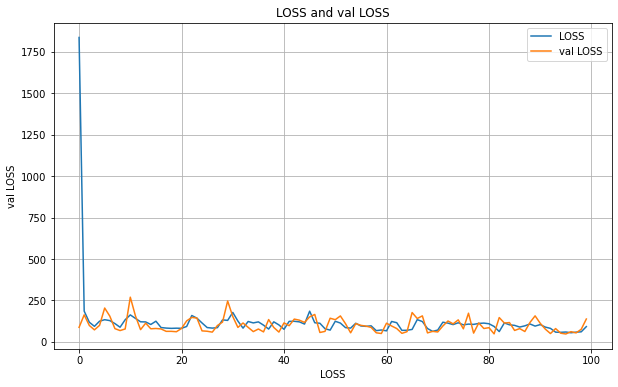

6/6 [==============================] - 0s 20ms/step


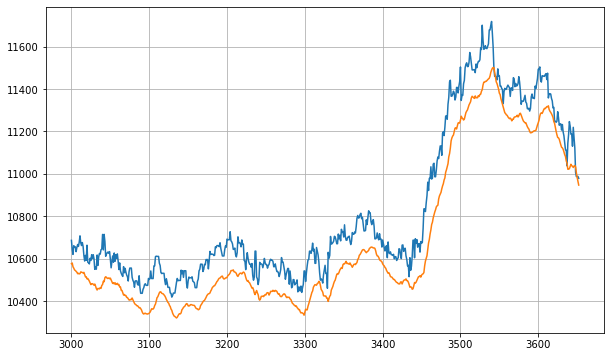

{'mae': 136.9087, 'mse': 21732.76, 'rmse': 147.42035, 'mape': 1.2625232, 'mase': 5.797153}
Model: "2_model_AUD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
__________________________

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 3s 85ms/step - loss: 1665.6038 - mae: 1666.1035 - val_loss: 146.1015 - val_mae: 146.6007
Epoch 2/100
24/24 [==============================] - 1s 20ms/step - loss: 171.4666 - mae: 171.9660 - val_loss: 166.2342 - val_mae: 166.7334
Epoch 3/100
24/24 [==============================] - 1s 19ms/step - loss: 218.2132 - mae: 218.7129 - val_loss: 202.6187 - val_mae: 203.1177
Epoch 4/100
24/24 [==============================] - 1s 19ms/step - loss: 237.8828 - mae: 238.3826 - val_loss: 217.1102 - val_mae: 217.6102
Epoch 5/100
24/24 [==============================] - 1s 19ms/step - loss: 210.9854 - mae: 211.4851 - val_loss: 273.4916 - val_mae: 273.9916
Epoch 6/100
17/24 [====================>.........] - ETA: 0s - loss: 135.8724 - mae: 136.3711

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 65ms/step - loss: 128.1109 - mae: 128.6098 - val_loss: 127.6862 - val_mae: 128.1839
Epoch 7/100
24/24 [==============================] - 1s 19ms/step - loss: 115.5784 - mae: 116.0771 - val_loss: 133.9610 - val_mae: 134.4595
Epoch 8/100
17/24 [====================>.........] - ETA: 0s - loss: 125.6428 - mae: 126.1421

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 65ms/step - loss: 127.5763 - mae: 128.0758 - val_loss: 107.8931 - val_mae: 108.3922
Epoch 9/100
24/24 [==============================] - 1s 20ms/step - loss: 128.7129 - mae: 129.2118 - val_loss: 147.2372 - val_mae: 147.7371
Epoch 10/100
24/24 [==============================] - 1s 20ms/step - loss: 240.3725 - mae: 240.8723 - val_loss: 165.8942 - val_mae: 166.3934
Epoch 11/100
24/24 [==============================] - 1s 20ms/step - loss: 135.9465 - mae: 136.4459 - val_loss: 187.8501 - val_mae: 188.3497
Epoch 12/100
24/24 [==============================] - 1s 20ms/step - loss: 128.0434 - mae: 128.5429 - val_loss: 122.9751 - val_mae: 123.4740
Epoch 13/100
24/24 [==============================] - 1s 20ms/step - loss: 159.9887 - mae: 160.4882 - val_loss: 410.9203 - val_mae: 411.4203
Epoch 14/100
24/24 [==============================] - 1s 22ms/step - loss: 242.1772 - mae: 242.6769 - val_loss: 346.3125 - val_mae: 346.8125
Epoch 15/100
17/24 [=======

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 65ms/step - loss: 157.4543 - mae: 157.9538 - val_loss: 104.3193 - val_mae: 104.8180
Epoch 16/100
24/24 [==============================] - 1s 19ms/step - loss: 138.2995 - mae: 138.7988 - val_loss: 313.5512 - val_mae: 314.0512
Epoch 17/100
24/24 [==============================] - 1s 19ms/step - loss: 140.2738 - mae: 140.7731 - val_loss: 142.8532 - val_mae: 143.3522
Epoch 18/100
24/24 [==============================] - 1s 19ms/step - loss: 185.9445 - mae: 186.4439 - val_loss: 179.5114 - val_mae: 180.0109
Epoch 19/100
24/24 [==============================] - 1s 19ms/step - loss: 170.6859 - mae: 171.1853 - val_loss: 201.3893 - val_mae: 201.8892
Epoch 20/100
17/24 [====================>.........] - ETA: 0s - loss: 143.0173 - mae: 143.5165

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 64ms/step - loss: 134.1873 - mae: 134.6864 - val_loss: 99.9803 - val_mae: 100.4796
Epoch 21/100
17/24 [====================>.........] - ETA: 0s - loss: 112.1745 - mae: 112.6732

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 65ms/step - loss: 110.0259 - mae: 110.5244 - val_loss: 99.0062 - val_mae: 99.5050
Epoch 22/100
16/24 [===================>..........] - ETA: 0s - loss: 103.2873 - mae: 103.7865

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 73ms/step - loss: 102.1073 - mae: 102.6064 - val_loss: 96.2225 - val_mae: 96.7220
Epoch 23/100
24/24 [==============================] - 1s 19ms/step - loss: 107.3173 - mae: 107.8161 - val_loss: 101.5876 - val_mae: 102.0865
Epoch 24/100
24/24 [==============================] - 1s 19ms/step - loss: 127.4621 - mae: 127.9612 - val_loss: 238.3844 - val_mae: 238.8844
Epoch 25/100
24/24 [==============================] - 1s 19ms/step - loss: 166.8368 - mae: 167.3363 - val_loss: 100.3852 - val_mae: 100.8839
Epoch 26/100
24/24 [==============================] - 1s 19ms/step - loss: 98.1797 - mae: 98.6785 - val_loss: 196.0897 - val_mae: 196.5897
Epoch 27/100
24/24 [==============================] - 1s 19ms/step - loss: 190.4297 - mae: 190.9297 - val_loss: 156.8471 - val_mae: 157.3471
Epoch 28/100
24/24 [==============================] - 1s 22ms/step - loss: 157.6451 - mae: 158.1446 - val_loss: 108.3195 - val_mae: 108.8186
Epoch 29/100
24/24 [==========

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 63ms/step - loss: 129.6776 - mae: 130.1767 - val_loss: 95.3139 - val_mae: 95.8131
Epoch 33/100
24/24 [==============================] - 1s 20ms/step - loss: 100.8396 - mae: 101.3380 - val_loss: 123.1313 - val_mae: 123.6291
Epoch 34/100
24/24 [==============================] - 1s 20ms/step - loss: 134.1207 - mae: 134.6200 - val_loss: 229.0692 - val_mae: 229.5692
Epoch 35/100
24/24 [==============================] - 1s 20ms/step - loss: 169.0629 - mae: 169.5625 - val_loss: 188.1161 - val_mae: 188.6152
Epoch 36/100
24/24 [==============================] - 1s 20ms/step - loss: 111.8320 - mae: 112.3313 - val_loss: 214.0901 - val_mae: 214.5894
Epoch 37/100
16/24 [===================>..........] - ETA: 0s - loss: 125.3494 - mae: 125.8485

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 64ms/step - loss: 114.1574 - mae: 114.6564 - val_loss: 92.4186 - val_mae: 92.9177
Epoch 38/100
24/24 [==============================] - 1s 20ms/step - loss: 91.0985 - mae: 91.5979 - val_loss: 106.9298 - val_mae: 107.4288
Epoch 39/100
16/24 [===================>..........] - ETA: 0s - loss: 111.1918 - mae: 111.6907

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 65ms/step - loss: 100.6785 - mae: 101.1770 - val_loss: 92.1194 - val_mae: 92.6182
Epoch 40/100
24/24 [==============================] - 1s 20ms/step - loss: 94.0040 - mae: 94.5030 - val_loss: 97.8361 - val_mae: 98.3352
Epoch 41/100
17/24 [====================>.........] - ETA: 0s - loss: 99.1665 - mae: 99.6656 

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 64ms/step - loss: 99.1660 - mae: 99.6647 - val_loss: 86.5828 - val_mae: 87.0821
Epoch 42/100
24/24 [==============================] - 1s 20ms/step - loss: 89.3918 - mae: 89.8911 - val_loss: 101.5198 - val_mae: 102.0189
Epoch 43/100
16/24 [===================>..........] - ETA: 0s - loss: 89.0909 - mae: 89.5903

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 64ms/step - loss: 89.2865 - mae: 89.7857 - val_loss: 84.5364 - val_mae: 85.0325
Epoch 44/100
16/24 [===================>..........] - ETA: 0s - loss: 84.7335 - mae: 85.2320

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 72ms/step - loss: 89.9002 - mae: 90.3989 - val_loss: 83.4957 - val_mae: 83.9951
Epoch 45/100
24/24 [==============================] - 1s 20ms/step - loss: 163.2195 - mae: 163.7194 - val_loss: 195.3549 - val_mae: 195.8549
Epoch 46/100
24/24 [==============================] - 1s 20ms/step - loss: 175.4717 - mae: 175.9710 - val_loss: 257.2974 - val_mae: 257.7974
Epoch 47/100
24/24 [==============================] - 1s 20ms/step - loss: 135.7365 - mae: 136.2359 - val_loss: 492.8554 - val_mae: 493.3554
Epoch 48/100
24/24 [==============================] - 1s 20ms/step - loss: 180.2733 - mae: 180.7723 - val_loss: 172.6179 - val_mae: 173.1170
Epoch 49/100
24/24 [==============================] - 1s 20ms/step - loss: 93.2778 - mae: 93.7767 - val_loss: 198.5388 - val_mae: 199.0388
Epoch 50/100
24/24 [==============================] - 1s 19ms/step - loss: 175.3560 - mae: 175.8552 - val_loss: 101.7361 - val_mae: 102.2344
Epoch 51/100
24/24 [============

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 64ms/step - loss: 86.5928 - mae: 87.0915 - val_loss: 81.2076 - val_mae: 81.7053
Epoch 62/100
24/24 [==============================] - 1s 20ms/step - loss: 83.2111 - mae: 83.7102 - val_loss: 94.7626 - val_mae: 95.2620
Epoch 63/100
15/24 [=================>............] - ETA: 0s - loss: 96.7905 - mae: 97.2898

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 65ms/step - loss: 119.7752 - mae: 120.2745 - val_loss: 78.8676 - val_mae: 79.3664
Epoch 64/100
24/24 [==============================] - 1s 20ms/step - loss: 115.6014 - mae: 116.1003 - val_loss: 169.7065 - val_mae: 170.2065
Epoch 65/100
24/24 [==============================] - 1s 20ms/step - loss: 159.2336 - mae: 159.7333 - val_loss: 139.4690 - val_mae: 139.9689
Epoch 66/100
24/24 [==============================] - 1s 21ms/step - loss: 99.5893 - mae: 100.0883 - val_loss: 80.9241 - val_mae: 81.4215
Epoch 67/100
24/24 [==============================] - 1s 20ms/step - loss: 91.5825 - mae: 92.0816 - val_loss: 79.5910 - val_mae: 80.0899
Epoch 68/100
24/24 [==============================] - 1s 21ms/step - loss: 134.0800 - mae: 134.5792 - val_loss: 92.5434 - val_mae: 93.0426
Epoch 69/100
24/24 [==============================] - 1s 20ms/step - loss: 118.5631 - mae: 119.0618 - val_loss: 154.5507 - val_mae: 155.0503
Epoch 70/100
24/24 [=================

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 65ms/step - loss: 76.4891 - mae: 76.9871 - val_loss: 76.1188 - val_mae: 76.6169
Epoch 77/100
17/24 [====================>.........] - ETA: 0s - loss: 84.7296 - mae: 85.2289

INFO:tensorflow:Assets written to: saved_model/16\assets


INFO:tensorflow:Assets written to: saved_model/16\assets


24/24 [==============================] - 2s 64ms/step - loss: 87.8588 - mae: 88.3576 - val_loss: 75.1220 - val_mae: 75.6211
Epoch 78/100
24/24 [==============================] - 1s 20ms/step - loss: 78.2618 - mae: 78.7603 - val_loss: 87.5780 - val_mae: 88.0764
Epoch 79/100
24/24 [==============================] - 1s 20ms/step - loss: 92.9253 - mae: 93.4241 - val_loss: 99.4108 - val_mae: 99.9090
Epoch 80/100
24/24 [==============================] - 1s 20ms/step - loss: 82.9289 - mae: 83.4273 - val_loss: 101.9645 - val_mae: 102.4634
Epoch 81/100
24/24 [==============================] - 1s 20ms/step - loss: 83.5220 - mae: 84.0199 - val_loss: 87.7262 - val_mae: 88.2249
Epoch 82/100
24/24 [==============================] - 1s 20ms/step - loss: 131.2253 - mae: 131.7238 - val_loss: 105.0486 - val_mae: 105.5481
Epoch 83/100
24/24 [==============================] - 1s 19ms/step - loss: 155.4217 - mae: 155.9210 - val_loss: 102.0029 - val_mae: 102.5018
Epoch 84/100
24/24 [========================

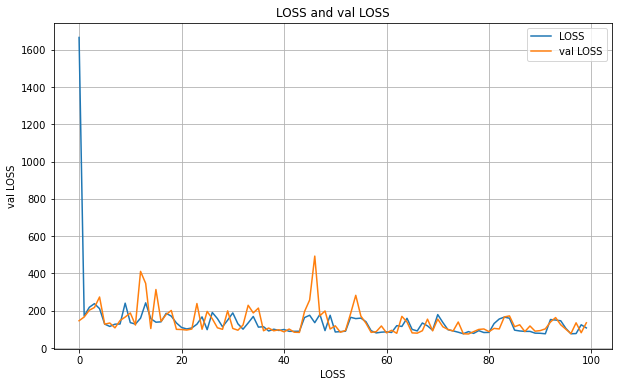

6/6 [==============================] - 0s 23ms/step


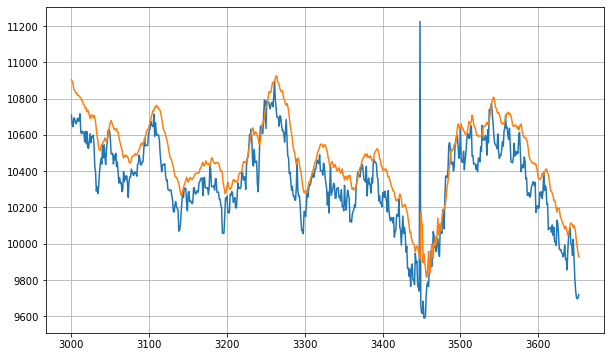

{'mae': 136.51315, 'mse': 27237.375, 'rmse': 165.03749, 'mape': 1.3264067, 'mase': 2.8931568}
Model: "2_model_CNY"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_______________________

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 4s 89ms/step - loss: 270.7621 - mae: 271.2614 - val_loss: 54.9787 - val_mae: 55.4783
Epoch 2/100
17/24 [====================>.........] - ETA: 0s - loss: 39.4315 - mae: 39.9295

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 64ms/step - loss: 36.6304 - mae: 37.1280 - val_loss: 24.5946 - val_mae: 25.0909
Epoch 3/100
16/24 [===================>..........] - ETA: 0s - loss: 21.3388 - mae: 21.8323

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 65ms/step - loss: 21.4961 - mae: 21.9899 - val_loss: 23.7741 - val_mae: 24.2711
Epoch 4/100
24/24 [==============================] - 1s 20ms/step - loss: 38.7599 - mae: 39.2575 - val_loss: 38.6709 - val_mae: 39.1693
Epoch 5/100
24/24 [==============================] - 1s 19ms/step - loss: 39.1942 - mae: 39.6927 - val_loss: 44.8957 - val_mae: 45.3952
Epoch 6/100
17/24 [====================>.........] - ETA: 0s - loss: 20.4890 - mae: 20.9826

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 65ms/step - loss: 20.5559 - mae: 21.0496 - val_loss: 17.4946 - val_mae: 17.9889
Epoch 7/100
24/24 [==============================] - 1s 19ms/step - loss: 20.7268 - mae: 21.2214 - val_loss: 23.1196 - val_mae: 23.6156
Epoch 8/100
17/24 [====================>.........] - ETA: 0s - loss: 29.4950 - mae: 29.9918

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 65ms/step - loss: 27.1476 - mae: 27.6442 - val_loss: 15.1489 - val_mae: 15.6431
Epoch 9/100
17/24 [====================>.........] - ETA: 0s - loss: 20.8934 - mae: 21.3886

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 65ms/step - loss: 20.7090 - mae: 21.2041 - val_loss: 13.7285 - val_mae: 14.2205
Epoch 10/100
24/24 [==============================] - 1s 19ms/step - loss: 24.3905 - mae: 24.8859 - val_loss: 71.5050 - val_mae: 72.0050
Epoch 11/100
24/24 [==============================] - 1s 19ms/step - loss: 39.4370 - mae: 39.9352 - val_loss: 24.6276 - val_mae: 25.1235
Epoch 12/100
24/24 [==============================] - 1s 20ms/step - loss: 34.2984 - mae: 34.7972 - val_loss: 16.9472 - val_mae: 17.4419
Epoch 13/100
24/24 [==============================] - 1s 20ms/step - loss: 39.3744 - mae: 39.8716 - val_loss: 47.7759 - val_mae: 48.2756
Epoch 14/100
24/24 [==============================] - 1s 20ms/step - loss: 32.0472 - mae: 32.5453 - val_loss: 16.7216 - val_mae: 17.2174
Epoch 15/100
24/24 [==============================] - 1s 20ms/step - loss: 28.3193 - mae: 28.8173 - val_loss: 45.2349 - val_mae: 45.7334
Epoch 16/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 74ms/step - loss: 39.3773 - mae: 39.8759 - val_loss: 13.4819 - val_mae: 13.9739
Epoch 25/100
24/24 [==============================] - 1s 20ms/step - loss: 18.1449 - mae: 18.6367 - val_loss: 14.2616 - val_mae: 14.7550
Epoch 26/100
24/24 [==============================] - 1s 20ms/step - loss: 21.7903 - mae: 22.2852 - val_loss: 32.3916 - val_mae: 32.8899
Epoch 27/100
24/24 [==============================] - 1s 20ms/step - loss: 23.1430 - mae: 23.6387 - val_loss: 20.2193 - val_mae: 20.7155
Epoch 28/100
17/24 [====================>.........] - ETA: 0s - loss: 23.0931 - mae: 23.5886

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 67ms/step - loss: 23.2496 - mae: 23.7452 - val_loss: 12.7753 - val_mae: 13.2640
Epoch 29/100
24/24 [==============================] - 1s 19ms/step - loss: 16.2150 - mae: 16.7066 - val_loss: 13.7596 - val_mae: 14.2503
Epoch 30/100
17/24 [====================>.........] - ETA: 0s - loss: 16.1664 - mae: 16.6584

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 64ms/step - loss: 16.5234 - mae: 17.0156 - val_loss: 12.4747 - val_mae: 12.9640
Epoch 31/100
24/24 [==============================] - 1s 19ms/step - loss: 16.6812 - mae: 17.1742 - val_loss: 13.0113 - val_mae: 13.5020
Epoch 32/100
24/24 [==============================] - 1s 19ms/step - loss: 24.7864 - mae: 25.2843 - val_loss: 20.0582 - val_mae: 20.5546
Epoch 33/100
17/24 [====================>.........] - ETA: 0s - loss: 17.1315 - mae: 17.6248

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 64ms/step - loss: 16.6432 - mae: 17.1356 - val_loss: 12.3797 - val_mae: 12.8661
Epoch 34/100
24/24 [==============================] - 1s 22ms/step - loss: 15.0957 - mae: 15.5880 - val_loss: 12.6394 - val_mae: 13.1302
Epoch 35/100
24/24 [==============================] - 1s 20ms/step - loss: 23.2772 - mae: 23.7731 - val_loss: 24.1603 - val_mae: 24.6575
Epoch 36/100
24/24 [==============================] - 1s 20ms/step - loss: 25.5132 - mae: 26.0111 - val_loss: 28.2212 - val_mae: 28.7199
Epoch 37/100
17/24 [====================>.........] - ETA: 0s - loss: 17.1078 - mae: 17.6010

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 65ms/step - loss: 18.1697 - mae: 18.6633 - val_loss: 11.7399 - val_mae: 12.2272
Epoch 38/100
24/24 [==============================] - 1s 19ms/step - loss: 15.5290 - mae: 16.0210 - val_loss: 11.8501 - val_mae: 12.3396
Epoch 39/100
24/24 [==============================] - 1s 19ms/step - loss: 22.4539 - mae: 22.9491 - val_loss: 43.6460 - val_mae: 44.1460
Epoch 40/100
24/24 [==============================] - 1s 19ms/step - loss: 27.4456 - mae: 27.9423 - val_loss: 15.7792 - val_mae: 16.2705
Epoch 41/100
24/24 [==============================] - 1s 20ms/step - loss: 25.2992 - mae: 25.7970 - val_loss: 26.3562 - val_mae: 26.8548
Epoch 42/100
24/24 [==============================] - 1s 19ms/step - loss: 23.8883 - mae: 24.3842 - val_loss: 44.6878 - val_mae: 45.1878
Epoch 43/100
16/24 [===================>..........] - ETA: 0s - loss: 25.6429 - mae: 26.1404

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 73ms/step - loss: 26.4238 - mae: 26.9214 - val_loss: 11.4246 - val_mae: 11.9130
Epoch 44/100
24/24 [==============================] - 1s 19ms/step - loss: 24.6602 - mae: 25.1569 - val_loss: 19.8335 - val_mae: 20.3313
Epoch 45/100
24/24 [==============================] - 1s 20ms/step - loss: 24.9644 - mae: 25.4610 - val_loss: 24.9926 - val_mae: 25.4902
Epoch 46/100
24/24 [==============================] - 1s 20ms/step - loss: 18.2466 - mae: 18.7405 - val_loss: 11.6832 - val_mae: 12.1752
Epoch 47/100
24/24 [==============================] - 1s 20ms/step - loss: 20.1151 - mae: 20.6090 - val_loss: 22.3279 - val_mae: 22.8240
Epoch 48/100
24/24 [==============================] - 1s 20ms/step - loss: 22.6789 - mae: 23.1752 - val_loss: 32.0914 - val_mae: 32.5898
Epoch 49/100
24/24 [==============================] - 1s 20ms/step - loss: 27.3790 - mae: 27.8765 - val_loss: 31.8410 - val_mae: 32.3395
Epoch 50/100
16/24 [===================>..........] - 

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 64ms/step - loss: 17.9053 - mae: 18.3983 - val_loss: 11.2710 - val_mae: 11.7622
Epoch 51/100
24/24 [==============================] - 1s 20ms/step - loss: 21.6332 - mae: 22.1286 - val_loss: 25.0333 - val_mae: 25.5326
Epoch 52/100
24/24 [==============================] - 1s 20ms/step - loss: 20.7979 - mae: 21.2928 - val_loss: 29.7858 - val_mae: 30.2845
Epoch 53/100
24/24 [==============================] - 1s 20ms/step - loss: 23.9318 - mae: 24.4293 - val_loss: 17.2587 - val_mae: 17.7535
Epoch 54/100
24/24 [==============================] - 1s 20ms/step - loss: 21.0520 - mae: 21.5474 - val_loss: 27.7507 - val_mae: 28.2498
Epoch 55/100
24/24 [==============================] - 1s 20ms/step - loss: 22.7557 - mae: 23.2533 - val_loss: 19.9690 - val_mae: 20.4636
Epoch 56/100
16/24 [===================>..........] - ETA: 0s - loss: 15.5124 - mae: 16.0044

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 64ms/step - loss: 15.2814 - mae: 15.7738 - val_loss: 11.1562 - val_mae: 11.6476
Epoch 57/100
24/24 [==============================] - 1s 20ms/step - loss: 14.0204 - mae: 14.5106 - val_loss: 23.4973 - val_mae: 23.9946
Epoch 58/100
24/24 [==============================] - 1s 20ms/step - loss: 14.5520 - mae: 15.0446 - val_loss: 22.2720 - val_mae: 22.7697
Epoch 59/100
24/24 [==============================] - 1s 19ms/step - loss: 23.8677 - mae: 24.3643 - val_loss: 34.3361 - val_mae: 34.8354
Epoch 60/100
24/24 [==============================] - 1s 20ms/step - loss: 25.0313 - mae: 25.5298 - val_loss: 18.7689 - val_mae: 19.2627
Epoch 61/100
24/24 [==============================] - 1s 20ms/step - loss: 23.3718 - mae: 23.8691 - val_loss: 27.6735 - val_mae: 28.1728
Epoch 62/100
24/24 [==============================] - 1s 22ms/step - loss: 23.1026 - mae: 23.5998 - val_loss: 17.9198 - val_mae: 18.4167
Epoch 63/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 63ms/step - loss: 20.1466 - mae: 20.6406 - val_loss: 10.5494 - val_mae: 11.0365
Epoch 69/100
24/24 [==============================] - 1s 20ms/step - loss: 12.6640 - mae: 13.1541 - val_loss: 11.3794 - val_mae: 11.8707
Epoch 70/100
24/24 [==============================] - 1s 20ms/step - loss: 13.4758 - mae: 13.9661 - val_loss: 16.0875 - val_mae: 16.5822
Epoch 71/100
24/24 [==============================] - 1s 20ms/step - loss: 14.5937 - mae: 15.0855 - val_loss: 28.3776 - val_mae: 28.8774
Epoch 72/100
24/24 [==============================] - 1s 20ms/step - loss: 24.5014 - mae: 24.9997 - val_loss: 48.9527 - val_mae: 49.4527
Epoch 73/100
16/24 [===================>..........] - ETA: 0s - loss: 22.5715 - mae: 23.0652

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 65ms/step - loss: 19.5277 - mae: 20.0202 - val_loss: 10.2087 - val_mae: 10.6987
Epoch 74/100
24/24 [==============================] - 1s 20ms/step - loss: 17.6205 - mae: 18.1124 - val_loss: 64.1290 - val_mae: 64.6290
Epoch 75/100
24/24 [==============================] - 1s 20ms/step - loss: 39.5284 - mae: 40.0268 - val_loss: 21.1524 - val_mae: 21.6486
Epoch 76/100
24/24 [==============================] - 1s 20ms/step - loss: 15.4283 - mae: 15.9219 - val_loss: 15.3358 - val_mae: 15.8297
Epoch 77/100
24/24 [==============================] - 1s 20ms/step - loss: 12.9750 - mae: 13.4656 - val_loss: 10.5811 - val_mae: 11.0711
Epoch 78/100
24/24 [==============================] - 1s 20ms/step - loss: 13.1724 - mae: 13.6627 - val_loss: 13.4126 - val_mae: 13.9070
Epoch 79/100
16/24 [===================>..........] - ETA: 0s - loss: 14.3097 - mae: 14.8023

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 64ms/step - loss: 14.9189 - mae: 15.4124 - val_loss: 9.8830 - val_mae: 10.3721
Epoch 80/100
24/24 [==============================] - 1s 20ms/step - loss: 24.7199 - mae: 25.2181 - val_loss: 22.7751 - val_mae: 23.2729
Epoch 81/100
24/24 [==============================] - 1s 19ms/step - loss: 24.5902 - mae: 25.0880 - val_loss: 24.9822 - val_mae: 25.4809
Epoch 82/100
24/24 [==============================] - 1s 19ms/step - loss: 24.2694 - mae: 24.7679 - val_loss: 29.9571 - val_mae: 30.4565
Epoch 83/100
24/24 [==============================] - 1s 19ms/step - loss: 15.1545 - mae: 15.6450 - val_loss: 10.7474 - val_mae: 11.2395
Epoch 84/100
24/24 [==============================] - 1s 19ms/step - loss: 18.0626 - mae: 18.5569 - val_loss: 16.7980 - val_mae: 17.2940
Epoch 85/100
24/24 [==============================] - 1s 19ms/step - loss: 13.8046 - mae: 14.2971 - val_loss: 18.0817 - val_mae: 18.5792
Epoch 86/100
24/24 [==============================] - 1

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 75ms/step - loss: 11.7856 - mae: 12.2752 - val_loss: 9.8634 - val_mae: 10.3560
Epoch 88/100
15/24 [=================>............] - ETA: 0s - loss: 14.3811 - mae: 14.8731

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 64ms/step - loss: 17.7235 - mae: 18.2163 - val_loss: 9.7301 - val_mae: 10.2195
Epoch 89/100
24/24 [==============================] - 1s 23ms/step - loss: 13.7476 - mae: 14.2398 - val_loss: 10.4816 - val_mae: 10.9753
Epoch 90/100
24/24 [==============================] - 1s 19ms/step - loss: 21.6336 - mae: 22.1306 - val_loss: 12.3894 - val_mae: 12.8822
Epoch 91/100
24/24 [==============================] - 1s 19ms/step - loss: 12.3624 - mae: 12.8527 - val_loss: 15.0896 - val_mae: 15.5829
Epoch 92/100
24/24 [==============================] - 1s 19ms/step - loss: 13.1558 - mae: 13.6463 - val_loss: 15.8141 - val_mae: 16.3089
Epoch 93/100
24/24 [==============================] - 1s 19ms/step - loss: 11.8483 - mae: 12.3384 - val_loss: 13.6038 - val_mae: 14.0992
Epoch 94/100
24/24 [==============================] - 1s 19ms/step - loss: 11.8104 - mae: 12.2994 - val_loss: 9.7740 - val_mae: 10.2653
Epoch 95/100
24/24 [==============================] - 1s

INFO:tensorflow:Assets written to: saved_model/17\assets


INFO:tensorflow:Assets written to: saved_model/17\assets


24/24 [==============================] - 2s 65ms/step - loss: 13.3029 - mae: 13.7949 - val_loss: 9.2854 - val_mae: 9.7738
Epoch 97/100
24/24 [==============================] - 1s 20ms/step - loss: 37.9293 - mae: 38.4262 - val_loss: 73.1596 - val_mae: 73.6596
Epoch 98/100
24/24 [==============================] - 1s 19ms/step - loss: 60.7910 - mae: 61.2895 - val_loss: 43.4294 - val_mae: 43.9294
Epoch 99/100
24/24 [==============================] - 1s 20ms/step - loss: 24.4408 - mae: 24.9371 - val_loss: 10.0353 - val_mae: 10.5248
Epoch 100/100
5/5 [==============================] - 0s 10ms/step - loss: 24.5299 - mae: 25.0278


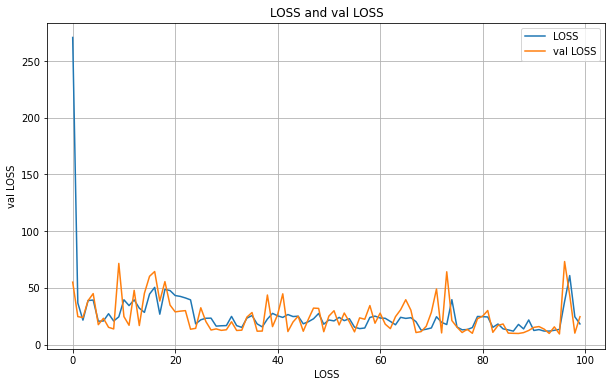

6/6 [==============================] - 0s 20ms/step


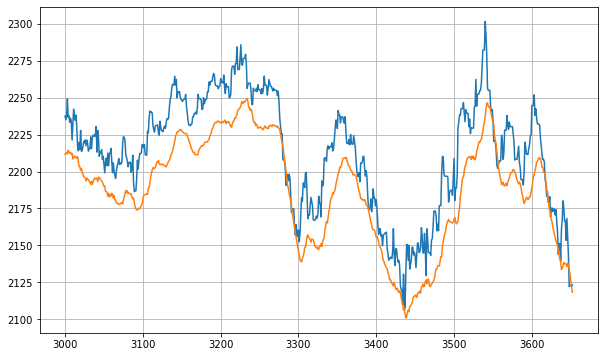

{'mae': 24.877268, 'mse': 773.41815, 'rmse': 27.810396, 'mape': 1.1214526, 'mase': 5.0699096}
Model: "2_model_CAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_______________________

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 3s 78ms/step - loss: 2764.4998 - mae: 2764.9998 - val_loss: 700.6879 - val_mae: 701.1879
Epoch 2/100
16/24 [===================>..........] - ETA: 0s - loss: 305.5381 - mae: 306.0376

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 65ms/step - loss: 254.2979 - mae: 254.7974 - val_loss: 98.5009 - val_mae: 98.9998
Epoch 3/100
24/24 [==============================] - 1s 20ms/step - loss: 142.3606 - mae: 142.8598 - val_loss: 106.4605 - val_mae: 106.9592
Epoch 4/100
16/24 [===================>..........] - ETA: 0s - loss: 134.2950 - mae: 134.7946

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 74ms/step - loss: 132.2058 - mae: 132.7052 - val_loss: 97.5128 - val_mae: 98.0121
Epoch 5/100
24/24 [==============================] - 1s 20ms/step - loss: 128.2011 - mae: 128.7003 - val_loss: 116.1750 - val_mae: 116.6741
Epoch 6/100
24/24 [==============================] - 1s 20ms/step - loss: 165.2530 - mae: 165.7525 - val_loss: 103.4374 - val_mae: 103.9363
Epoch 7/100
16/24 [===================>..........] - ETA: 0s - loss: 129.0718 - mae: 129.5713

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 127.7701 - mae: 128.2693 - val_loss: 92.7623 - val_mae: 93.2614
Epoch 8/100
24/24 [==============================] - 1s 20ms/step - loss: 132.6320 - mae: 133.1317 - val_loss: 112.8243 - val_mae: 113.3231
Epoch 9/100
24/24 [==============================] - 1s 19ms/step - loss: 130.7348 - mae: 131.2342 - val_loss: 94.6933 - val_mae: 95.1923
Epoch 10/100
24/24 [==============================] - 1s 19ms/step - loss: 122.4704 - mae: 122.9698 - val_loss: 95.4513 - val_mae: 95.9495
Epoch 11/100
24/24 [==============================] - 1s 19ms/step - loss: 129.1474 - mae: 129.6467 - val_loss: 177.5104 - val_mae: 178.0104
Epoch 12/100
24/24 [==============================] - 1s 22ms/step - loss: 179.5242 - mae: 180.0233 - val_loss: 256.5409 - val_mae: 257.0406
Epoch 13/100
24/24 [==============================] - 1s 20ms/step - loss: 192.5378 - mae: 193.0372 - val_loss: 166.0358 - val_mae: 166.5357
Epoch 14/100
24/24 [==============

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 115.7936 - mae: 116.2928 - val_loss: 88.3118 - val_mae: 88.8112
Epoch 16/100
24/24 [==============================] - 1s 20ms/step - loss: 150.2872 - mae: 150.7866 - val_loss: 326.6978 - val_mae: 327.1978
Epoch 17/100
24/24 [==============================] - 1s 20ms/step - loss: 164.6884 - mae: 165.1879 - val_loss: 97.0502 - val_mae: 97.5471
Epoch 18/100
17/24 [====================>.........] - ETA: 0s - loss: 107.8256 - mae: 108.3245

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 107.1624 - mae: 107.6613 - val_loss: 81.9931 - val_mae: 82.4920
Epoch 19/100
24/24 [==============================] - 1s 20ms/step - loss: 101.2768 - mae: 101.7760 - val_loss: 125.5298 - val_mae: 126.0290
Epoch 20/100
24/24 [==============================] - 1s 20ms/step - loss: 106.3562 - mae: 106.8547 - val_loss: 226.4857 - val_mae: 226.9856
Epoch 21/100
24/24 [==============================] - 1s 20ms/step - loss: 187.5293 - mae: 188.0289 - val_loss: 243.1715 - val_mae: 243.6715
Epoch 22/100
24/24 [==============================] - 1s 20ms/step - loss: 178.9081 - mae: 179.4078 - val_loss: 115.4293 - val_mae: 115.9293
Epoch 23/100
24/24 [==============================] - 1s 20ms/step - loss: 149.3556 - mae: 149.8551 - val_loss: 164.0383 - val_mae: 164.5383
Epoch 24/100
24/24 [==============================] - 1s 20ms/step - loss: 112.7491 - mae: 113.2480 - val_loss: 89.5595 - val_mae: 90.0594
Epoch 25/100
24/24 [==========

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 171.8777 - mae: 172.3775 - val_loss: 74.8466 - val_mae: 75.3462
Epoch 29/100
24/24 [==============================] - 1s 20ms/step - loss: 155.9416 - mae: 156.4412 - val_loss: 130.8948 - val_mae: 131.3947
Epoch 30/100
24/24 [==============================] - 1s 20ms/step - loss: 120.0516 - mae: 120.5508 - val_loss: 318.3564 - val_mae: 318.8564
Epoch 31/100
24/24 [==============================] - 1s 20ms/step - loss: 145.1063 - mae: 145.6054 - val_loss: 87.0793 - val_mae: 87.5784
Epoch 32/100
16/24 [===================>..........] - ETA: 0s - loss: 103.1657 - mae: 103.6647

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 99.7945 - mae: 100.2934 - val_loss: 71.0624 - val_mae: 71.5602
Epoch 33/100
24/24 [==============================] - 1s 20ms/step - loss: 125.7641 - mae: 126.2627 - val_loss: 100.1535 - val_mae: 100.6530
Epoch 34/100
15/24 [=================>............] - ETA: 0s - loss: 104.8130 - mae: 105.3119

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 78ms/step - loss: 101.6236 - mae: 102.1228 - val_loss: 70.4000 - val_mae: 70.8995
Epoch 35/100
24/24 [==============================] - 1s 21ms/step - loss: 93.6656 - mae: 94.1648 - val_loss: 71.3851 - val_mae: 71.8829
Epoch 36/100
16/24 [===================>..........] - ETA: 0s - loss: 89.4314 - mae: 89.9305

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 68ms/step - loss: 87.0338 - mae: 87.5330 - val_loss: 67.4095 - val_mae: 67.9081
Epoch 37/100
24/24 [==============================] - 1s 19ms/step - loss: 92.5794 - mae: 93.0787 - val_loss: 181.6882 - val_mae: 182.1881
Epoch 38/100
16/24 [===================>..........] - ETA: 0s - loss: 105.1310 - mae: 105.6291

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 101.1653 - mae: 101.6636 - val_loss: 65.1632 - val_mae: 65.6626
Epoch 39/100
24/24 [==============================] - 1s 19ms/step - loss: 84.5389 - mae: 85.0378 - val_loss: 70.3768 - val_mae: 70.8754
Epoch 40/100
17/24 [====================>.........] - ETA: 0s - loss: 84.0114 - mae: 84.5092

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 63ms/step - loss: 88.5404 - mae: 89.0384 - val_loss: 63.7422 - val_mae: 64.2390
Epoch 41/100
24/24 [==============================] - 1s 20ms/step - loss: 88.7921 - mae: 89.2904 - val_loss: 221.1969 - val_mae: 221.6961
Epoch 42/100
24/24 [==============================] - 1s 20ms/step - loss: 182.9248 - mae: 183.4245 - val_loss: 220.1837 - val_mae: 220.6833
Epoch 43/100
24/24 [==============================] - 1s 20ms/step - loss: 165.4802 - mae: 165.9796 - val_loss: 190.9161 - val_mae: 191.4161
Epoch 44/100
24/24 [==============================] - 1s 20ms/step - loss: 156.1165 - mae: 156.6159 - val_loss: 163.3127 - val_mae: 163.8127
Epoch 45/100
24/24 [==============================] - 1s 20ms/step - loss: 100.5283 - mae: 101.0267 - val_loss: 77.8477 - val_mae: 78.3460
Epoch 46/100
24/24 [==============================] - 1s 20ms/step - loss: 90.2914 - mae: 90.7903 - val_loss: 99.1984 - val_mae: 99.6980
Epoch 47/100
24/24 [==================

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 109.6199 - mae: 110.1186 - val_loss: 59.2258 - val_mae: 59.7234
Epoch 77/100
24/24 [==============================] - 1s 19ms/step - loss: 76.2080 - mae: 76.7068 - val_loss: 198.0180 - val_mae: 198.5175
Epoch 78/100
24/24 [==============================] - 1s 22ms/step - loss: 129.9149 - mae: 130.4143 - val_loss: 130.1629 - val_mae: 130.6628
Epoch 79/100
24/24 [==============================] - 1s 19ms/step - loss: 110.6015 - mae: 111.1009 - val_loss: 182.3568 - val_mae: 182.8568
Epoch 80/100
24/24 [==============================] - 1s 19ms/step - loss: 76.8975 - mae: 77.3963 - val_loss: 61.0484 - val_mae: 61.5467
Epoch 81/100
24/24 [==============================] - 1s 19ms/step - loss: 109.5887 - mae: 110.0876 - val_loss: 200.1906 - val_mae: 200.6899
Epoch 82/100
24/24 [==============================] - 1s 20ms/step - loss: 105.8305 - mae: 106.3290 - val_loss: 155.1725 - val_mae: 155.6725
Epoch 83/100
24/24 [==============

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 65ms/step - loss: 79.6038 - mae: 80.1024 - val_loss: 57.0219 - val_mae: 57.5187
Epoch 91/100
16/24 [===================>..........] - ETA: 0s - loss: 72.6777 - mae: 73.1763

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 72ms/step - loss: 72.2939 - mae: 72.7924 - val_loss: 56.6672 - val_mae: 57.1648
Epoch 92/100
16/24 [===================>..........] - ETA: 0s - loss: 75.0717 - mae: 75.5707

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 64ms/step - loss: 77.4736 - mae: 77.9723 - val_loss: 56.4530 - val_mae: 56.9520
Epoch 93/100
24/24 [==============================] - 1s 19ms/step - loss: 69.3351 - mae: 69.8339 - val_loss: 91.7864 - val_mae: 92.2857
Epoch 94/100
24/24 [==============================] - 1s 20ms/step - loss: 109.3341 - mae: 109.8332 - val_loss: 138.6944 - val_mae: 139.1944
Epoch 95/100
24/24 [==============================] - 1s 20ms/step - loss: 84.9158 - mae: 85.4144 - val_loss: 65.7979 - val_mae: 66.2967
Epoch 96/100
24/24 [==============================] - 1s 20ms/step - loss: 80.6314 - mae: 81.1302 - val_loss: 119.7280 - val_mae: 120.2267
Epoch 97/100
16/24 [===================>..........] - ETA: 0s - loss: 121.1080 - mae: 121.6071

INFO:tensorflow:Assets written to: saved_model/18\assets


INFO:tensorflow:Assets written to: saved_model/18\assets


24/24 [==============================] - 2s 67ms/step - loss: 112.3966 - mae: 112.8955 - val_loss: 56.4249 - val_mae: 56.9195
Epoch 98/100
24/24 [==============================] - 1s 19ms/step - loss: 78.1652 - mae: 78.6640 - val_loss: 147.0948 - val_mae: 147.5948
Epoch 99/100
24/24 [==============================] - 1s 20ms/step - loss: 102.7691 - mae: 103.2678 - val_loss: 106.3986 - val_mae: 106.8979
Epoch 100/100
5/5 [==============================] - 0s 11ms/step - loss: 56.9190 - mae: 57.4154


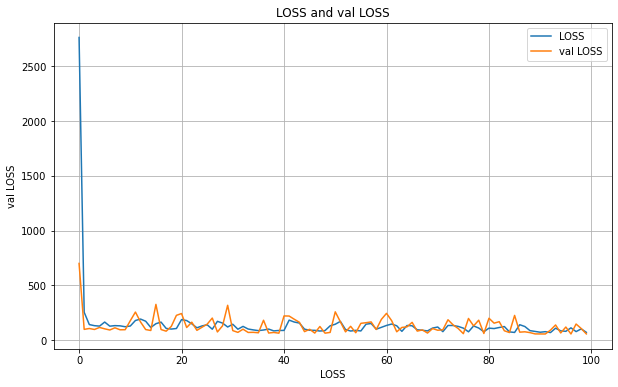

6/6 [==============================] - 0s 21ms/step


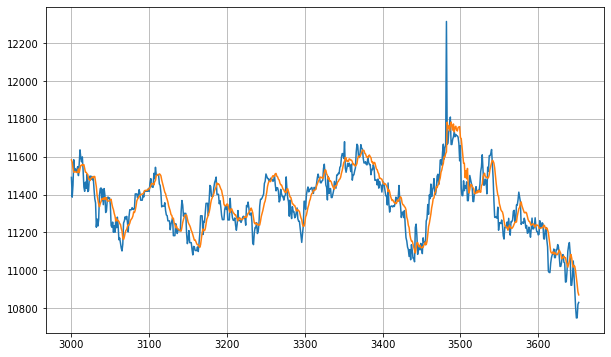

{'mae': 57.024586, 'mse': 5886.5986, 'rmse': 76.724174, 'mape': 0.5029392, 'mase': 1.5878785}
Model: "2_model_MYR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_______________________

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 3s 75ms/step - loss: 336.6201 - mae: 337.1198 - val_loss: 135.1132 - val_mae: 135.6132
Epoch 2/100
15/24 [=================>............] - ETA: 0s - loss: 102.1946 - mae: 102.6941

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 3s 108ms/step - loss: 95.1284 - mae: 95.6280 - val_loss: 98.7497 - val_mae: 99.2496
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 55.6901 - mae: 56.1890

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 2s 95ms/step - loss: 55.6901 - mae: 56.1890 - val_loss: 41.1565 - val_mae: 41.6547
Epoch 4/100
24/24 [==============================] - 1s 24ms/step - loss: 39.6308 - mae: 40.1273 - val_loss: 82.1606 - val_mae: 82.6603
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 49.7691 - mae: 50.2667 - val_loss: 81.1192 - val_mae: 81.6190
Epoch 6/100
20/24 [========================>.....] - ETA: 0s - loss: 49.8192 - mae: 50.3173

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 2s 71ms/step - loss: 48.2492 - mae: 48.7474 - val_loss: 24.7064 - val_mae: 25.2005
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 36.2360 - mae: 36.7321 - val_loss: 36.5377 - val_mae: 37.0372
Epoch 8/100
24/24 [==============================] - 1s 23ms/step - loss: 41.7455 - mae: 42.2424 - val_loss: 42.3517 - val_mae: 42.8517
Epoch 9/100
24/24 [==============================] - 1s 24ms/step - loss: 39.9415 - mae: 40.4391 - val_loss: 28.1794 - val_mae: 28.6781
Epoch 10/100
24/24 [==============================] - 1s 21ms/step - loss: 33.9360 - mae: 34.4319 - val_loss: 35.5531 - val_mae: 36.0513
Epoch 11/100
24/24 [==============================] - 1s 20ms/step - loss: 35.1883 - mae: 35.6858 - val_loss: 67.1376 - val_mae: 67.6376
Epoch 12/100
24/24 [==============================] - 1s 20ms/step - loss: 69.7076 - mae: 70.2065 - val_loss: 61.6526 - val_mae: 62.1525
Epoch 13/100
24/24 [==============================] - 1s 

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 2s 63ms/step - loss: 30.9654 - mae: 31.4607 - val_loss: 19.9513 - val_mae: 20.4439
Epoch 21/100
24/24 [==============================] - 1s 20ms/step - loss: 28.2696 - mae: 28.7655 - val_loss: 24.9803 - val_mae: 25.4771
Epoch 22/100
24/24 [==============================] - 1s 20ms/step - loss: 28.0485 - mae: 28.5439 - val_loss: 22.5752 - val_mae: 23.0735
Epoch 23/100
16/24 [===================>..........] - ETA: 0s - loss: 44.7661 - mae: 45.2629

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 2s 64ms/step - loss: 54.3507 - mae: 54.8481 - val_loss: 16.9996 - val_mae: 17.4920
Epoch 24/100
24/24 [==============================] - 1s 20ms/step - loss: 53.0165 - mae: 53.5149 - val_loss: 61.7011 - val_mae: 62.2010
Epoch 25/100
24/24 [==============================] - 1s 20ms/step - loss: 53.7488 - mae: 54.2481 - val_loss: 56.8307 - val_mae: 57.3300
Epoch 26/100
24/24 [==============================] - 1s 23ms/step - loss: 36.2760 - mae: 36.7734 - val_loss: 98.8340 - val_mae: 99.3339
Epoch 27/100
24/24 [==============================] - 1s 20ms/step - loss: 52.4614 - mae: 52.9596 - val_loss: 26.6503 - val_mae: 27.1489
Epoch 28/100
24/24 [==============================] - 1s 20ms/step - loss: 48.1941 - mae: 48.6921 - val_loss: 76.8970 - val_mae: 77.3968
Epoch 29/100
24/24 [==============================] - 1s 20ms/step - loss: 37.3154 - mae: 37.8122 - val_loss: 24.8184 - val_mae: 25.3153
Epoch 30/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 2s 88ms/step - loss: 34.3114 - mae: 34.8075 - val_loss: 15.2311 - val_mae: 15.7241
Epoch 49/100
24/24 [==============================] - 1s 26ms/step - loss: 25.2183 - mae: 25.7141 - val_loss: 19.6999 - val_mae: 20.1948
Epoch 50/100
24/24 [==============================] - 1s 24ms/step - loss: 21.2317 - mae: 21.7257 - val_loss: 15.6372 - val_mae: 16.1286
Epoch 51/100
24/24 [==============================] - 1s 22ms/step - loss: 25.6871 - mae: 26.1834 - val_loss: 41.4599 - val_mae: 41.9593
Epoch 52/100
24/24 [==============================] - 1s 25ms/step - loss: 23.2625 - mae: 23.7572 - val_loss: 35.9970 - val_mae: 36.4957
Epoch 53/100
24/24 [==============================] - 1s 22ms/step - loss: 25.3278 - mae: 25.8231 - val_loss: 76.1571 - val_mae: 76.6571
Epoch 54/100
24/24 [==============================] - 1s 24ms/step - loss: 47.7699 - mae: 48.2687 - val_loss: 71.8998 - val_mae: 72.3998
Epoch 55/100
24/24 [==============================] - 

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 2s 70ms/step - loss: 36.8778 - mae: 37.3760 - val_loss: 14.6138 - val_mae: 15.1053
Epoch 77/100
24/24 [==============================] - 1s 22ms/step - loss: 20.8509 - mae: 21.3441 - val_loss: 21.7781 - val_mae: 22.2757
Epoch 78/100
24/24 [==============================] - 1s 28ms/step - loss: 30.5122 - mae: 31.0084 - val_loss: 40.6810 - val_mae: 41.1806
Epoch 79/100
24/24 [==============================] - 1s 22ms/step - loss: 38.9560 - mae: 39.4552 - val_loss: 14.9543 - val_mae: 15.4438
Epoch 80/100
24/24 [==============================] - 1s 24ms/step - loss: 24.3488 - mae: 24.8452 - val_loss: 15.5444 - val_mae: 16.0366
Epoch 81/100
16/24 [===================>..........] - ETA: 0s - loss: 20.6083 - mae: 21.1038

INFO:tensorflow:Assets written to: saved_model/19\assets


INFO:tensorflow:Assets written to: saved_model/19\assets


24/24 [==============================] - 2s 88ms/step - loss: 21.5117 - mae: 22.0077 - val_loss: 13.5176 - val_mae: 14.0096
Epoch 82/100
24/24 [==============================] - 1s 22ms/step - loss: 20.5741 - mae: 21.0683 - val_loss: 30.8223 - val_mae: 31.3212
Epoch 83/100
24/24 [==============================] - 1s 23ms/step - loss: 37.1723 - mae: 37.6693 - val_loss: 16.9089 - val_mae: 17.4017
Epoch 84/100
24/24 [==============================] - 1s 22ms/step - loss: 40.0845 - mae: 40.5832 - val_loss: 16.9959 - val_mae: 17.4903
Epoch 85/100
24/24 [==============================] - 1s 22ms/step - loss: 31.3263 - mae: 31.8234 - val_loss: 38.7676 - val_mae: 39.2674
Epoch 86/100
24/24 [==============================] - 1s 23ms/step - loss: 31.7153 - mae: 32.2122 - val_loss: 13.6394 - val_mae: 14.1334
Epoch 87/100
24/24 [==============================] - 1s 25ms/step - loss: 20.1867 - mae: 20.6809 - val_loss: 36.4457 - val_mae: 36.9449
Epoch 88/100
24/24 [==============================] - 

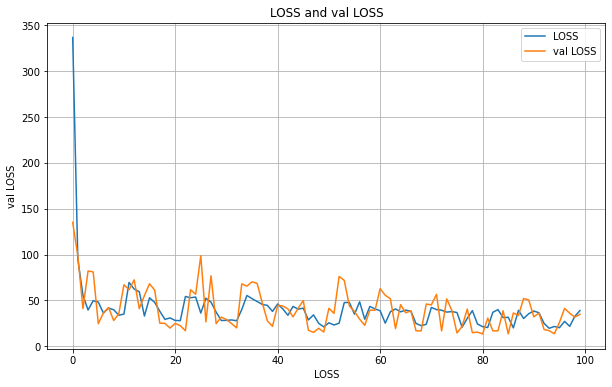

6/6 [==============================] - 0s 25ms/step


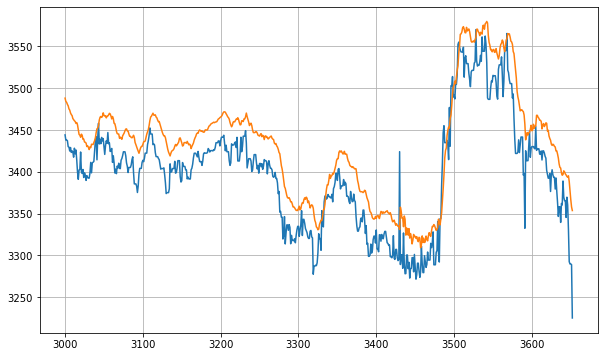

{'mae': 35.743267, 'mse': 1547.0121, 'rmse': 39.332073, 'mape': 1.0542467, 'mase': 4.023893}
Model: "2_model_RUB"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
________________________

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 4s 86ms/step - loss: 53.8574 - mae: 54.3526 - val_loss: 13.3061 - val_mae: 13.8041
Epoch 2/100
21/24 [=========================>....] - ETA: 0s - loss: 5.5984 - mae: 6.0756

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 73ms/step - loss: 5.4115 - mae: 5.8874 - val_loss: 10.1762 - val_mae: 10.6502
Epoch 3/100
20/24 [========================>.....] - ETA: 0s - loss: 5.6892 - mae: 6.1729

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 72ms/step - loss: 5.3772 - mae: 5.8589 - val_loss: 9.9677 - val_mae: 10.4495
Epoch 4/100
16/24 [===================>..........] - ETA: 0s - loss: 4.9264 - mae: 5.4000

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 4.3790 - mae: 4.8504 - val_loss: 9.9372 - val_mae: 10.4216
Epoch 5/100
15/24 [=================>............] - ETA: 0s - loss: 5.4096 - mae: 5.8879

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 85ms/step - loss: 4.5525 - mae: 5.0265 - val_loss: 9.7050 - val_mae: 10.1798
Epoch 6/100
24/24 [==============================] - 1s 23ms/step - loss: 4.0795 - mae: 4.5514 - val_loss: 10.1189 - val_mae: 10.6083
Epoch 7/100
24/24 [==============================] - 1s 23ms/step - loss: 5.7164 - mae: 6.1994 - val_loss: 9.9763 - val_mae: 10.4670
Epoch 8/100
16/24 [===================>..........] - ETA: 0s - loss: 4.8653 - mae: 5.3398

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 72ms/step - loss: 4.2378 - mae: 4.7092 - val_loss: 8.6045 - val_mae: 9.0813
Epoch 9/100
23/24 [===========================>..] - ETA: 0s - loss: 4.3834 - mae: 4.8600

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 73ms/step - loss: 4.3708 - mae: 4.8475 - val_loss: 8.4877 - val_mae: 8.9576
Epoch 10/100
24/24 [==============================] - 1s 22ms/step - loss: 4.2134 - mae: 4.6900 - val_loss: 10.7591 - val_mae: 11.2564
Epoch 11/100
24/24 [==============================] - 1s 22ms/step - loss: 5.3676 - mae: 5.8488 - val_loss: 8.5602 - val_mae: 9.0396
Epoch 12/100
19/24 [======================>.......] - ETA: 0s - loss: 4.2668 - mae: 4.7410

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 3.9496 - mae: 4.4210 - val_loss: 8.3928 - val_mae: 8.8732
Epoch 13/100
15/24 [=================>............] - ETA: 0s - loss: 4.6965 - mae: 5.1757

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 3.9163 - mae: 4.3890 - val_loss: 7.7816 - val_mae: 8.2514
Epoch 14/100
21/24 [=========================>....] - ETA: 0s - loss: 3.0350 - mae: 3.4975

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 73ms/step - loss: 2.9835 - mae: 3.4457 - val_loss: 7.4233 - val_mae: 7.8873
Epoch 15/100
15/24 [=================>............] - ETA: 0s - loss: 3.2781 - mae: 3.7445

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 81ms/step - loss: 3.0125 - mae: 3.4770 - val_loss: 7.1351 - val_mae: 7.5985
Epoch 16/100
24/24 [==============================] - 1s 23ms/step - loss: 2.9440 - mae: 3.4121 - val_loss: 8.7250 - val_mae: 9.2143
Epoch 17/100
24/24 [==============================] - 1s 23ms/step - loss: 4.9863 - mae: 5.4725 - val_loss: 9.0432 - val_mae: 9.5330
Epoch 18/100
24/24 [==============================] - 1s 22ms/step - loss: 3.3682 - mae: 3.8351 - val_loss: 7.3266 - val_mae: 7.8097
Epoch 19/100
16/24 [===================>..........] - ETA: 0s - loss: 3.0119 - mae: 3.4760

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.6824 - mae: 3.1421 - val_loss: 6.7560 - val_mae: 7.2153
Epoch 20/100
16/24 [===================>..........] - ETA: 0s - loss: 2.6315 - mae: 3.0874

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 73ms/step - loss: 2.5216 - mae: 2.9780 - val_loss: 6.5869 - val_mae: 7.0574
Epoch 21/100
16/24 [===================>..........] - ETA: 0s - loss: 2.6814 - mae: 3.1365

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.5102 - mae: 2.9673 - val_loss: 6.5035 - val_mae: 6.9742
Epoch 22/100
24/24 [==============================] - 1s 22ms/step - loss: 2.3781 - mae: 2.8367 - val_loss: 6.8435 - val_mae: 7.3235
Epoch 23/100
24/24 [==============================] - 1s 22ms/step - loss: 4.3668 - mae: 4.8488 - val_loss: 7.6577 - val_mae: 8.1466
Epoch 24/100
24/24 [==============================] - 1s 26ms/step - loss: 4.9057 - mae: 5.3907 - val_loss: 6.8856 - val_mae: 7.3667
Epoch 25/100
16/24 [===================>..........] - ETA: 0s - loss: 4.0718 - mae: 4.5494

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 73ms/step - loss: 3.4647 - mae: 3.9362 - val_loss: 6.4135 - val_mae: 6.8681
Epoch 26/100
16/24 [===================>..........] - ETA: 0s - loss: 3.7055 - mae: 4.1800

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 73ms/step - loss: 3.2237 - mae: 3.6940 - val_loss: 6.3537 - val_mae: 6.8073
Epoch 27/100
24/24 [==============================] - 1s 22ms/step - loss: 3.1782 - mae: 3.6486 - val_loss: 7.0005 - val_mae: 7.4807
Epoch 28/100
24/24 [==============================] - 1s 23ms/step - loss: 2.4531 - mae: 2.9132 - val_loss: 7.2468 - val_mae: 7.7308
Epoch 29/100
15/24 [=================>............] - ETA: 0s - loss: 2.8461 - mae: 3.3098

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 79ms/step - loss: 2.5763 - mae: 3.0369 - val_loss: 6.2346 - val_mae: 6.7015
Epoch 30/100
24/24 [==============================] - 1s 22ms/step - loss: 2.4098 - mae: 2.8689 - val_loss: 7.3220 - val_mae: 7.8096
Epoch 31/100
15/24 [=================>............] - ETA: 0s - loss: 2.7154 - mae: 3.1754

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.3871 - mae: 2.8426 - val_loss: 6.1269 - val_mae: 6.5873
Epoch 32/100
15/24 [=================>............] - ETA: 0s - loss: 2.3618 - mae: 2.8163

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.1557 - mae: 2.6054 - val_loss: 6.0963 - val_mae: 6.5571
Epoch 33/100
24/24 [==============================] - 1s 21ms/step - loss: 2.3930 - mae: 2.8501 - val_loss: 9.0286 - val_mae: 9.5228
Epoch 34/100
24/24 [==============================] - 1s 23ms/step - loss: 5.0570 - mae: 5.5451 - val_loss: 6.5432 - val_mae: 7.0134
Epoch 35/100
24/24 [==============================] - 1s 22ms/step - loss: 3.9582 - mae: 4.4348 - val_loss: 6.2542 - val_mae: 6.7131
Epoch 36/100
24/24 [==============================] - 1s 22ms/step - loss: 2.1157 - mae: 2.5664 - val_loss: 7.8468 - val_mae: 8.3401
Epoch 37/100
24/24 [==============================] - 1s 22ms/step - loss: 3.9276 - mae: 4.4083 - val_loss: 6.2330 - val_mae: 6.6929
Epoch 38/100
24/24 [==============================] - 1s 23ms/step - loss: 3.3358 - mae: 3.8099 - val_loss: 8.1844 - val_mae: 8.6775
Epoch 39/100
24/24 [==============================] - 1s 23ms/step - loss: 3.7054 

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.0068 - mae: 2.4552 - val_loss: 6.0628 - val_mae: 6.5170
Epoch 41/100
24/24 [==============================] - 1s 22ms/step - loss: 2.0099 - mae: 2.4593 - val_loss: 6.2207 - val_mae: 6.6973
Epoch 42/100
24/24 [==============================] - 1s 22ms/step - loss: 2.2572 - mae: 2.7140 - val_loss: 6.4071 - val_mae: 6.8869
Epoch 43/100
24/24 [==============================] - 1s 23ms/step - loss: 2.1217 - mae: 2.5753 - val_loss: 6.3083 - val_mae: 6.7853
Epoch 44/100
24/24 [==============================] - 1s 23ms/step - loss: 2.1209 - mae: 2.5757 - val_loss: 6.1217 - val_mae: 6.5968
Epoch 45/100
15/24 [=================>............] - ETA: 0s - loss: 2.0669 - mae: 2.5122

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 75ms/step - loss: 2.0422 - mae: 2.4906 - val_loss: 5.7970 - val_mae: 6.2479
Epoch 46/100
24/24 [==============================] - 1s 22ms/step - loss: 3.9276 - mae: 4.4129 - val_loss: 6.9564 - val_mae: 7.4369
Epoch 47/100
24/24 [==============================] - 1s 22ms/step - loss: 3.5456 - mae: 4.0248 - val_loss: 5.9458 - val_mae: 6.4015
Epoch 48/100
16/24 [===================>..........] - ETA: 0s - loss: 2.4257 - mae: 2.8837

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 70ms/step - loss: 2.2043 - mae: 2.6571 - val_loss: 5.7576 - val_mae: 6.2124
Epoch 49/100
16/24 [===================>..........] - ETA: 0s - loss: 1.9749 - mae: 2.4242

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 1.8489 - mae: 2.2956 - val_loss: 5.6952 - val_mae: 6.1538
Epoch 50/100
24/24 [==============================] - 1s 23ms/step - loss: 1.7988 - mae: 2.2393 - val_loss: 6.7073 - val_mae: 7.1903
Epoch 51/100
24/24 [==============================] - 1s 23ms/step - loss: 2.2109 - mae: 2.6690 - val_loss: 5.9597 - val_mae: 6.4334
Epoch 52/100
24/24 [==============================] - 1s 22ms/step - loss: 3.9493 - mae: 4.4330 - val_loss: 7.4752 - val_mae: 7.9613
Epoch 53/100
24/24 [==============================] - 1s 22ms/step - loss: 3.5902 - mae: 4.0755 - val_loss: 6.7758 - val_mae: 7.2599
Epoch 54/100
24/24 [==============================] - 1s 22ms/step - loss: 2.6944 - mae: 3.1546 - val_loss: 6.3995 - val_mae: 6.8831
Epoch 55/100
24/24 [==============================] - 1s 23ms/step - loss: 2.1058 - mae: 2.5561 - val_loss: 6.0610 - val_mae: 6.5339
Epoch 56/100
24/24 [==============================] - 1s 23ms/step - loss: 2.4644 

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 82ms/step - loss: 2.0470 - mae: 2.4992 - val_loss: 5.6707 - val_mae: 6.1313
Epoch 60/100
20/24 [========================>.....] - ETA: 0s - loss: 2.1752 - mae: 2.6301

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 72ms/step - loss: 2.1943 - mae: 2.6488 - val_loss: 5.6139 - val_mae: 6.0654
Epoch 61/100
24/24 [==============================] - 1s 23ms/step - loss: 1.9747 - mae: 2.4232 - val_loss: 5.6546 - val_mae: 6.1146
Epoch 62/100
15/24 [=================>............] - ETA: 0s - loss: 2.8137 - mae: 3.2778

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 72ms/step - loss: 2.3459 - mae: 2.8005 - val_loss: 5.6133 - val_mae: 6.0681
Epoch 63/100
24/24 [==============================] - 1s 21ms/step - loss: 1.9004 - mae: 2.3469 - val_loss: 5.6594 - val_mae: 6.1187
Epoch 64/100
24/24 [==============================] - 1s 22ms/step - loss: 3.4816 - mae: 3.9614 - val_loss: 5.6508 - val_mae: 6.1105
Epoch 65/100
20/24 [========================>.....] - ETA: 0s - loss: 3.0603 - mae: 3.5317

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 2.8959 - mae: 3.3637 - val_loss: 5.6078 - val_mae: 6.0589
Epoch 66/100
24/24 [==============================] - 1s 22ms/step - loss: 3.3055 - mae: 3.7841 - val_loss: 5.7016 - val_mae: 6.1616
Epoch 67/100
24/24 [==============================] - 1s 23ms/step - loss: 2.6508 - mae: 3.1185 - val_loss: 6.2533 - val_mae: 6.7372
Epoch 68/100
24/24 [==============================] - 1s 23ms/step - loss: 1.9718 - mae: 2.4205 - val_loss: 6.9361 - val_mae: 7.4223
Epoch 69/100
24/24 [==============================] - 1s 23ms/step - loss: 2.6727 - mae: 3.1423 - val_loss: 6.7191 - val_mae: 7.2061
Epoch 70/100
24/24 [==============================] - 1s 23ms/step - loss: 2.8510 - mae: 3.3164 - val_loss: 5.6422 - val_mae: 6.0959
Epoch 71/100
24/24 [==============================] - 1s 23ms/step - loss: 2.9461 - mae: 3.4189 - val_loss: 5.8728 - val_mae: 6.3444
Epoch 72/100
24/24 [==============================] - 1s 22ms/step - loss: 3.2118 

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 72ms/step - loss: 2.0172 - mae: 2.4650 - val_loss: 5.4987 - val_mae: 5.9498
Epoch 76/100
24/24 [==============================] - 1s 23ms/step - loss: 1.8410 - mae: 2.2889 - val_loss: 5.5084 - val_mae: 5.9660
Epoch 77/100
24/24 [==============================] - 1s 22ms/step - loss: 1.8461 - mae: 2.2895 - val_loss: 5.7766 - val_mae: 6.2498
Epoch 78/100
24/24 [==============================] - 1s 22ms/step - loss: 1.7884 - mae: 2.2336 - val_loss: 5.5306 - val_mae: 5.9900
Epoch 79/100
21/24 [=========================>....] - ETA: 0s - loss: 2.0625 - mae: 2.5167

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 80ms/step - loss: 2.0160 - mae: 2.4700 - val_loss: 5.4327 - val_mae: 5.8887
Epoch 80/100
24/24 [==============================] - 1s 22ms/step - loss: 1.6566 - mae: 2.0967 - val_loss: 5.4778 - val_mae: 5.9428
Epoch 81/100
24/24 [==============================] - 1s 22ms/step - loss: 2.0688 - mae: 2.5245 - val_loss: 5.7105 - val_mae: 6.1848
Epoch 82/100
24/24 [==============================] - 1s 22ms/step - loss: 3.2029 - mae: 3.6780 - val_loss: 6.4336 - val_mae: 6.9197
Epoch 83/100
24/24 [==============================] - 1s 23ms/step - loss: 1.8231 - mae: 2.2683 - val_loss: 5.7472 - val_mae: 6.2181
Epoch 84/100
24/24 [==============================] - 1s 23ms/step - loss: 1.7975 - mae: 2.2421 - val_loss: 5.5124 - val_mae: 5.9798
Epoch 85/100
15/24 [=================>............] - ETA: 0s - loss: 1.9362 - mae: 2.3811

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 71ms/step - loss: 1.8604 - mae: 2.3078 - val_loss: 5.3313 - val_mae: 5.7800
Epoch 86/100
24/24 [==============================] - 1s 22ms/step - loss: 1.5820 - mae: 2.0186 - val_loss: 5.7725 - val_mae: 6.2500
Epoch 87/100
15/24 [=================>............] - ETA: 0s - loss: 2.2156 - mae: 2.6736

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 82ms/step - loss: 1.9447 - mae: 2.3957 - val_loss: 5.3156 - val_mae: 5.7669
Epoch 88/100
24/24 [==============================] - 1s 21ms/step - loss: 1.6641 - mae: 2.1077 - val_loss: 5.5132 - val_mae: 5.9735
Epoch 89/100
24/24 [==============================] - 1s 21ms/step - loss: 1.8554 - mae: 2.3019 - val_loss: 5.3193 - val_mae: 5.7742
Epoch 90/100
16/24 [===================>..........] - ETA: 0s - loss: 2.0028 - mae: 2.4585

INFO:tensorflow:Assets written to: saved_model/20\assets


INFO:tensorflow:Assets written to: saved_model/20\assets


24/24 [==============================] - 2s 77ms/step - loss: 1.8577 - mae: 2.3084 - val_loss: 5.2791 - val_mae: 5.7263
Epoch 91/100
24/24 [==============================] - 1s 23ms/step - loss: 2.6984 - mae: 3.1672 - val_loss: 6.9784 - val_mae: 7.4707
Epoch 92/100
24/24 [==============================] - 1s 22ms/step - loss: 3.7857 - mae: 4.2737 - val_loss: 6.6670 - val_mae: 7.1573
Epoch 93/100
24/24 [==============================] - 1s 22ms/step - loss: 3.3069 - mae: 3.7884 - val_loss: 5.9742 - val_mae: 6.4540
Epoch 94/100
24/24 [==============================] - 1s 22ms/step - loss: 3.2835 - mae: 3.7566 - val_loss: 6.4611 - val_mae: 6.9406
Epoch 95/100
24/24 [==============================] - 1s 22ms/step - loss: 2.9847 - mae: 3.4624 - val_loss: 7.2537 - val_mae: 7.7422
Epoch 96/100
24/24 [==============================] - 1s 22ms/step - loss: 5.4306 - mae: 5.9186 - val_loss: 14.4590 - val_mae: 14.9572
Epoch 97/100
24/24 [==============================] - 1s 22ms/step - loss: 10.17

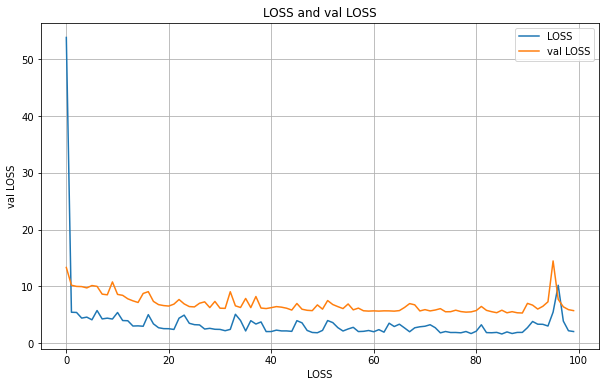

6/6 [==============================] - 0s 26ms/step


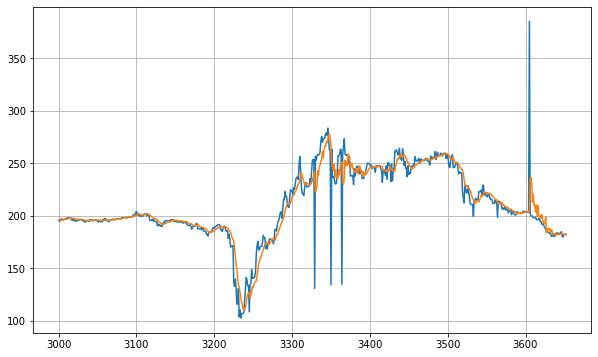

{'mae': 5.905442, 'mse': 185.39476, 'rmse': 13.615974, 'mape': 3.0340524, 'mase': 1.3366742}


In [22]:
count = 1
eval_models_2 = {}

for i in range(1,11):
    time, series, currency = open_file(i)

    split_time = 3000
    window_size = 30
    batch_size = 128
    shuffle_buffer_size = 1000

    train_set, valid_set = prepared_data(series, time, split_time, window_size, batch_size, shuffle_buffer_size)

    model = second_model(train_set, valid_set, window_size)

    evaluate_model(model, series, split_time, window_size, batch_size, count, eval_models_2, currency)

In [23]:
import pandas as pd
model_results = pd.DataFrame(eval_models_1).T
model_results.head(100)

,mae,mse,rmse,mape,mase
model_EUR/IDR,87.300713,11888.887695,109.036179,0.549009,1.686916
model_USD/IDR,73.637016,9413.188477,97.021591,0.498133,2.312330
model_JPY/IDR,0.994974,1.568864,1.252543,0.851578,2.282358
model_GBP/IDR,136.457108,29081.359375,170.532578,0.739896,2.084090
model_SGD/IDR,68.340332,6725.102051,82.006721,0.631561,2.893748
model_AUD/IDR,116.651825,22088.675781,148.622589,1.123588,2.472231
model_CNY/IDR,17.283560,418.081970,20.447052,0.779347,3.522336
model_CAD/IDR,109.719757,16304.589844,127.689430,0.969064,3.055202
model_MYR/IDR,15.046477,437.008911,20.904758,0.443143,1.693897
model_RUB/IDR,5.664382,198.310593,14.082279,2.893257,1.282111


In [24]:
import pandas as pd
model_results = pd.DataFrame(eval_models_2).T
model_results.head(100)

,mae,mse,rmse,mape,mase
model_EUR/IDR,93.990669,14753.978516,121.465958,0.591164,1.816187
model_USD/IDR,202.167114,48100.488281,219.318237,1.366080,6.348398
model_JPY/IDR,0.734673,0.908787,0.953303,0.633300,1.685256
model_GBP/IDR,283.012512,97030.875000,311.497803,1.522387,4.322409
model_SGD/IDR,136.908707,21732.759766,147.420349,1.262523,5.797153
model_AUD/IDR,136.513153,27237.375000,165.037491,1.326407,2.893157
model_CNY/IDR,24.877268,773.418152,27.810396,1.121453,5.069910
model_CAD/IDR,57.024586,5886.598633,76.724174,0.502939,1.587878
model_MYR/IDR,35.743267,1547.012085,39.332073,1.054247,4.023893
model_RUB/IDR,5.905442,185.394760,13.615974,3.034052,1.336674


In [106]:
# into_future = 30

# future_forecast = make_future_forecast(values=series,
#                                        model=model,
#                                        into_future=into_future,
#                                        window_size=window_size)

# next_time_steps = np.arange(time[-1] + 1, time[-1] + 1 + into_future)
# next_time_steps

# # Insert last timestep/final price into next time steps and future forecasts so the plot connects
# next_time_steps = np.insert(next_time_steps, 0, time[-1])
# future_forecast = np.insert(future_forecast, 0, series[-1])

# plt.figure(figsize=(15,7))
# plot_time_series(time, series, start=3600, format="-", label=f"Actual {currency[0]}/IDR")
# plot_time_series(next_time_steps, future_forecast, format="-", label=f"Predicted {currency[0]}/IDR")